# 05b Bootstrap Significant Models
just the significant models from 5b
gives confidence intervals without assuming underlying normal distribution

In [1]:
# install required packages - commented out so it doesn't install every time
#%conda install -n Lauren openpyxl numpy pandas statsmodels plotnine matplotlib scikit-learn scipy mizani nbconvert pandoc pyreadstat kmodes seaborn

# import required packages
import numpy as np;
import pandas as pd;
from sklearn import preprocessing 
from sklearn.utils import resample
import statsmodels as sm;
import statsmodels.formula.api as smf;
import plotnine as p9;
import itertools
import pickle

import scipy; # for spearmann correlation



C:\Users\Lauren.Koenig\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# read in and clean data

In [2]:
data_folder_loc = '//admsyn/Primary/ADM/CustomerStudies/Rockefeller/Riluzole_Biomarkers/'
code_folder_loc = '//admsyn/homes/@DH-ADMDX/0/lauren.koenig-1606/code/Riluzole FDG/'

In [3]:
# read in data
composite_rr, pons_rr, para_rr, new_para_rr, ras_rr = pd.read_pickle(code_folder_loc + '/output/01_newdata.pkl')

In [4]:
all_data = new_para_rr #[~new_para_rr['ID_ADM'].isin(['APE-792_23', 'APE-792_35', 'APE-792_39', 'APE-792_65', 'APE-792_71', 'RIL_17', 'RIL_21', 'RIL_24', 'APE-792_9','APE-792_22', 'RIL_13'])].copy()#
data_name = 'new_para_rr'

In [5]:
# read in results from normal analyses
model_results, temp, data4 = pd.read_pickle(code_folder_loc + '/output/05a_data_' + data_name + '.pkl')


In [6]:
# orig has additional 
# 
# pons (1st) is missing 'L_Hip', 'R_Hip', 'Avg_Hip', 'Temp', 'FRONTAL-gm', 'Avg_MedOrbFrontal', 'Avg PCC'
# para (1st) is missing 'L_Hip', 'R_Hip', 'Avg_Hip', 'Temp', 'FRONTAL-gm', 'Avg_MedOrbFrontal'

# para (new) is missing 'L_Hip', 'R_Hip', 'Avg_Hip', 'Temp', 'Avg PCC', 'Avg_MedOrbFrontal'
# para (new) also has 'SensMot-gm', 'Paracentral-gm', 'RASref1-gm'

# ras (new) is missing 'L_Hip', 'R_Hip', 'Avg_Hip', 'Temp', 'Avg_MedOrbFrontal'
# ras (new) also has 'SensMot-gm', 'Paracentral-gm', 'RASref1-gm', 'CO', 'Graycer-gm', 'Vermis-gm'

In [7]:
# define biomarker groups
FDG_columns = ['Avg_MedOrbFrontal', 'Graycer_gm', 'Avg_PCC', 'Avg_Hip', 'MTL_gm', 'CO', 'Temp', 'SensMot_gm', 'L_Hip',
 'Vermis_gm', 'FRONTAL_gm', 'AC_gm', 'Precun_gm', 'Par_gm', 'RASref1_gm', 'Temp_gm', 'Paracentral_gm', 'R_Hip', 'PostCing_gm']

plasma_columns = [ 'Ab40', 'Ab42', 'Ab42_40', 'GFAP','NFL',  'pTau181', 'pTau217',  'pTau231', 'pTau181_Ab42', 'GFAP_aa', 'NFL_aa', 'pTau217_Ab42']
log10_plasma_columns = [s + '_log10' for s in plasma_columns]

cog_columns = ['MMSE', 'adascogtotal', 'bvrt', 'dstotal','tma','tmb',  'cowattotal', 'cdrtotal', 'cdrsum', 'adltotal', 'npitotal', 'gds']
vol_columns = ['VOL_Ventricles_Lz',
       'VOL_Ventricles_Rz', 'VOL_Putamen_Lz', 'VOL_Putamen_Rz',
       'VOL_ParaHip_Lz', 'VOL_ParaHip_Rz', 'VOL_Fusi_Lz', 'VOL_Fusi_Rz',
       'VOL_InfTemp_Lz', 'VOL_InfTemp_Rz', 'VOL_MidTemp_Lz', 'VOL_MidTemp_Rz',
       'VOL_SupTemp_Lz', 'VOL_SupTemp_Rz', 'VOL_Precun_Lz', 'VOL_Precun_Rz',
       'VOL_InfPar_Lz', 'VOL_InfPar_Rz', 'VOL_ParaPostCentr_Lz',
       'VOL_ParaPostCentr_Rz', 'VOL_SupraMarg_Lz', 'VOL_SupraMarg_Rz',
       'VOL_SupPar_Lz', 'VOL_SupPar_Rz', 'VOL_OrbitFront_Lz',
       'VOL_OrbitFront_Rz', 'VOL_Insula_Lz', 'VOL_Insula_Rz',
       'VOL_InfFront_Lz', 'VOL_InfFront_Rz', 'VOL_MidFront_Lz',
       'VOL_MidFront_Rz', 'VOL_SupFront_Lz', 'VOL_SupFront_Rz',
       'VOL_PrecFront_Lz', 'VOL_PrecFront_Rz', 'VOL_LatOcc_Lz',
       'VOL_LatOcc_Rz', 'VOL_Lingual_Lz', 'VOL_Lingual_Rz', 'VOL_Cuneus_Lz',
       'VOL_Cuneus_Rz', 'VOL_Pericalc_Lz', 'VOL_Pericalc_Rz',
       'VOL_AntCingulate_Lz', 'VOL_AntCingulate_Rz', 'VOL_PostCingulate_Lz',
       'VOL_PostCingulate_Rz', 'VOL_Entorhinal_Lz', 'VOL_Entorhinal_Rz',
       'VOL_Hip_Lz', 'VOL_Hip_Rz', 'VOL_TotalGrayz', 'VOL_TotalGray_Lz',
       'VOL_TotalGray_Rz', 'VOL_LatTemp_Lz', 'VOL_LatTemp_Rz',
       'VOL_Parietal_Lz', 'VOL_Parietal_Rz', 'VOL_Frontal_Lz',
       'VOL_Frontal_Rz', 'VOL_InfMidTemp_Lz', 'VOL_InfMidTemp_Rz',
       'VOL_InfInsFrontal_Lz', 'VOL_InfInsFrontal_Rz', 'VOL_MidSupFrontal_Lz',
       'VOL_MidSupFrontal_Rz', 'VOL_Inf_Mid_Fus_Temp_Lz',
       'VOL_Inf_Mid_Fus_Temp_Rz', 'VOL_Precun_InfPar_Lz',
       'VOL_Precun_InfPar_Rz', 'VOL_Precun_InfPar_Supramarg_Lz',
       'VOL_Precun_InfPar_Supramarg_Rz', 'VOL_LatOccLingCun_Lz',
       'VOL_LatOccLingCun_Rz', 'VOL_InfParSupra_Lz', 'VOL_InfParSupra_Rz']

In [8]:
all_data['missing_vars'] = all_data.isna().sum(axis =1)
all_data['missing_vars2'] = all_data[ [ele for ele in FDG_columns if ele in all_data.columns] + plasma_columns].isna().sum(axis =1)
all_data = all_data.sort_values('missing_vars2').drop_duplicates(subset = ['ID_ADM','timepoint'])

In [9]:
# when results were save, the log10 was removed from plasma names (makes it easier to graph)
# for this though we want to use the actual log data since fitting models
model_results[['x_var', 'y_var']] = model_results[['x_var', 'y_var']].replace(dict(zip(plasma_columns, log10_plasma_columns)))

## make data subsets

In [10]:
# make data subsets
# baseline and non-trial data
baseline_data = all_data[all_data['timepoint'].isin(['base', 'not part of trial'])]

# baseline only
baseline_trial_data = all_data[all_data['timepoint'].isin(['base'])]

# baseline only and only age 70-80
baseline_trial_data_70_80 = baseline_trial_data[(baseline_trial_data['age']<=80) & (baseline_trial_data['age']>=70)]

In [11]:
def bootstrap_regression(significant_combos):
    biomarker_relationship_results_log10 = pd.DataFrame()
    biomarker_relationship_results_log10_975 = pd.DataFrame()
    biomarker_relationship_results_log10_025 = pd.DataFrame()

    covariate_p_threshold = 0.05

    for idx in range(0,len(significant_combos)):
        x_var = significant_combos.iloc[idx]['x_var']
        y_var = significant_combos.iloc[idx]['y_var']
        
        temp_df_baseline =  baseline_trial_data.copy().dropna(subset = [y_var, x_var])

        # z-score data
        temp_df_baseline[[y_var, x_var, 'Education_years', 'age']] = preprocessing.StandardScaler().fit_transform(temp_df_baseline[[y_var, x_var, 'Education_years', 'age']])

        # run 1 - check for significant covariates
        sig_pvals_start = ['age', 'Education_years', 'apoe4_carrier', 'sex', 'race', x_var]
        change = 1
        full_model = smf.ols(formula = y_var + ' ~ ' + ' + '.join(sig_pvals_start), data = temp_df_baseline).fit()
        temp_df_baseline['full_model_residuals'] = full_model.resid

        while change > 0:
            model_vars = ' + '.join(sig_pvals_start)        
            test_model = smf.ols(formula = y_var + ' ~ ' + model_vars, data = temp_df_baseline).fit()
            sig_pvals = test_model.pvalues[test_model.pvalues < covariate_p_threshold].index.to_list()
            sig_pvals = [ele.split('[')[0] for ele in sig_pvals] # drop the [] indicators
            sig_pvals_unique = []
            for item in sig_pvals:
                if (item not in sig_pvals_unique) & (item not in ['Intercept']): sig_pvals_unique.append(item)
            if (x_var not in sig_pvals_unique):
                sig_pvals_unique = sig_pvals_unique + [x_var]
            change = len(sig_pvals_start) - len(sig_pvals_unique)
            sig_pvals_start = sig_pvals_unique
        
        # run 2 -with just the significant covariates (but forcing the x_var to be included)
        model_vars = ' + '.join(sig_pvals_unique)  

        resampled_df = pd.DataFrame()
        for resample_idx in range(0,1000):
            # multivariate linear model with age and education years as covariates
            resampled_data = resample(temp_df_baseline, replace=True, n_samples=None, random_state=resample_idx, stratify=None)
            model = smf.ols(formula = y_var + ' ~ ' + model_vars , data = resampled_data).fit()
            resampled_result = pd.DataFrame([model.pvalues, model.params])
            resampled_result['index'] = ['p', 'B']
            resampled_result.index = [0,0]
            resampled_result = resampled_result.pivot(columns = ['index'])
            resampled_result.columns = [f'{y}_{x}' for x,y in resampled_result.columns]
            resampled_result
            resampled_df = pd.concat([resampled_df, resampled_result])

        model_n_baseline = len(temp_df_baseline.dropna(subset = sig_pvals_unique + [y_var]))



        # save average results
        temp_results  = pd.DataFrame({'x_var':[y_var], 'y_var':[x_var], 'model_n_baseline':[model_n_baseline]})
        temp_results  = pd.DataFrame(resampled_df.quantile(q=0.5)).T
        temp_results['x_var'], temp_results['y_var'], temp_results['model_n_baseline'] = y_var, x_var, model_n_baseline        
        temp_results = temp_results.rename(columns = dict(zip(temp_results.columns, [ele.replace(x_var, 'y_var') \
            for ele in temp_results.columns ])))         # rename so var2 is in the same column
        biomarker_relationship_results_log10 = pd.concat([biomarker_relationship_results_log10, 
        temp_results]) # add to full list of results

        # save 95% results
        temp_results  = pd.DataFrame({'x_var':[y_var], 'y_var':[x_var], 'model_n_baseline':[model_n_baseline]})
        temp_results  = pd.DataFrame(resampled_df.quantile(q=0.975)).T
        temp_results['x_var'], temp_results['y_var'], temp_results['model_n_baseline'] = y_var, x_var, model_n_baseline        
        temp_results = temp_results.rename(columns = dict(zip(temp_results.columns, [ele.replace(x_var, 'y_var') \
            for ele in temp_results.columns ])))         # rename so var2 is in the same column
        biomarker_relationship_results_log10_975 = pd.concat([biomarker_relationship_results_log10_975, 
        temp_results]) # add to full list of results


        # save 5% results
        temp_results  = pd.DataFrame({'x_var':[y_var], 'y_var':[x_var], 'model_n_baseline':[model_n_baseline]})
        temp_results  = pd.DataFrame(resampled_df.quantile(q=0.025)).T
        temp_results['x_var'], temp_results['y_var'], temp_results['model_n_baseline'] = y_var, x_var, model_n_baseline        
        temp_results = temp_results.rename(columns = dict(zip(temp_results.columns, [ele.replace(x_var, 'y_var') \
            for ele in temp_results.columns ])))         # rename so var2 is in the same column
        biomarker_relationship_results_log10_025 = pd.concat([biomarker_relationship_results_log10_025, 
        temp_results]) # add to full list of results

        p9.options.figure_size = (4,3)    
        if len(resampled_df['p_' + x_var].dropna()) > 0:
            title = y_var + ': original B=' + str(round(significant_combos.iloc[idx]['model_B_val_x_var'], 2))
            subtitle =  'bootstrap B=' + str(round(resampled_df['B_' + x_var].quantile(q=0.5), 2)) + ' (' + resampled_df['B_' + x_var].quantile(q=0.025).round(2).astype('str') + ' to ' + resampled_df['B_' + x_var].quantile(q=0.975).round(2).astype('str') + ')'
            plot = (
                    p9.ggplot(resampled_df, p9.aes(x = 'B_' + x_var))
                    + p9.theme_bw(base_size = 11)            
                    + p9.geom_histogram(size = 0.5, bins = 20)
                    + p9.geom_vline(xintercept = resampled_df['B_' + x_var].quantile(q=0.025), color = 'red')
                    + p9.geom_vline(xintercept = resampled_df['B_' + x_var].quantile(q=0.975), color = 'red')
                    + p9.geom_vline(xintercept = resampled_df['B_' + x_var].quantile(q=0.5), color = 'blue')   
                    + p9.labs(title = title, subtitle = subtitle)   
                    + p9.scale_x_continuous(breaks = np.arange(round(resampled_df['B_' + x_var].min(),1), round(resampled_df['B_' + x_var].max(), 1), 0.2).round(1))
                )
            print(plot)    
            title = y_var + ': original p=' + str(round(significant_combos.iloc[idx]['model_p_val_x_var'], 3))
            subtitle =  'bootstrap p=' + str(round(resampled_df['p_' + x_var].quantile(q=0.5), 3)) + ' (' + resampled_df['p_' + x_var].quantile(q=0.025).round(3).astype('str') + ' to ' + resampled_df['p_' + x_var].quantile(q=0.975).round(3).astype('str') + ')'
            plot = (
                    p9.ggplot(resampled_df, p9.aes(x = 'p_' + x_var))
                    + p9.theme_bw(base_size = 11)            
                    + p9.geom_histogram(size = 0.5, bins = 20)
                    + p9.geom_vline(xintercept = resampled_df['p_' + x_var].quantile(q=0.025), color = 'red')
                    + p9.geom_vline(xintercept = resampled_df['p_' + x_var].quantile(q=0.975), color = 'red')
                    + p9.geom_vline(xintercept = resampled_df['p_' + x_var].quantile(q=0.5), color = 'blue')   
                    + p9.labs(title = title, subtitle = subtitle)   
                    + p9.scale_x_continuous(breaks = np.arange(round(resampled_df['p_' + x_var].min(),2), round(resampled_df['p_' + x_var].max(), 2), 0.1).round(2))
                    )
            print(plot)    

            
    # remove self-correlations
    biomarker_relationship_results_log10 = biomarker_relationship_results_log10[~(biomarker_relationship_results_log10['y_var'] == biomarker_relationship_results_log10['x_var'])]
    biomarker_relationship_results_log10_975 = biomarker_relationship_results_log10_975[~(biomarker_relationship_results_log10_975['y_var'] == biomarker_relationship_results_log10_975['x_var'])]
    biomarker_relationship_results_log10_025 = biomarker_relationship_results_log10_025[~(biomarker_relationship_results_log10_025['y_var'] == biomarker_relationship_results_log10_025['x_var'])]

    return biomarker_relationship_results_log10,  biomarker_relationship_results_log10_975, biomarker_relationship_results_log10_025

# Select Bootstrapping for paper graphs

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


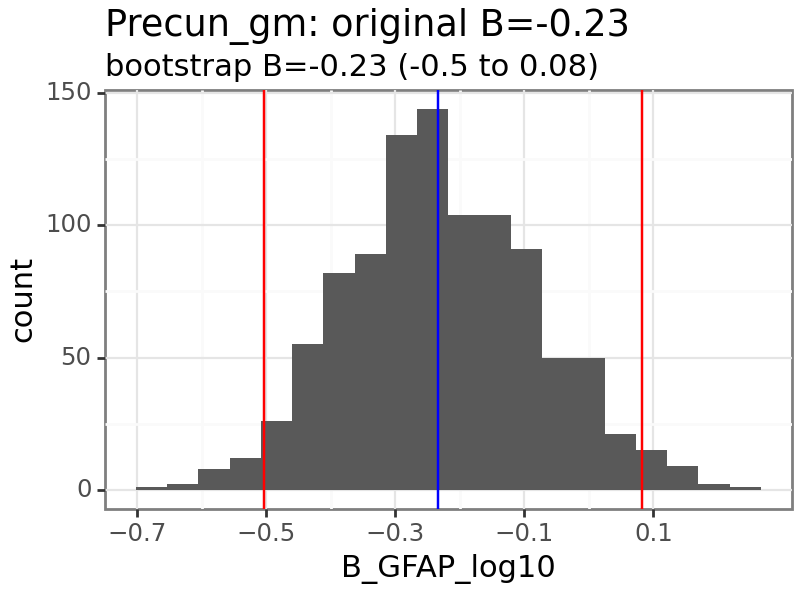

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


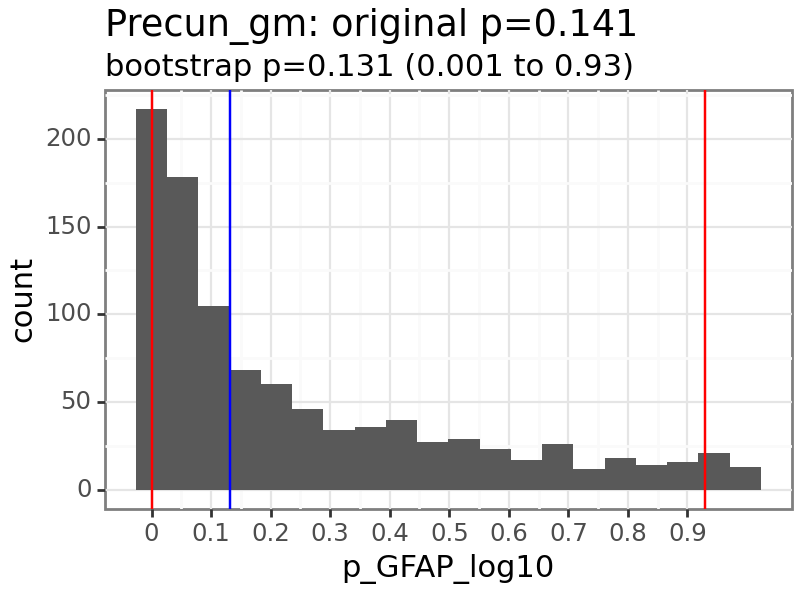

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


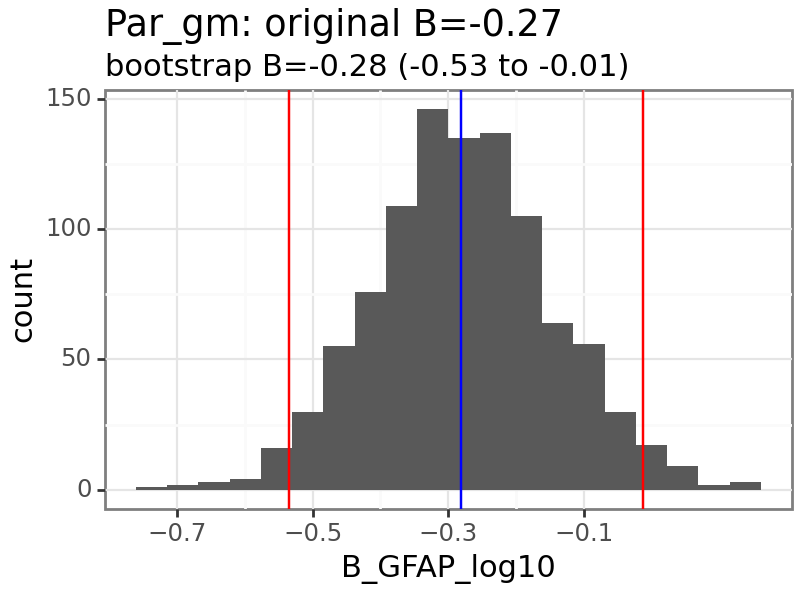

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


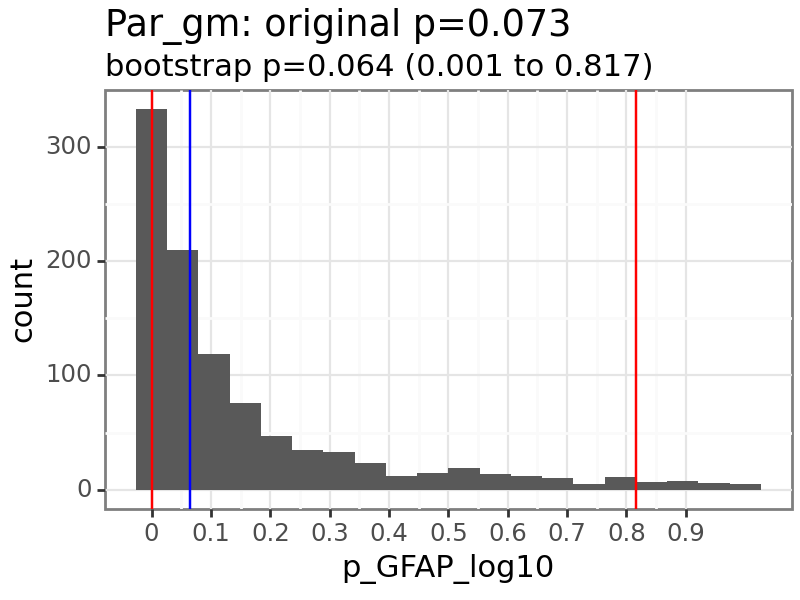

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


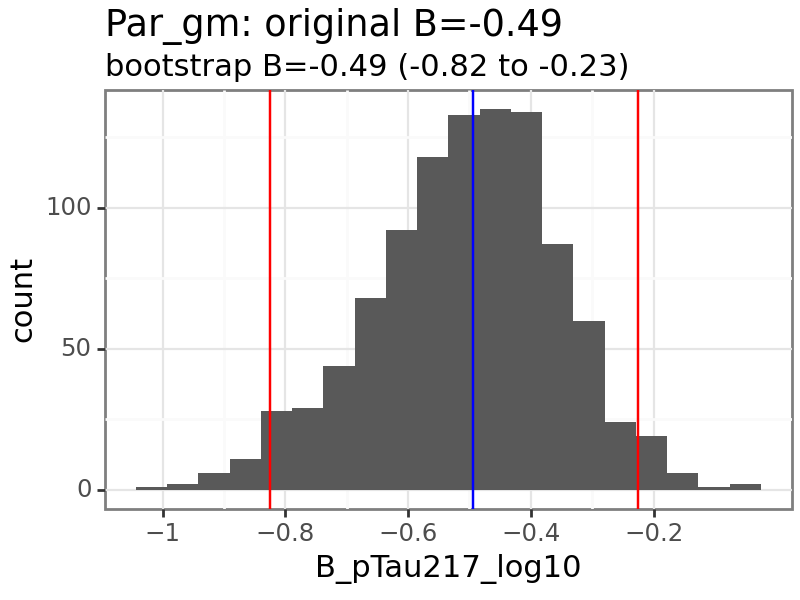

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


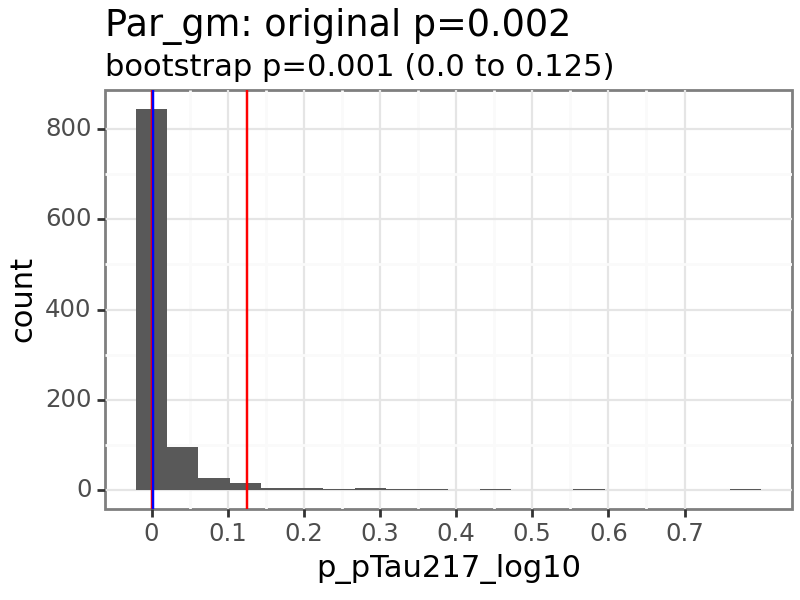

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


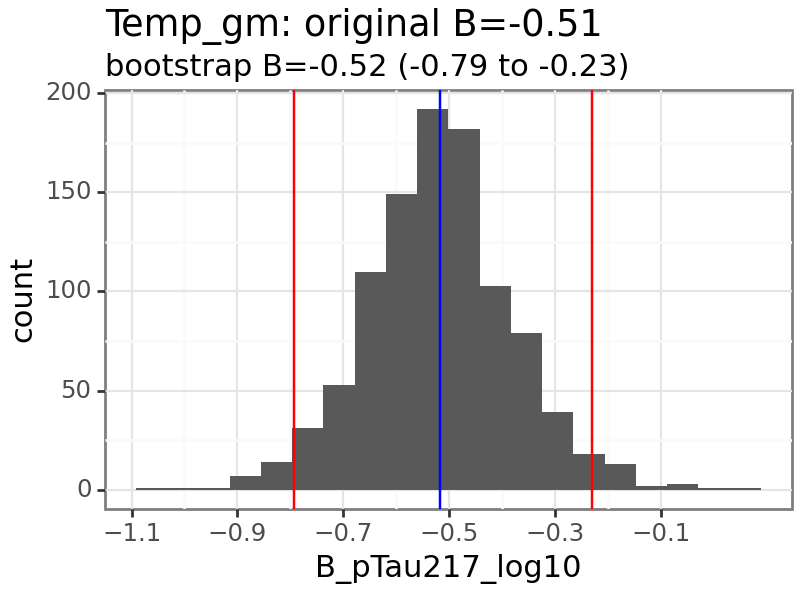

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


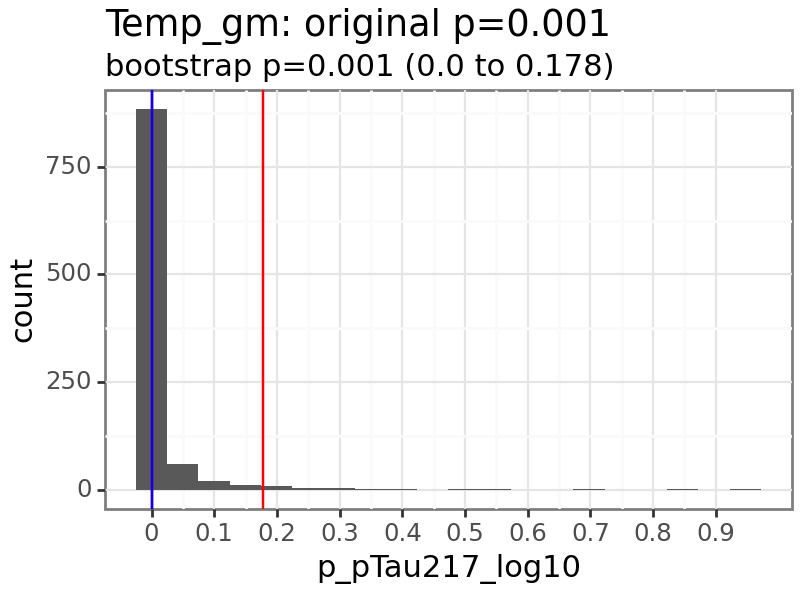

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


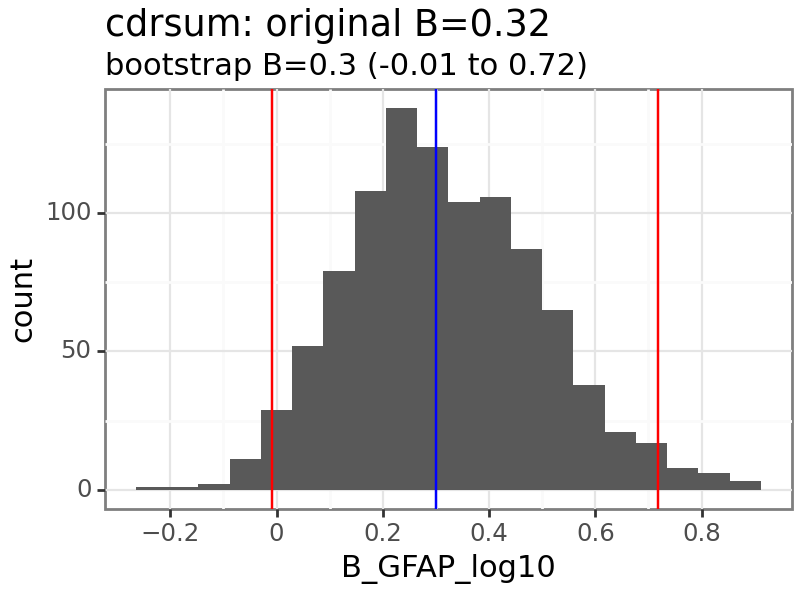

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


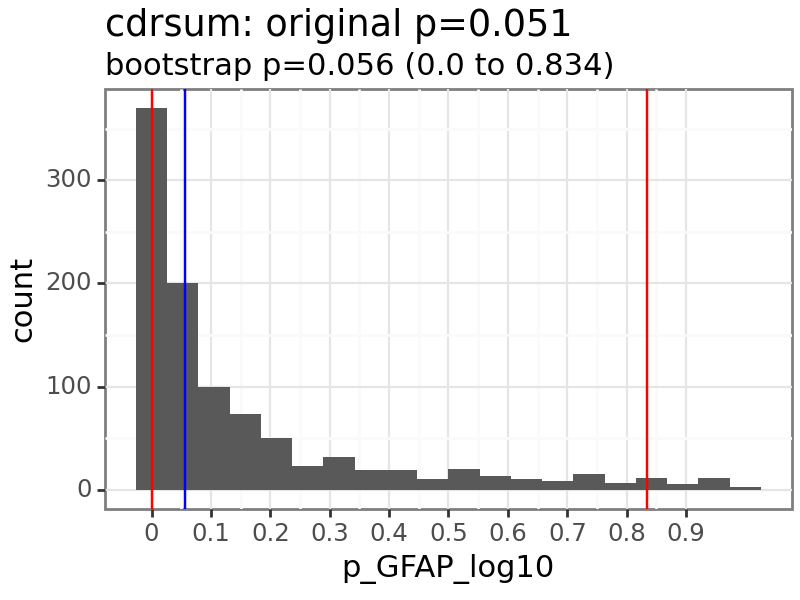

In [12]:
select_combos = model_results.copy()
select_combos = select_combos[\
    (select_combos['x_var'].isin(['pTau217_log10']) & select_combos['y_var'].isin(['Par_gm', 'Temp_gm']) ) | \
    (select_combos['x_var'].isin(['GFAP_log10']) & select_combos['y_var'].isin(['Precun_gm', 'Par_gm', 'cdrsum']) ) \
]
    #| \
    #(select_combos['x_var'].isin(['pTau217_log10']) & select_combos['y_var'].isin(['pTau181_log10', 'pTau231_log10']) ) | \
    #(select_combos['x_var'].isin(['pTau231_log10']) & select_combos['y_var'].isin(['pTau181_log10']) ) | \
    #]
a,  b, c = bootstrap_regression(select_combos)

# Analyses

In [13]:
biomarker_relationship_results_log10 = pd.DataFrame()
biomarker_relationship_results_log10_975 = pd.DataFrame()
biomarker_relationship_results_log10_025 = pd.DataFrame()

significant_combos = model_results.copy()
significant_combos = significant_combos[significant_combos['x_var'].isin(['Ab42_40_log10', 'GFAP_log10', 'NFL_log10', 'pTau181_log10', 'pTau217_log10', 'pTau231_log10'])]
significant_combos = significant_combos[~significant_combos['y_var'].isin(['RASref1_gm', 'Paracentral_gm', 'Ab42_log10', 'pTau181_Ab42_log10', 'Ab40_log10'])]

significant_combos = significant_combos[significant_combos['model_p_val_x_var']<0.05].reset_index(drop = True)
significant_combos

y_var          x_var  \
0                           MTL_gm  Ab42_40_log10   
1                        Precun_gm  Ab42_40_log10   
2                       FRONTAL_gm     GFAP_log10   
3                           MTL_gm  pTau181_log10   
4                       FRONTAL_gm  pTau181_log10   
..                             ...            ...   
81            VOL_Precun_InfPar_Rz  pTau231_log10   
82  VOL_Precun_InfPar_Supramarg_Rz  pTau231_log10   
83            VOL_LatOccLingCun_Lz  pTau231_log10   
84            VOL_LatOccLingCun_Rz  pTau231_log10   
85              VOL_InfParSupra_Rz  pTau231_log10   

                                 model_p_val_baseline  \
0   Intercept          0.917548
Education_years   ...   
1   Intercept          0.911983
age               ...   
2   Intercept     1.000000
GFAP_log10    0.039403
...   
3   Intercept          0.916078
Education_years   ...   
4   Intercept          0.987310
age               ...   
..                                                ...   
81  Intercept          1.000000
age               ...   
82  Intercept          1.000000
age               ...   
83  Intercept        1.000000
pTau231_log10    0.0...   
84  Intercept        1.000000
pTau231_log10    0.0...   
85  Intercept          1.000000
age               ...   

                                 model_B_val_baseline  model_n_baseline  \
0   Intercept         -0.014719
Education_years   ...                35   
1   Intercept         -0.016633
age               ...                35   
2   Intercept     5.898060e-17
GFAP_log10   -3.191...                42   
3   Intercept          0.012391
Education_years   ...                41   
4   Intercept          0.002319
age               ...                41   
..                                                ...               ...   
81  Intercept         -5.551115e-17
age           ...                32   
82  Intercept          5.551115e-17
age           ...                32   
83  Intercept        0.000000
pTau231_log10    0.3...                32   
84  Intercept        0.000000
pTau231_log10    0.4...                32   
85  Intercept          2.775558e-17
age           ...                32   

    model_p_val_Intercept  model_p_val_Education_years  model_p_val_x_var  \
0                0.917548                     0.002342           0.010588   
1                0.911983                     0.024805           0.021403   
2                1.000000                          NaN           0.039403   
3                0.916078                     0.000017           0.000048   
4                0.987310                     0.005070           0.031049   
..                    ...                          ...                ...   
81               1.000000                     0.005062           0.011934   
82               1.000000                     0.017335           0.008586   
83               1.000000                          NaN           0.040319   
84               1.000000                          NaN           0.012228   
85               1.000000                     0.017393           0.008278   

    model_B_val_Intercept  model_B_val_Education_years  model_B_val_x_var  \
0           -1.471869e-02                     0.467310           0.389317   
1           -1.663288e-02                     0.364864           0.373903   
2            5.898060e-17                          NaN          -0.319124   
3            1.239115e-02                     0.589548           0.547130   
4            2.318824e-03                     0.473807           0.343053   
..                    ...                          ...                ...   
81          -5.551115e-17                     0.420651           0.365489   
82           5.551115e-17                     0.355296           0.390247   
83           0.000000e+00                          NaN           0.364402   
84           0.000000e+00                          NaN           0.437723   
85           2.775558e-17         

# Ab42/40 bootstrapping

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


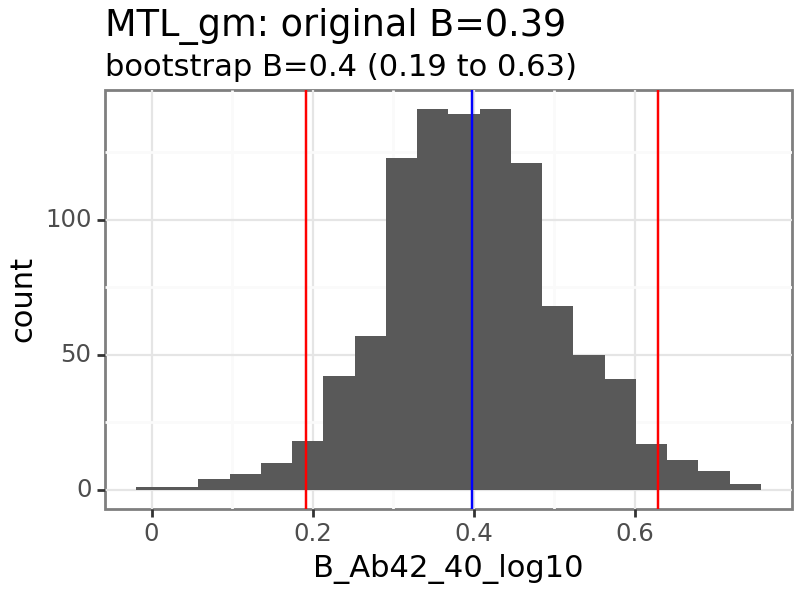

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


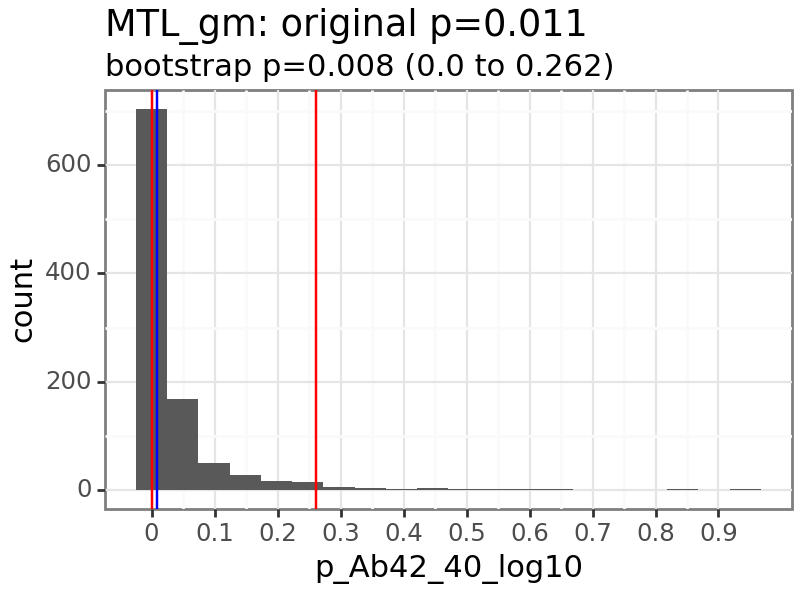

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


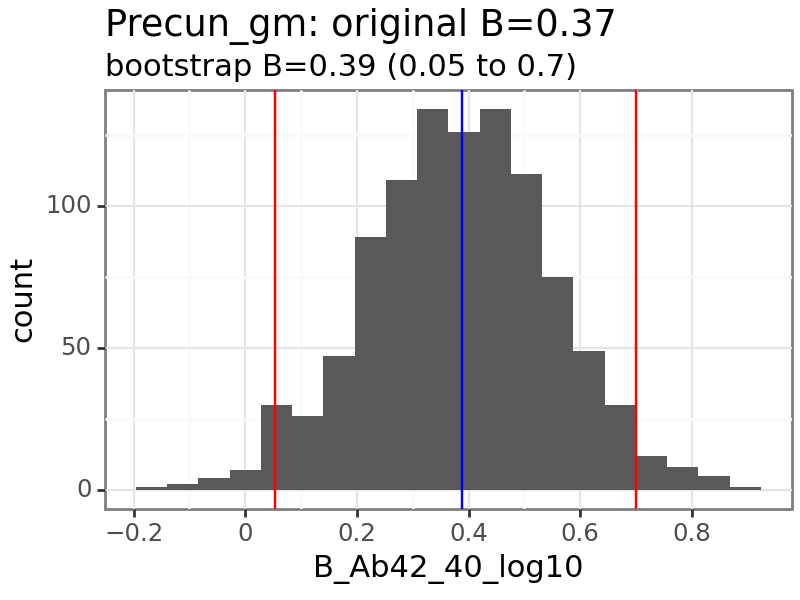

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


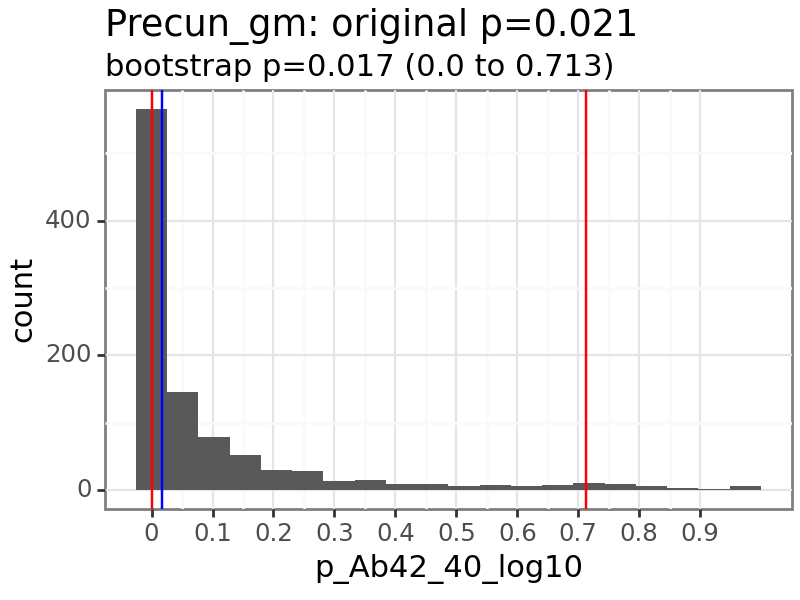

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


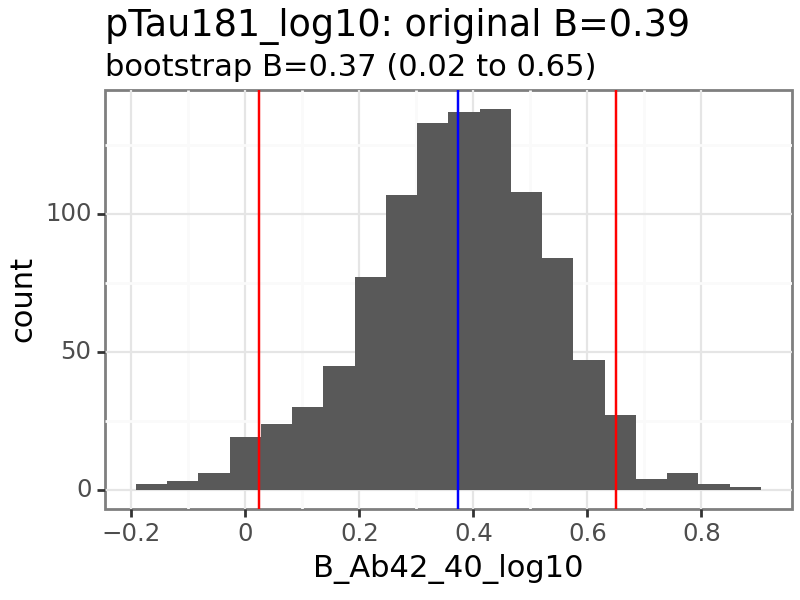

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


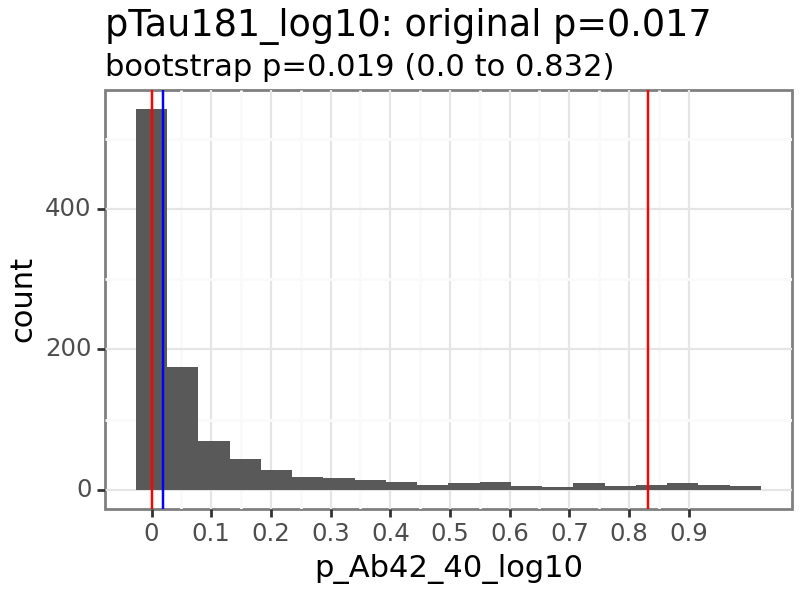

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


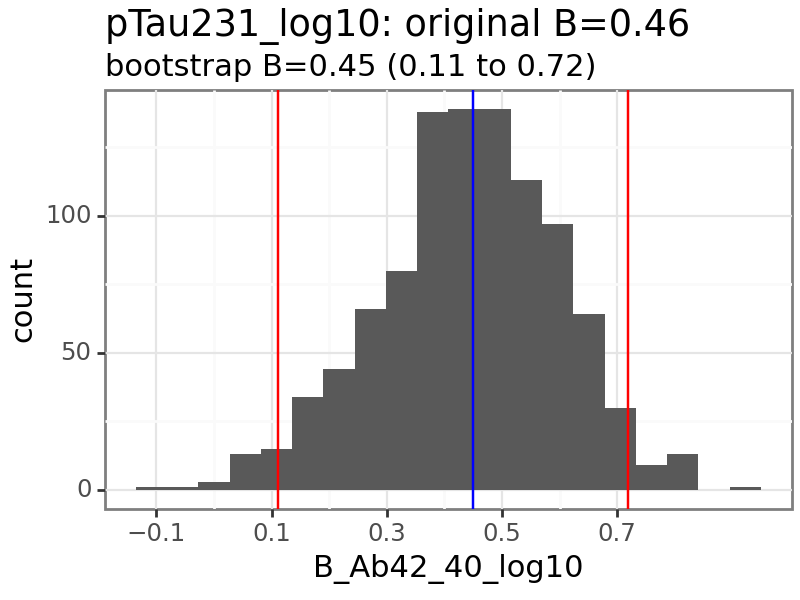

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


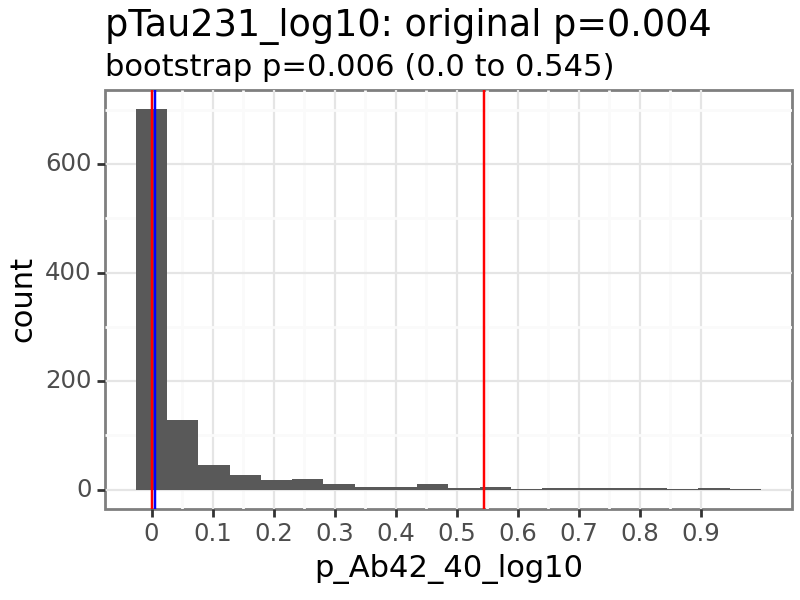

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


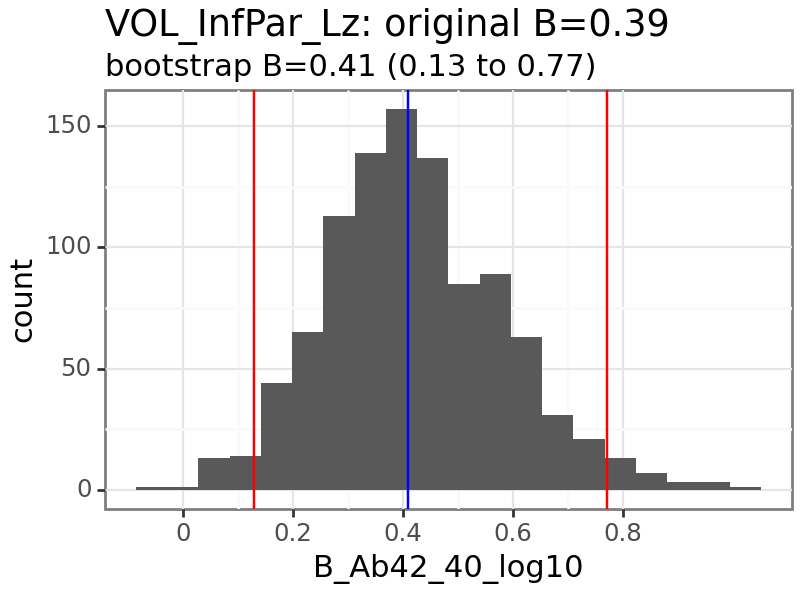

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


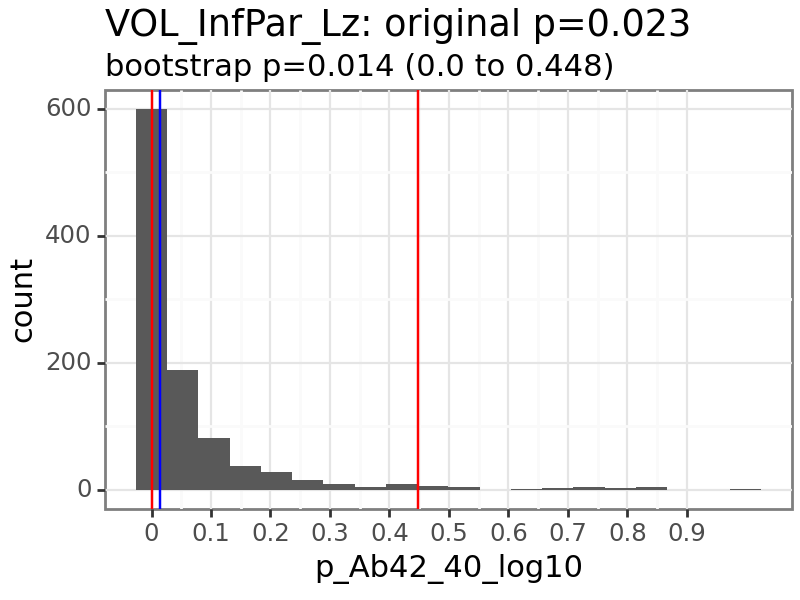

In [14]:
a,  b, c = bootstrap_regression(significant_combos[significant_combos['x_var'].isin(['Ab42_40_log10'])])
biomarker_relationship_results_log10 = pd.concat([biomarker_relationship_results_log10, a])
biomarker_relationship_results_log10_975 = pd.concat([biomarker_relationship_results_log10_975, b])
biomarker_relationship_results_log10_025 = pd.concat([biomarker_relationship_results_log10_025, c])

# GFAP bootstrapping

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


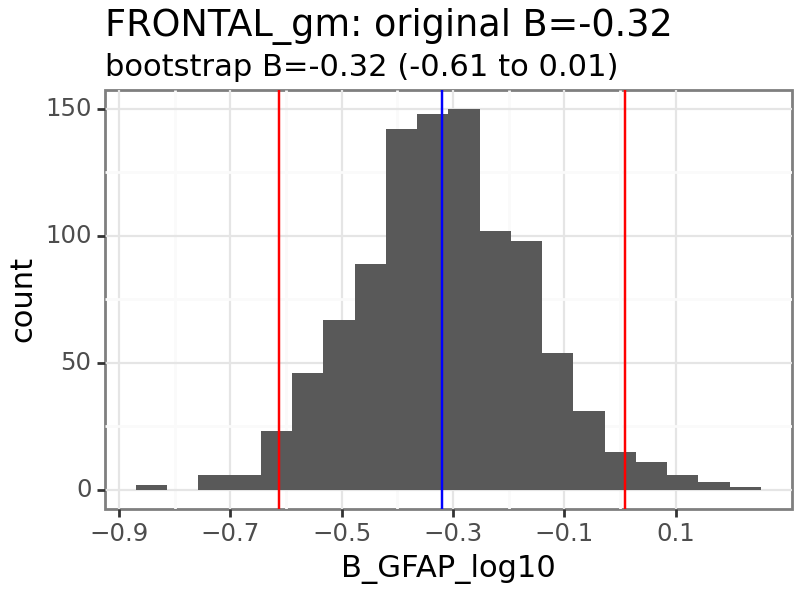

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


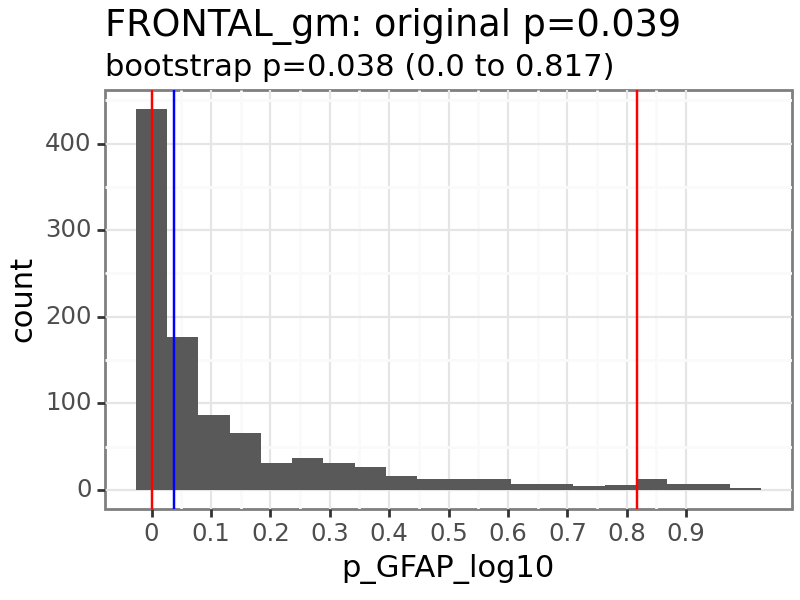

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


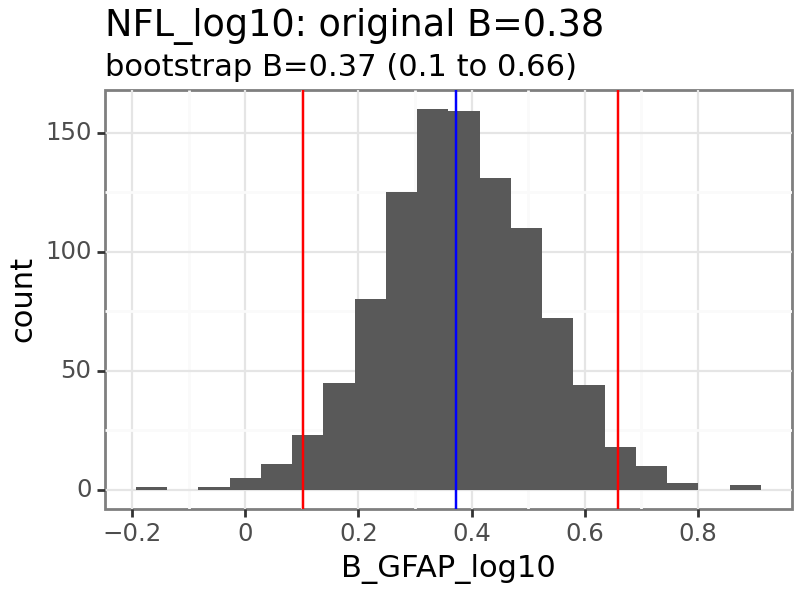

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


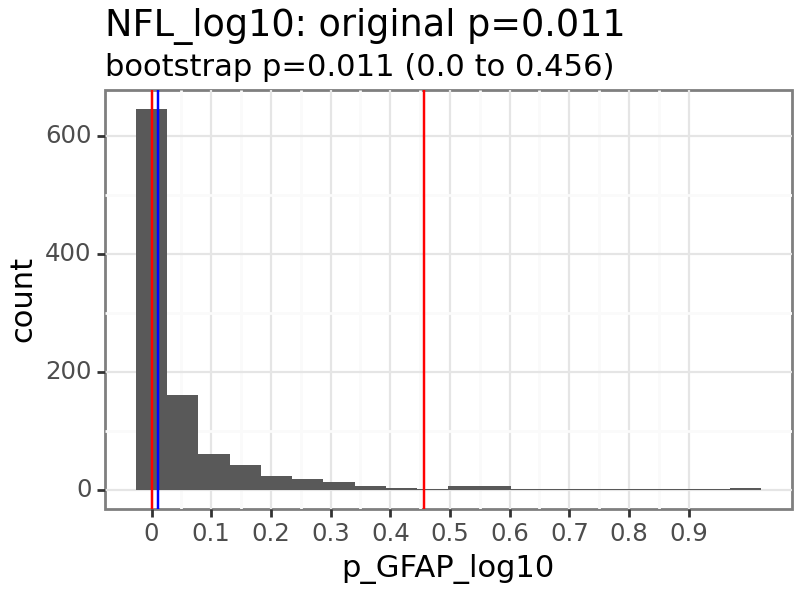

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


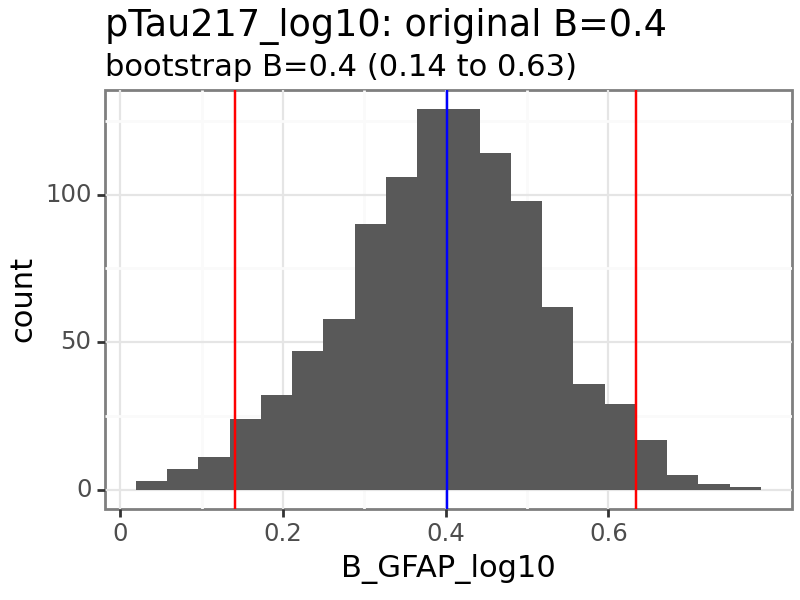

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


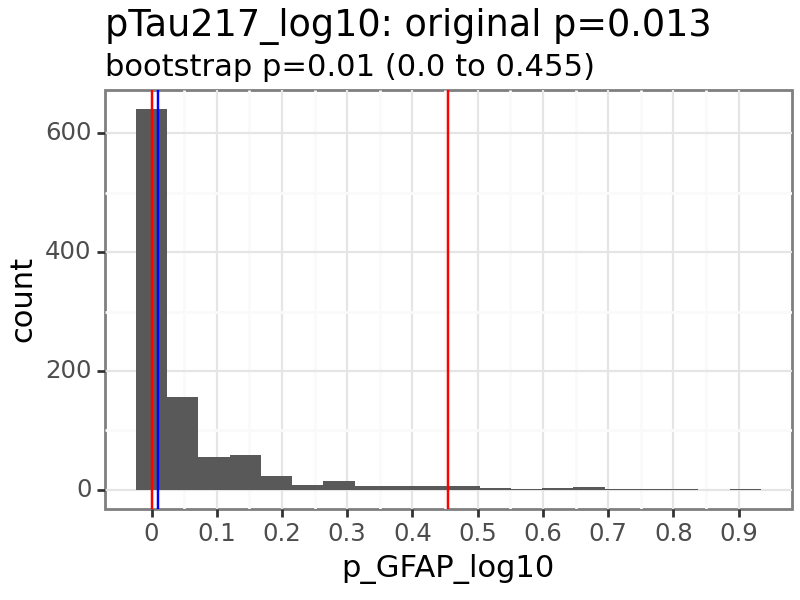

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


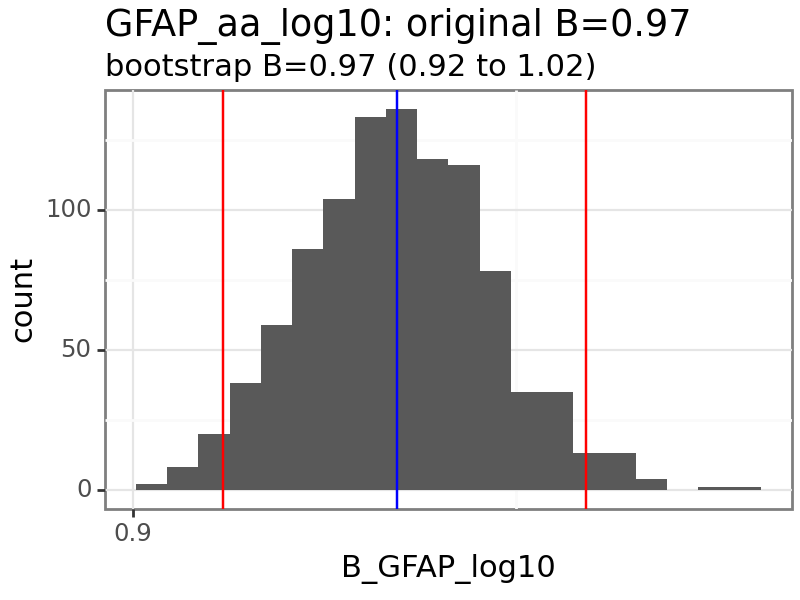

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


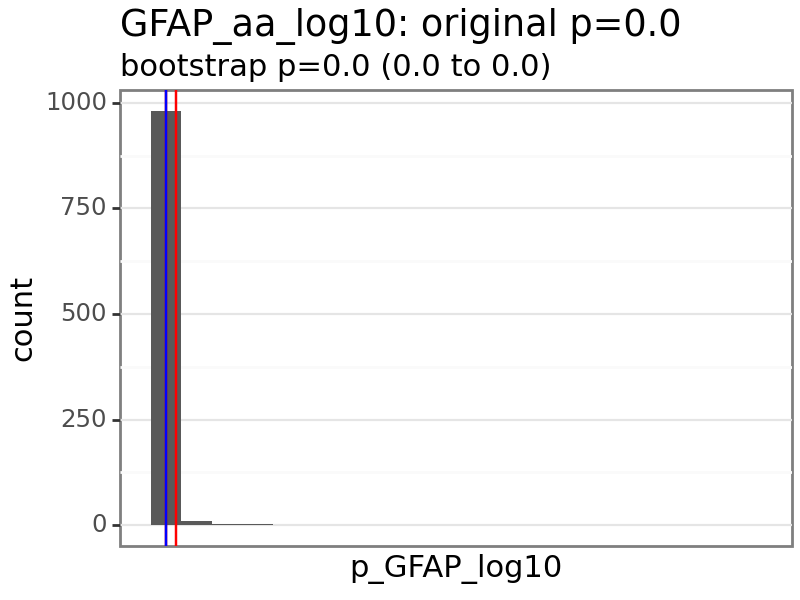

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


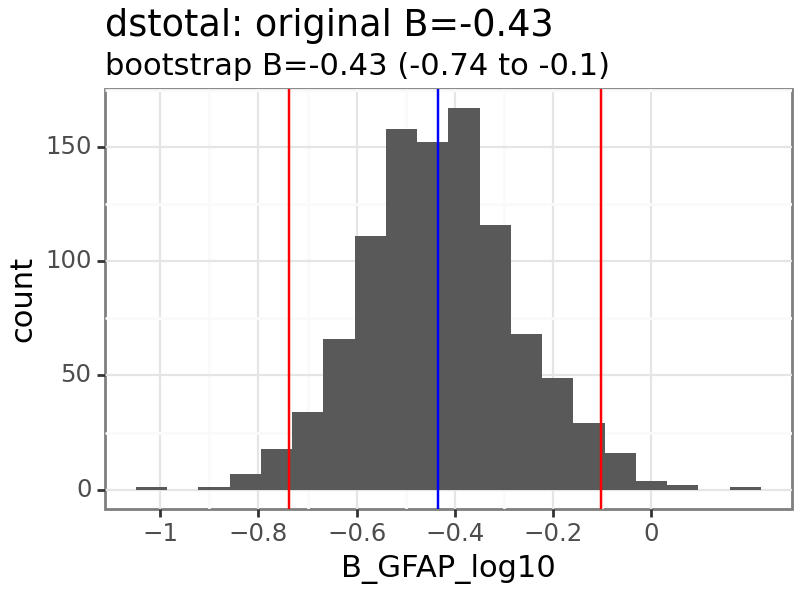

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


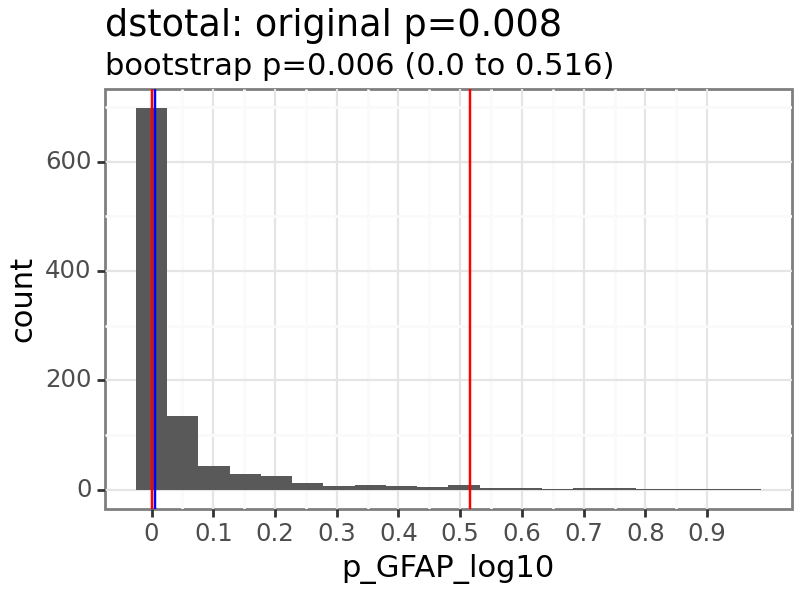

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


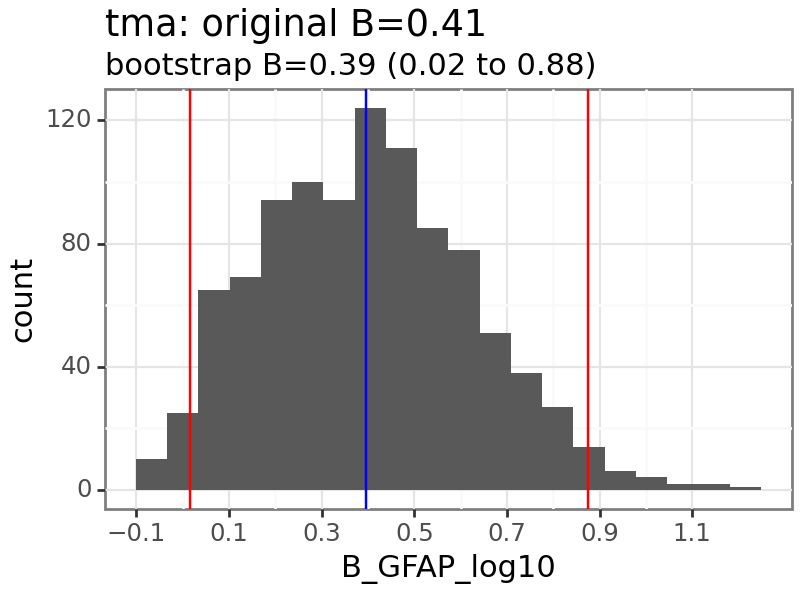

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


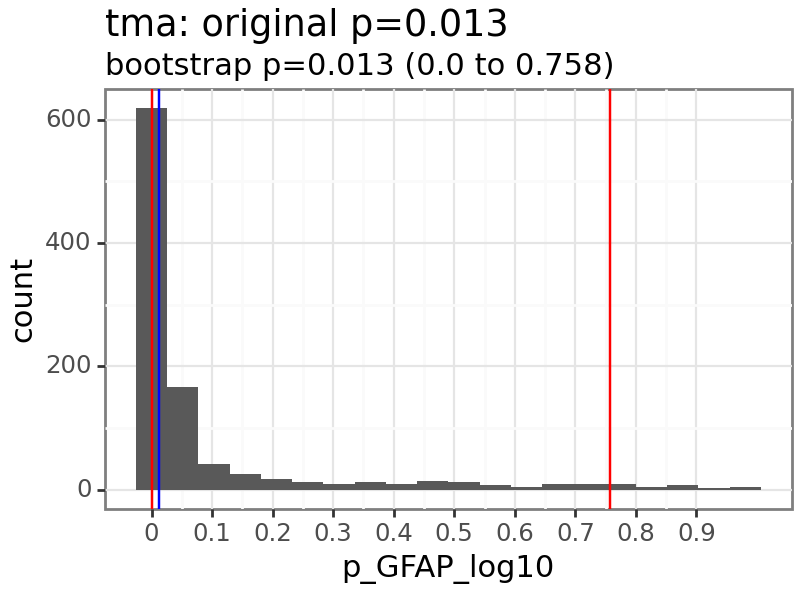

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


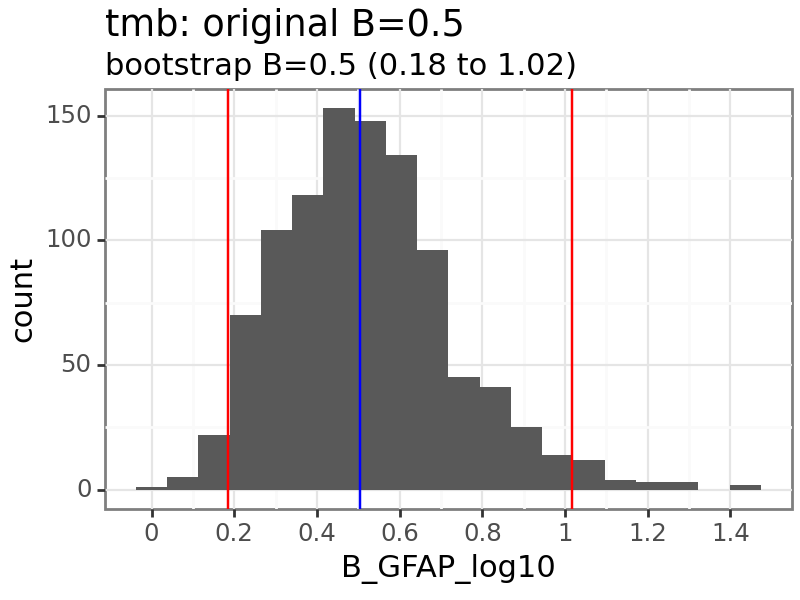

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


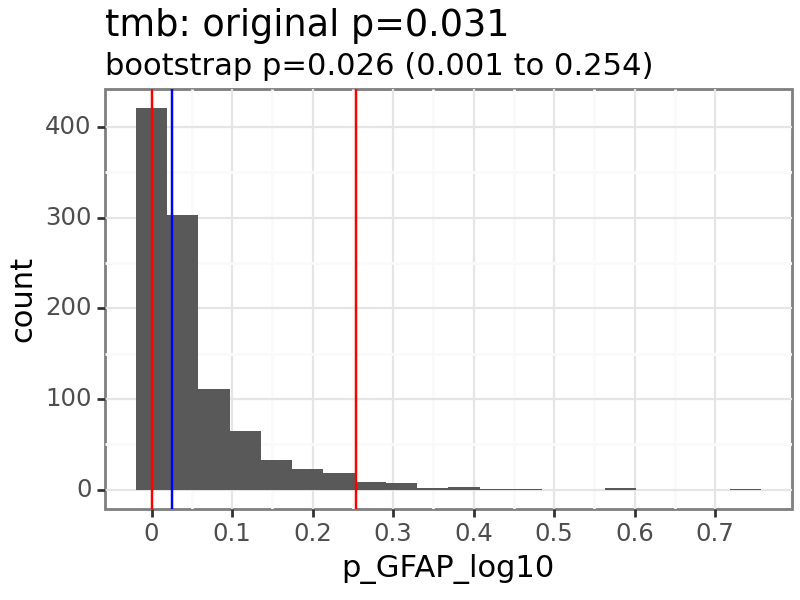

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


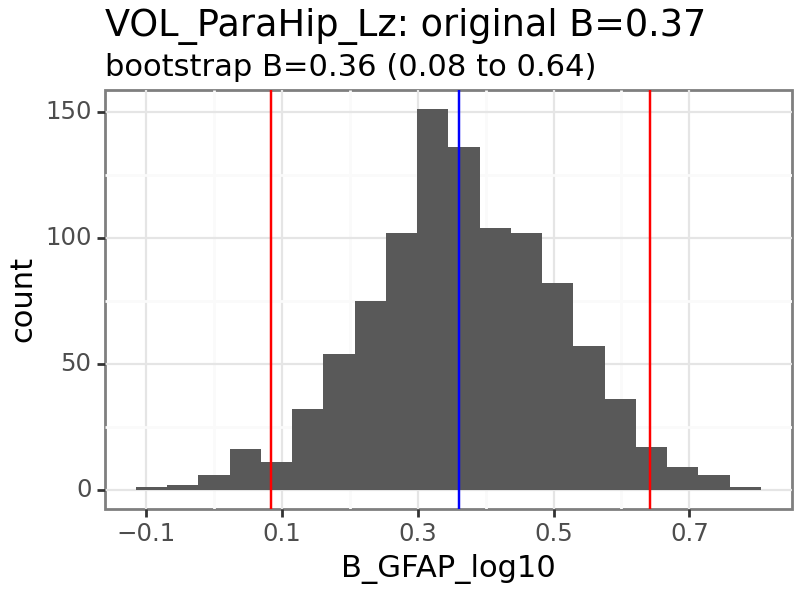

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


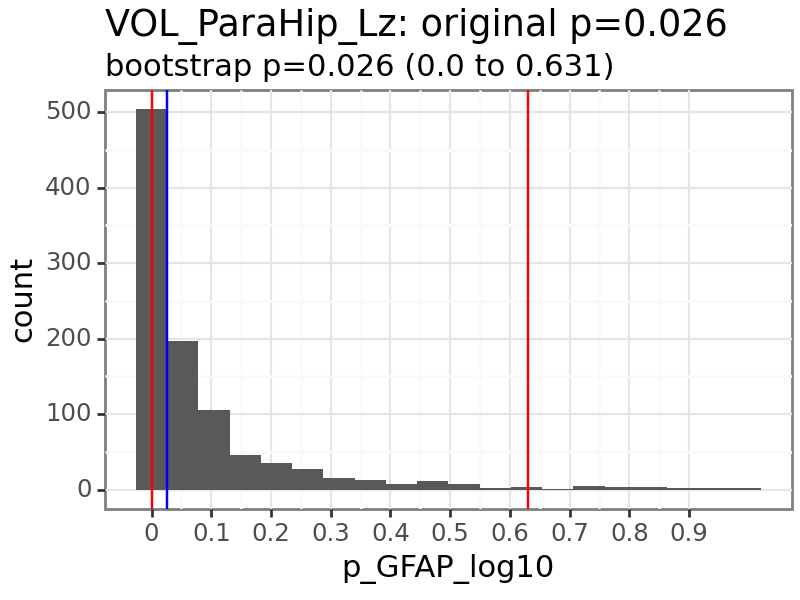

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


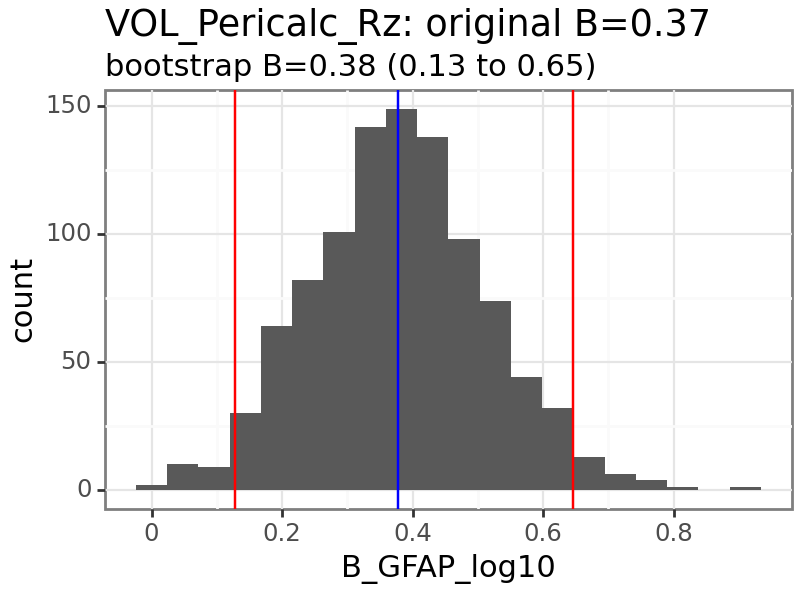

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


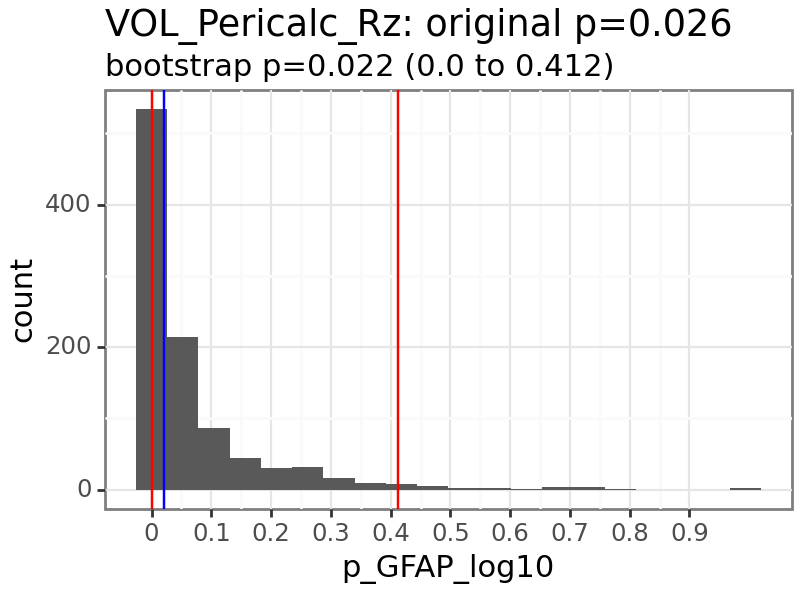

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


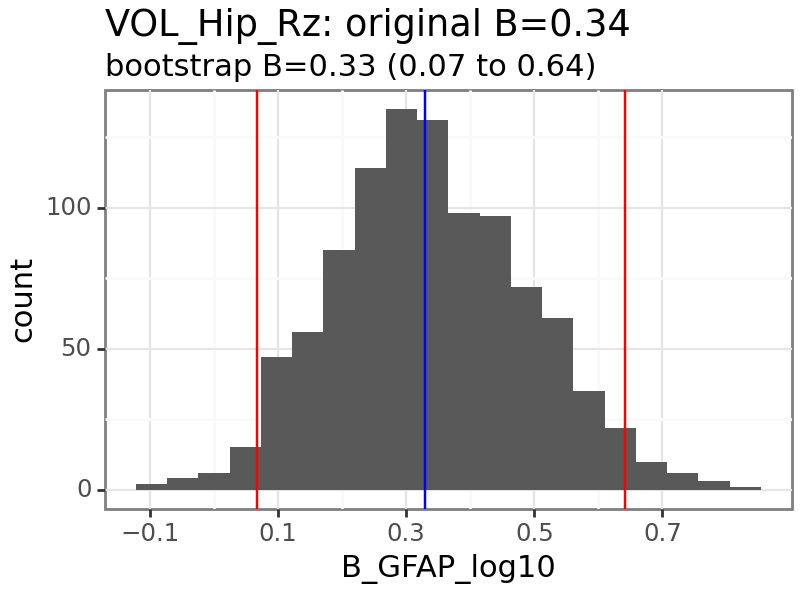

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


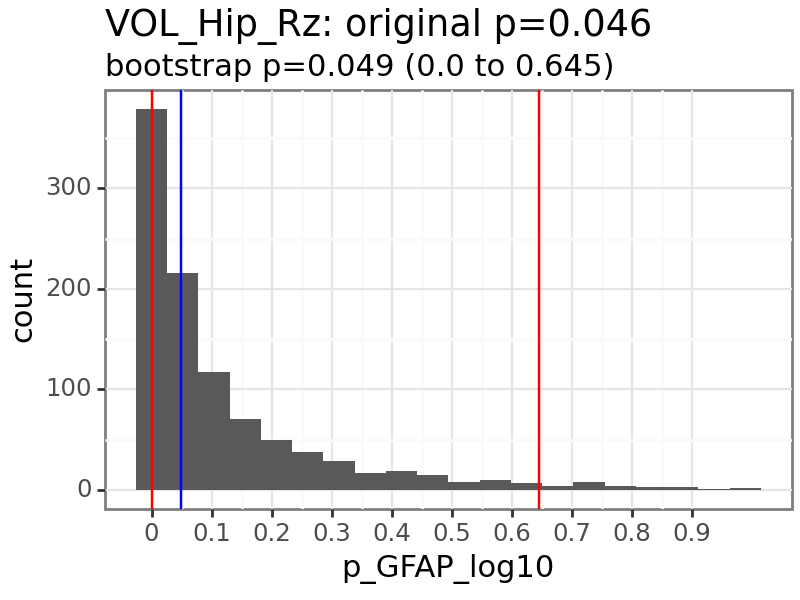

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


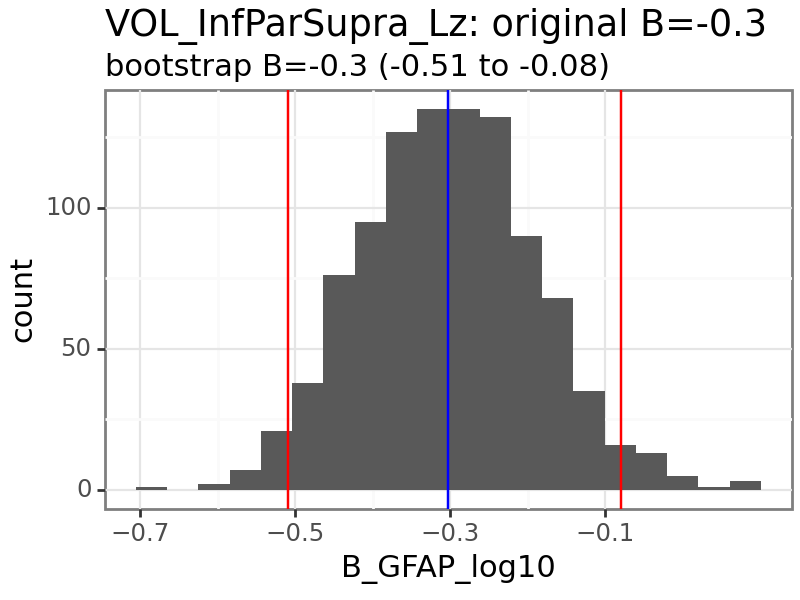

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


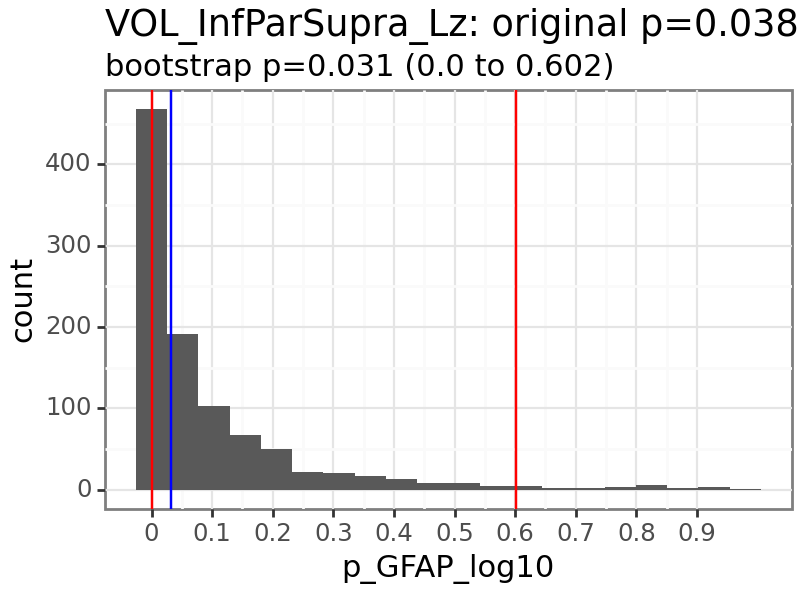

In [15]:
a,  b, c = bootstrap_regression(significant_combos[significant_combos['x_var'].isin(['GFAP_log10'])])
biomarker_relationship_results_log10 = pd.concat([biomarker_relationship_results_log10, a])
biomarker_relationship_results_log10_975 = pd.concat([biomarker_relationship_results_log10_975, b])
biomarker_relationship_results_log10_025 = pd.concat([biomarker_relationship_results_log10_025, c])

# NFL bootstrapping

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


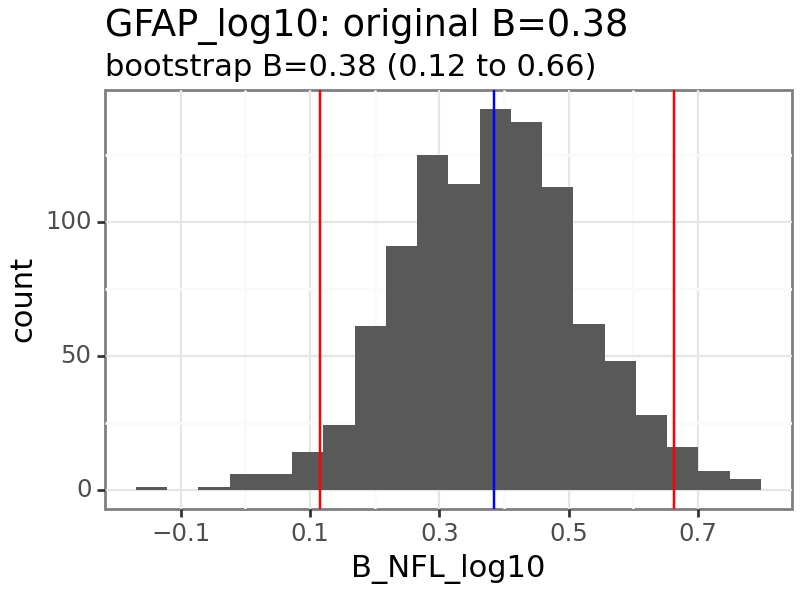

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


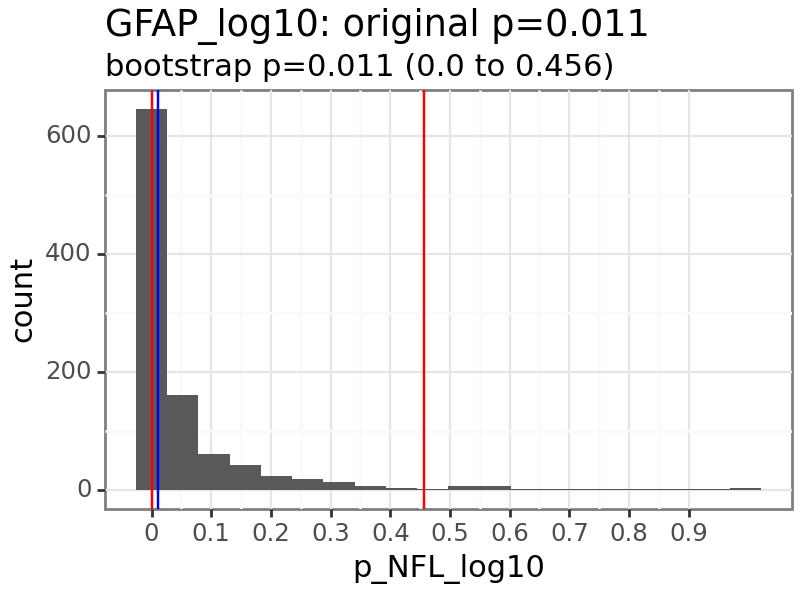

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


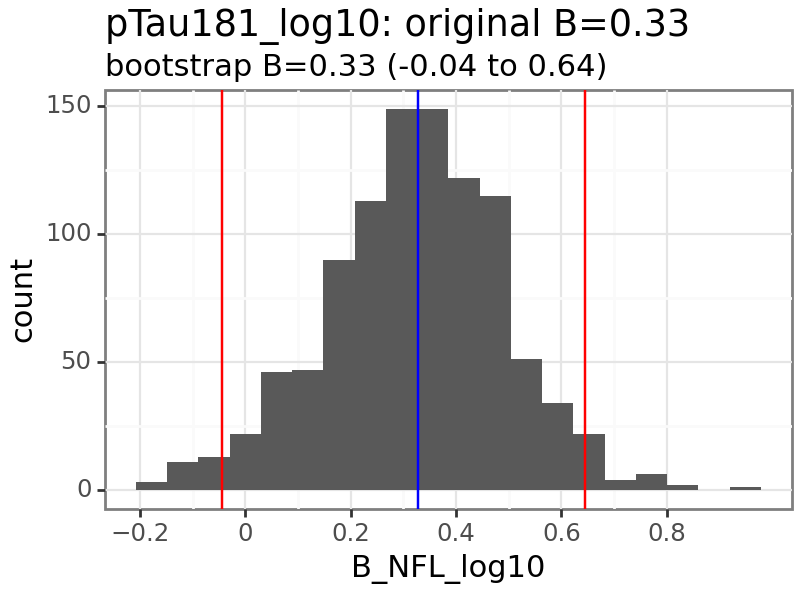

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


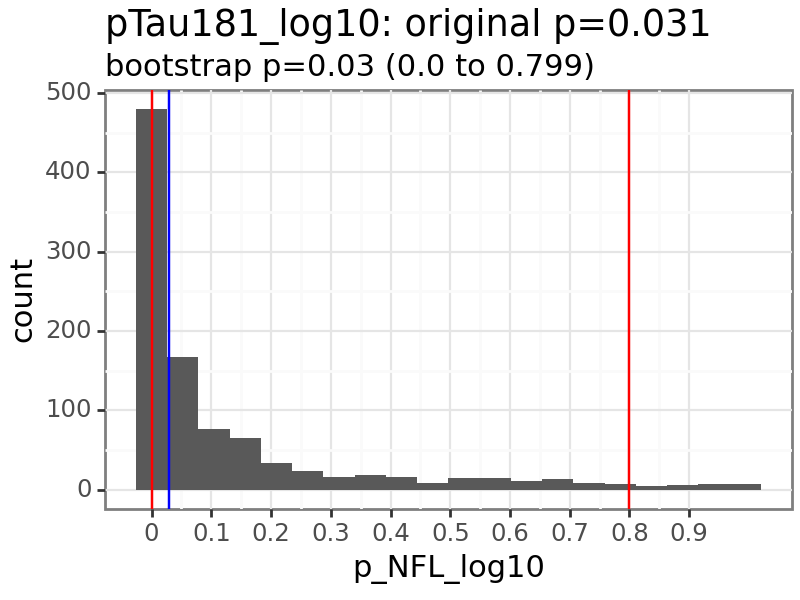

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


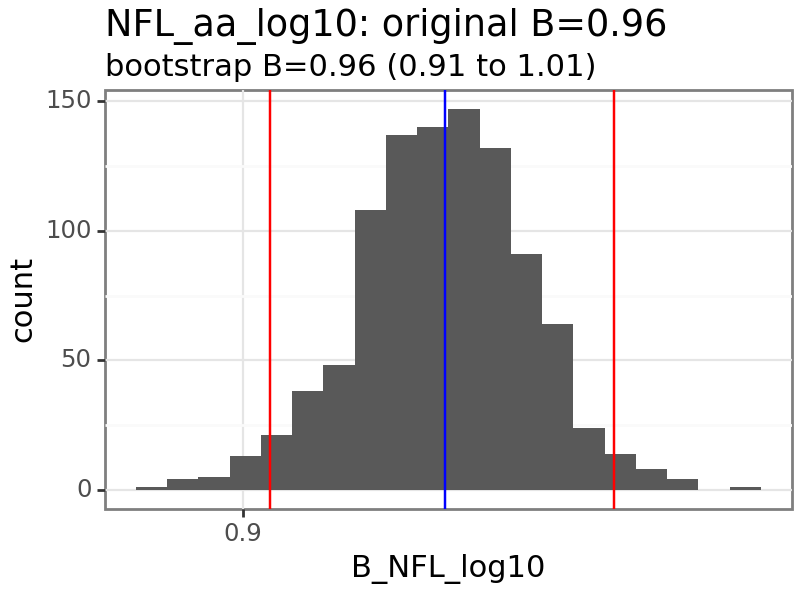

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


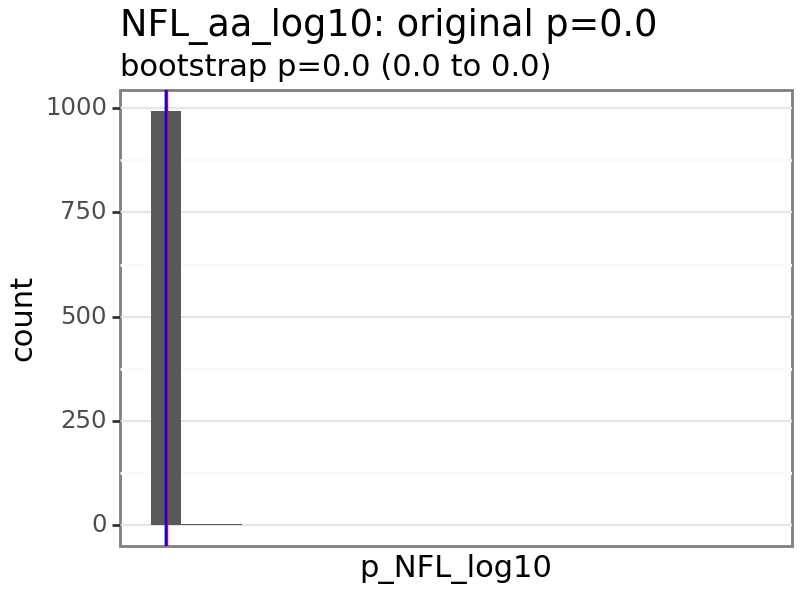

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


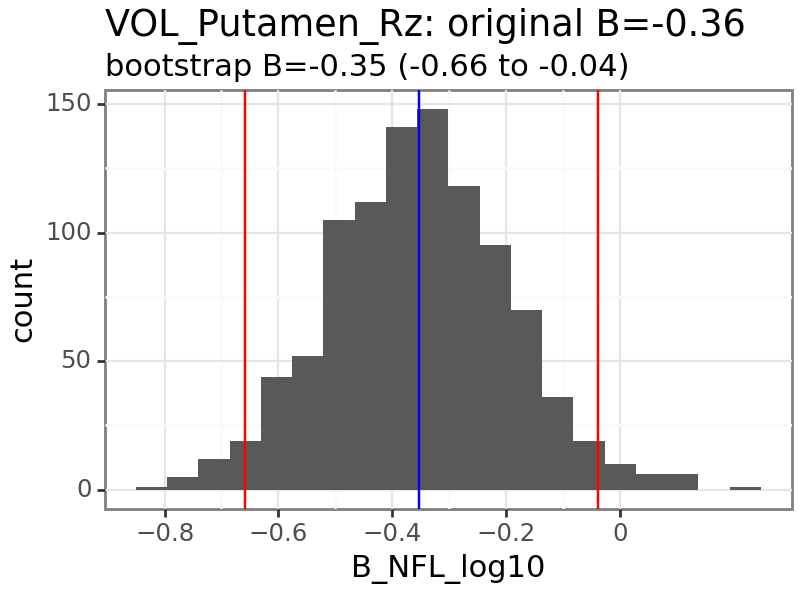

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


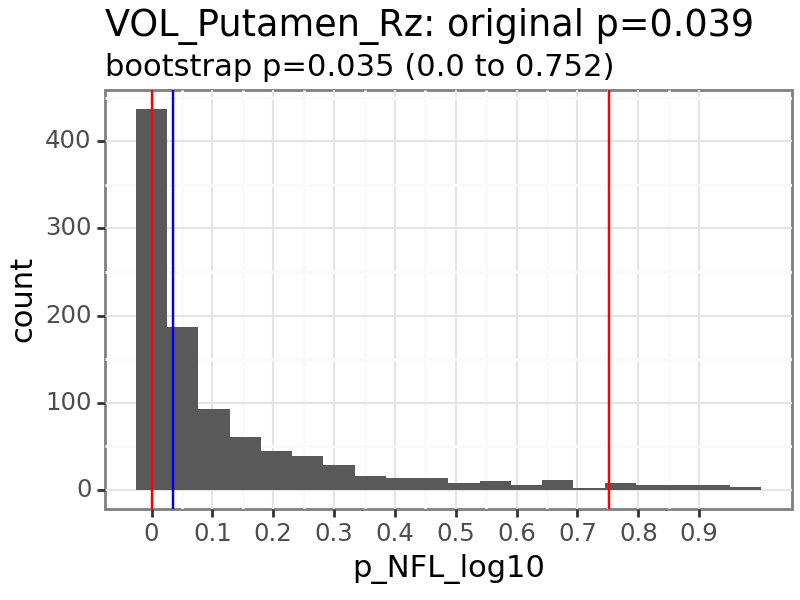

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


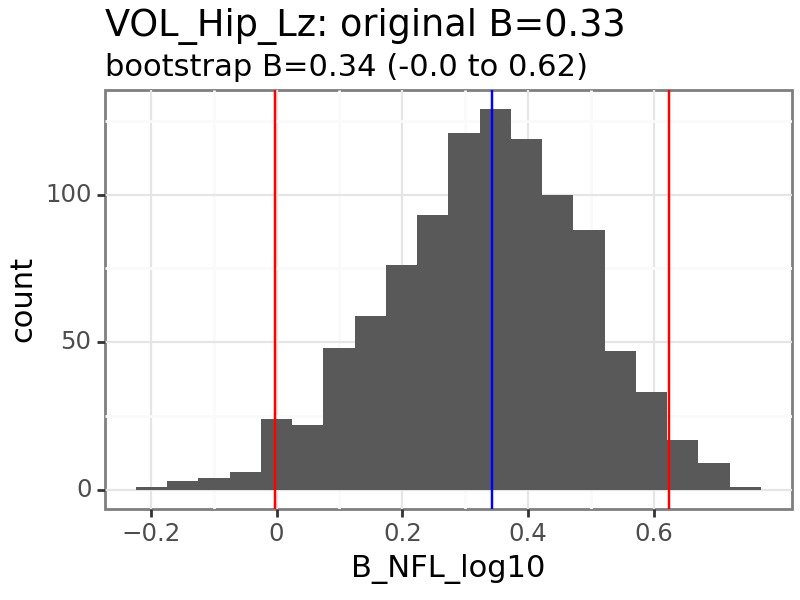

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


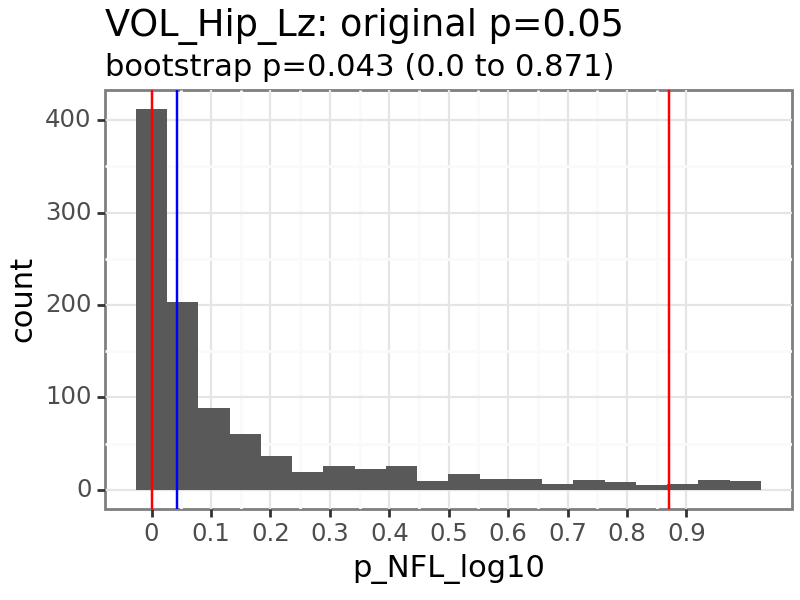

In [16]:
a,  b, c = bootstrap_regression(significant_combos[significant_combos['x_var'].isin(['NFL_log10'])])
biomarker_relationship_results_log10 = pd.concat([biomarker_relationship_results_log10, a])
biomarker_relationship_results_log10_975 = pd.concat([biomarker_relationship_results_log10_975, b])
biomarker_relationship_results_log10_025 = pd.concat([biomarker_relationship_results_log10_025, c])

# pTau217 bootstrapping

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


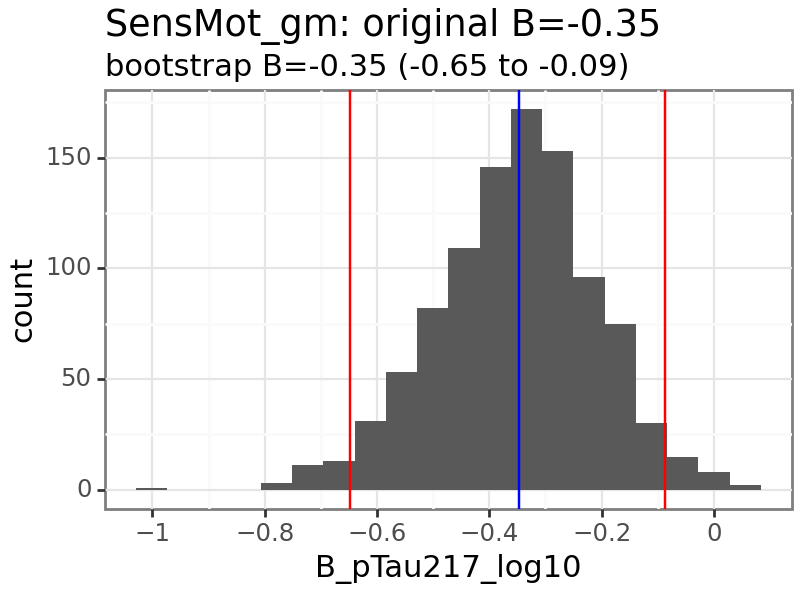

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


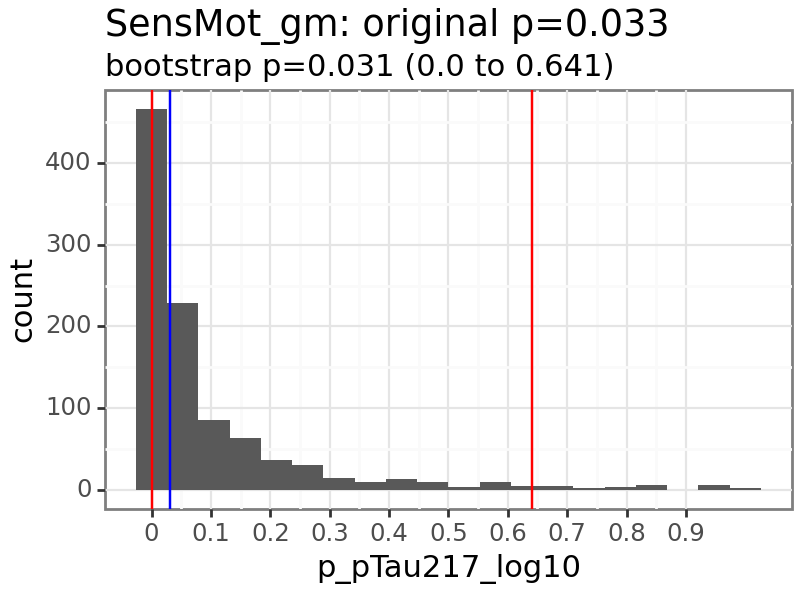

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


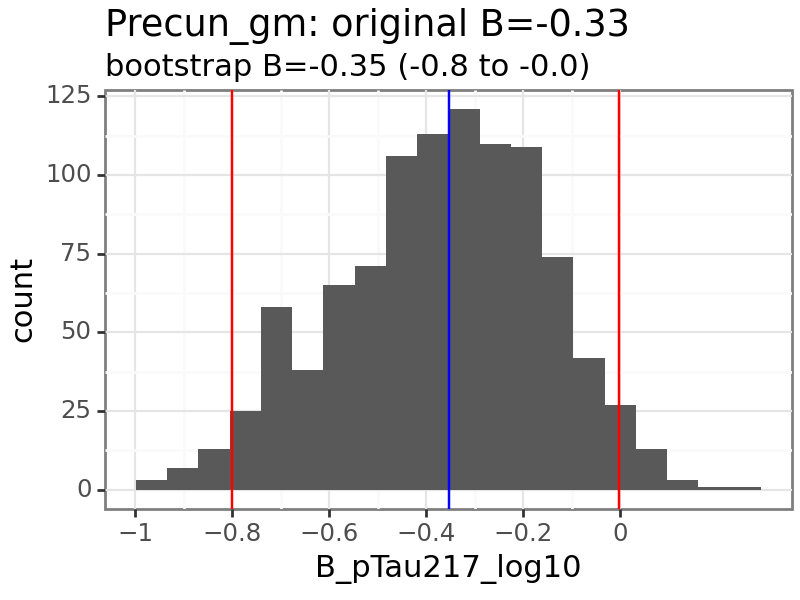

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


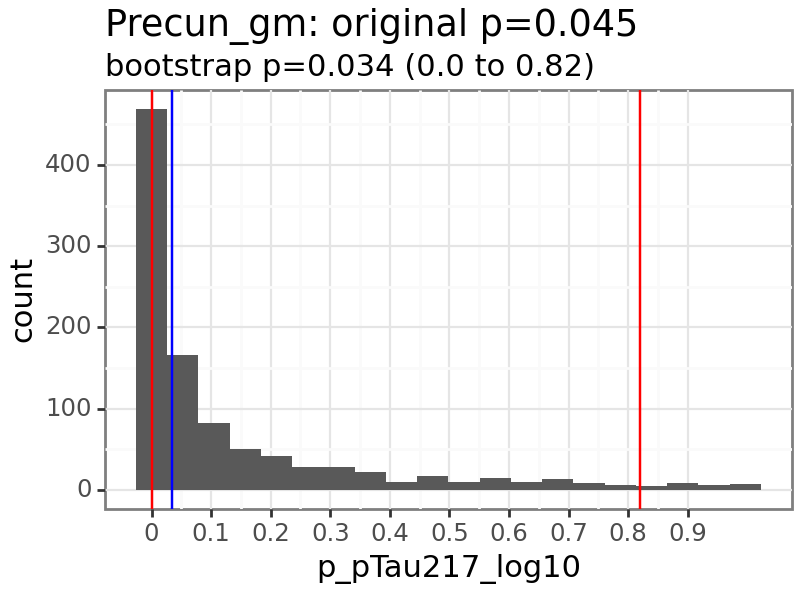

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


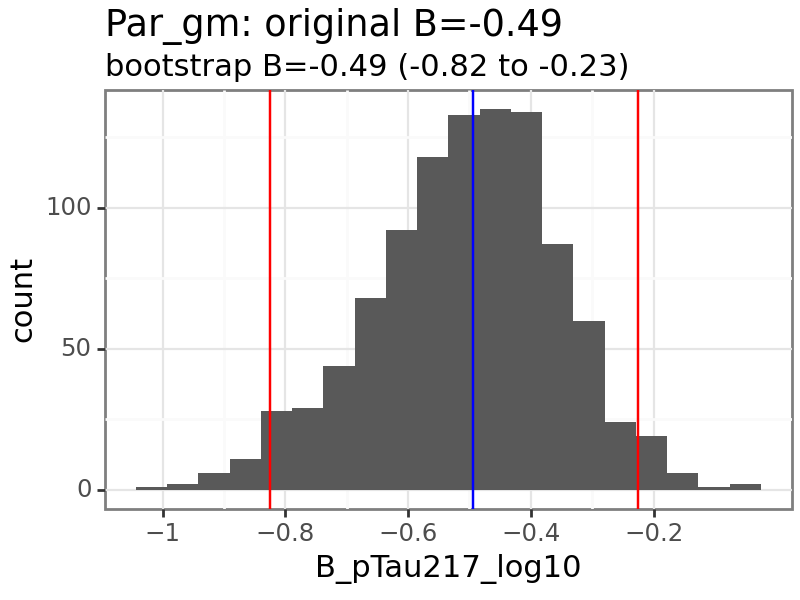

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


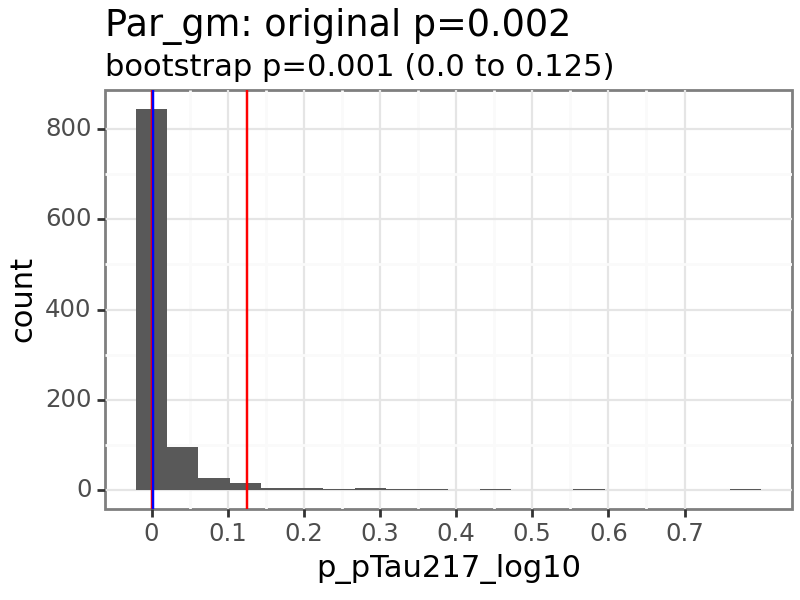

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


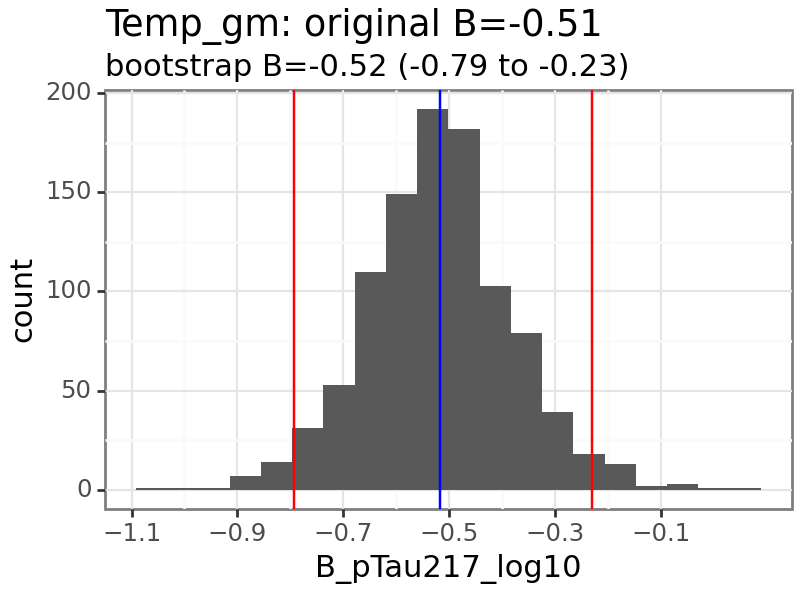

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


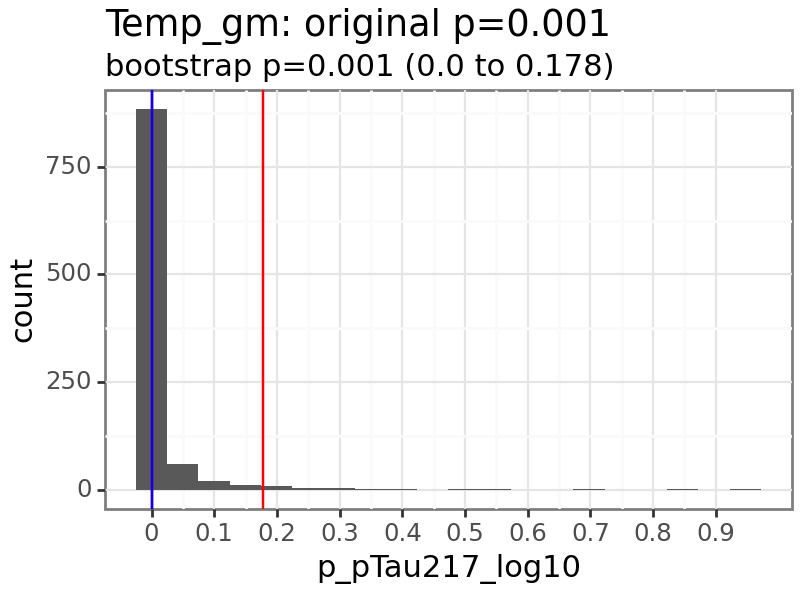

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


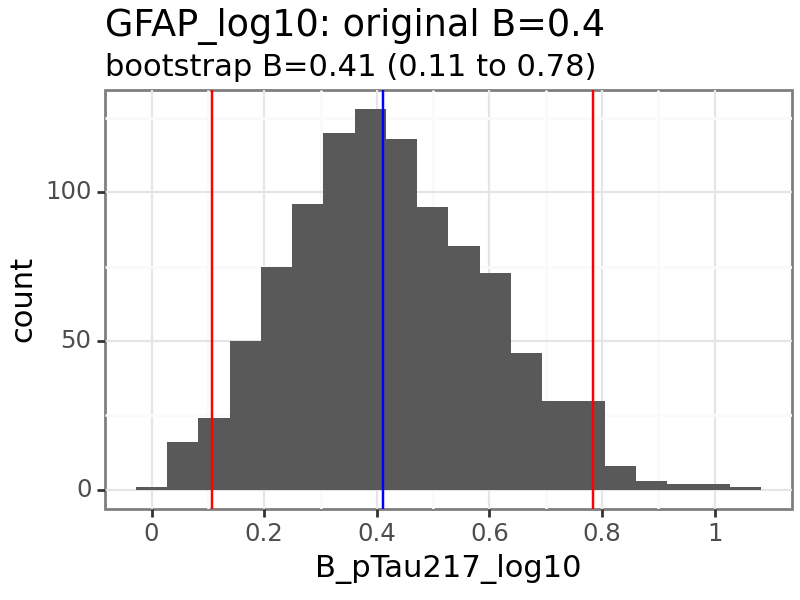

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


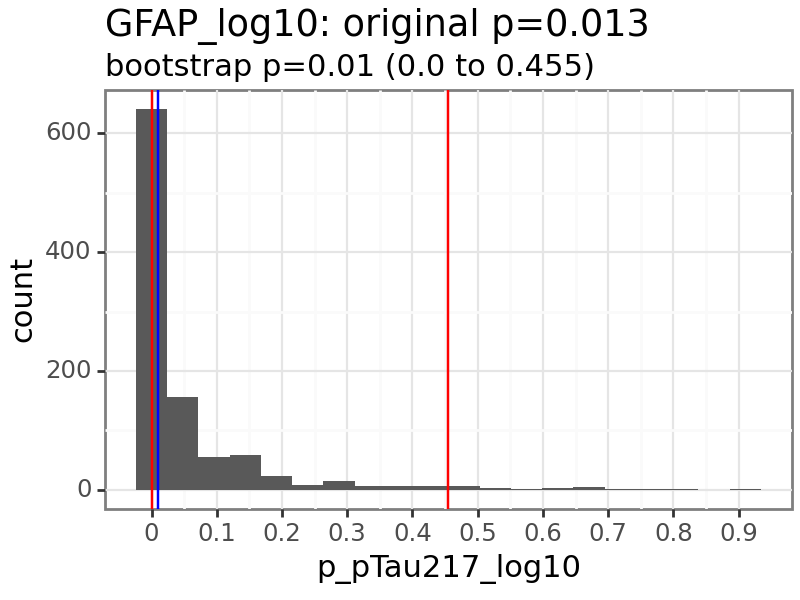

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


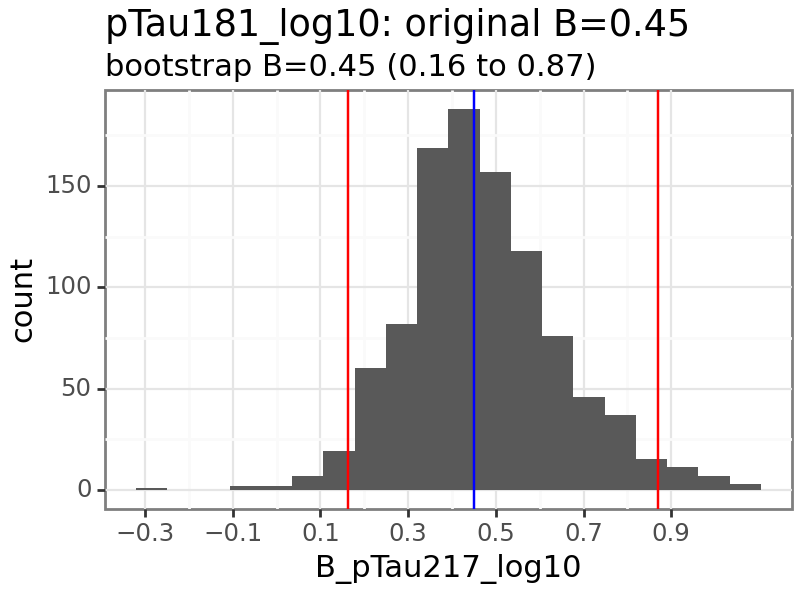

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


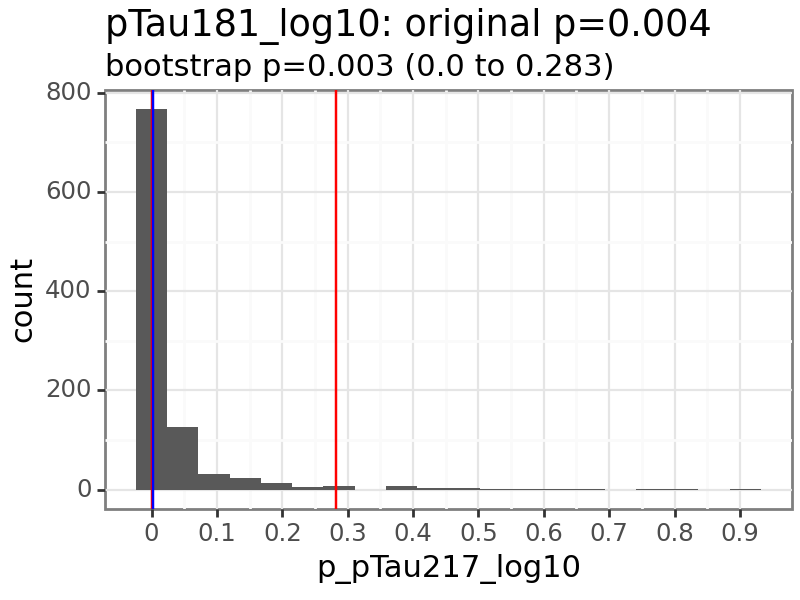

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


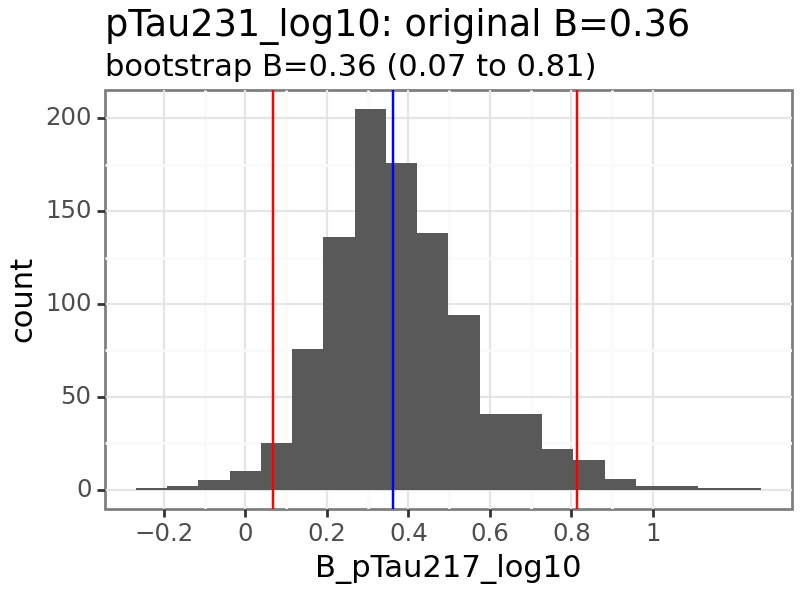

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


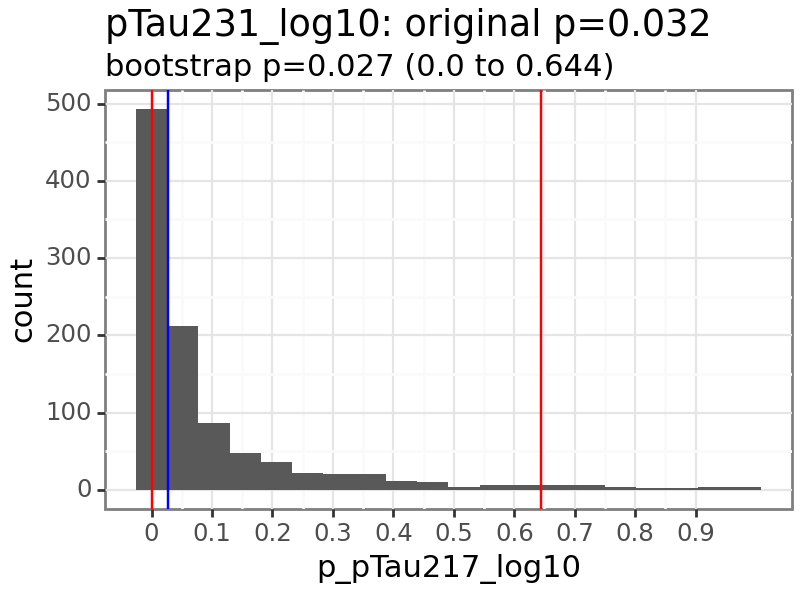

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


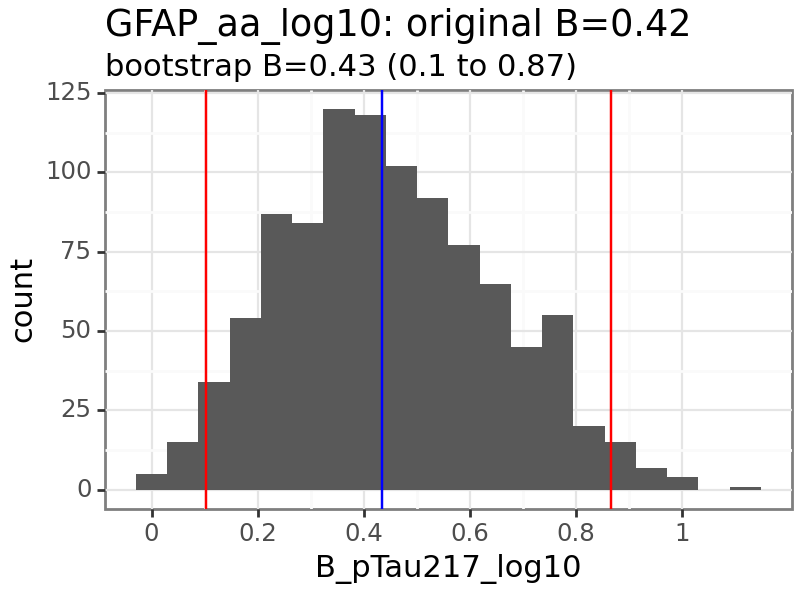

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


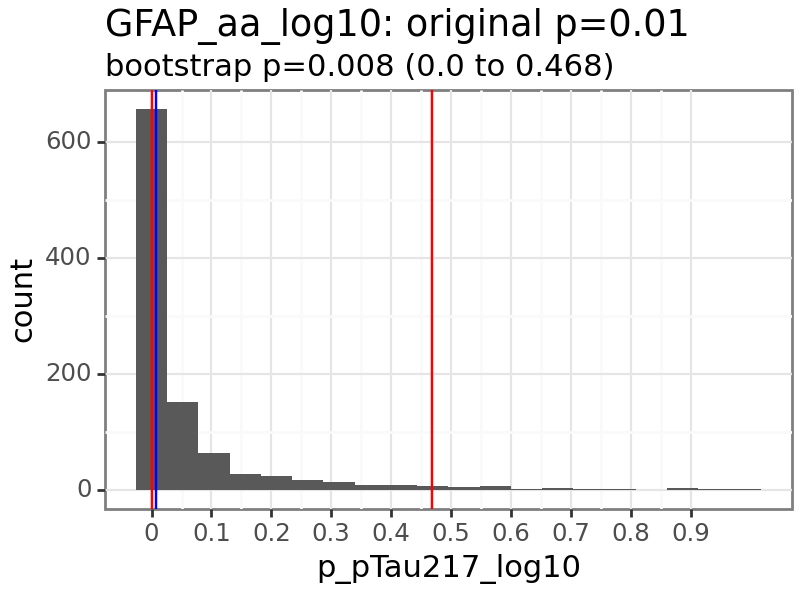

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


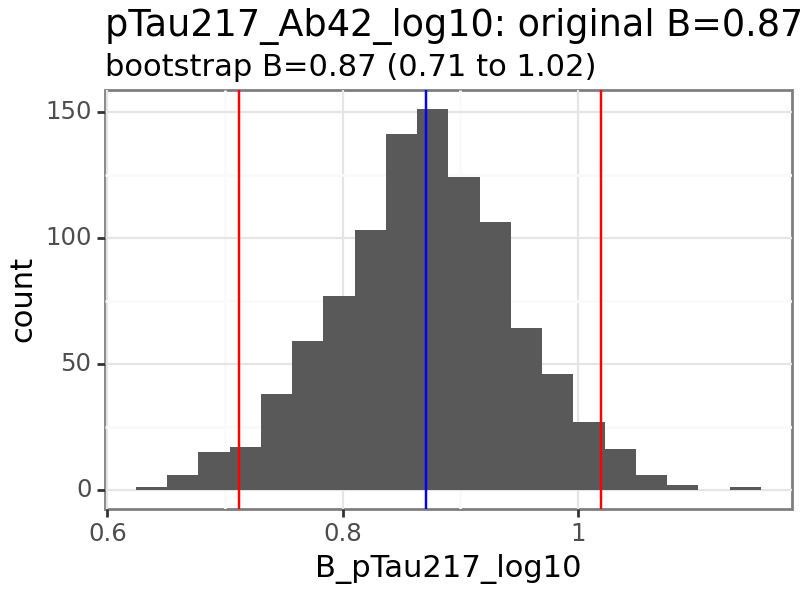

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


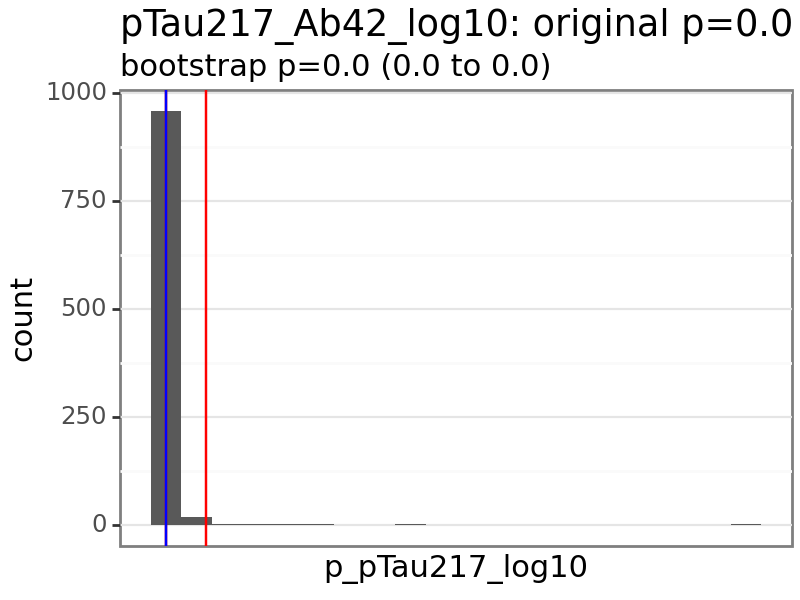

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


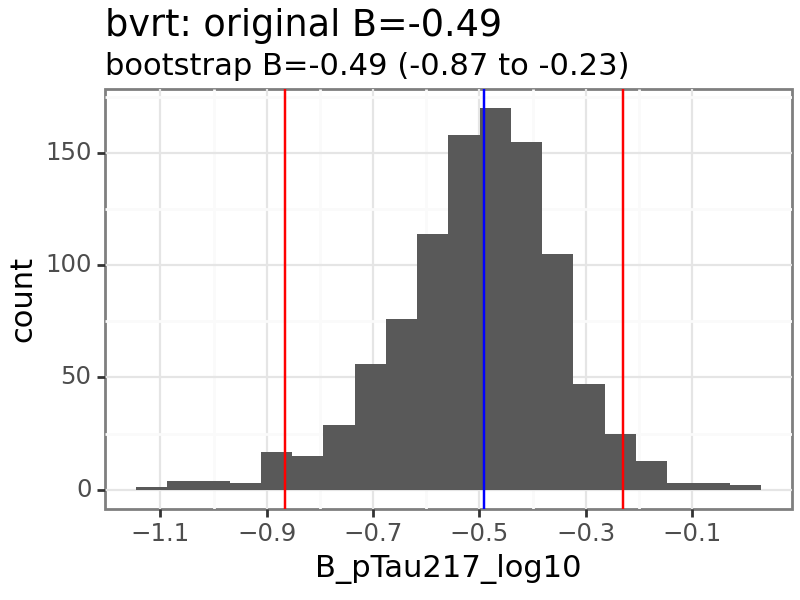

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


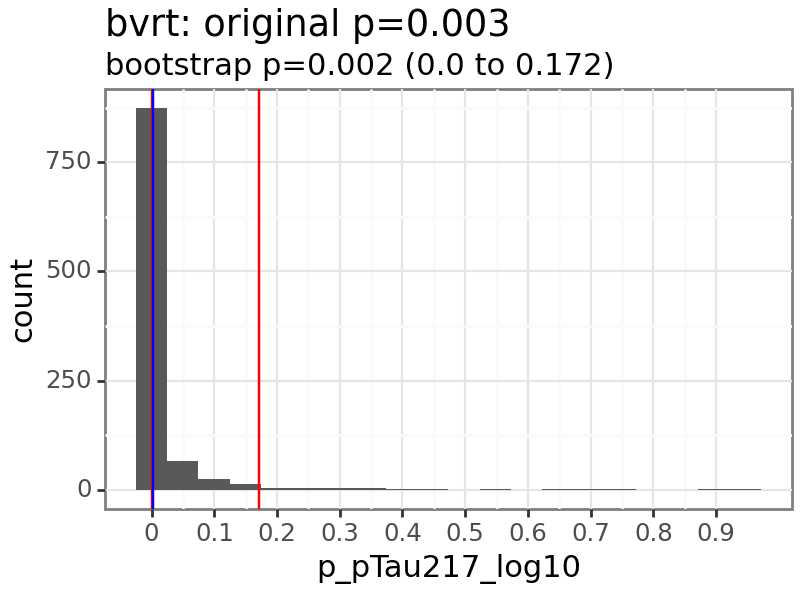

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


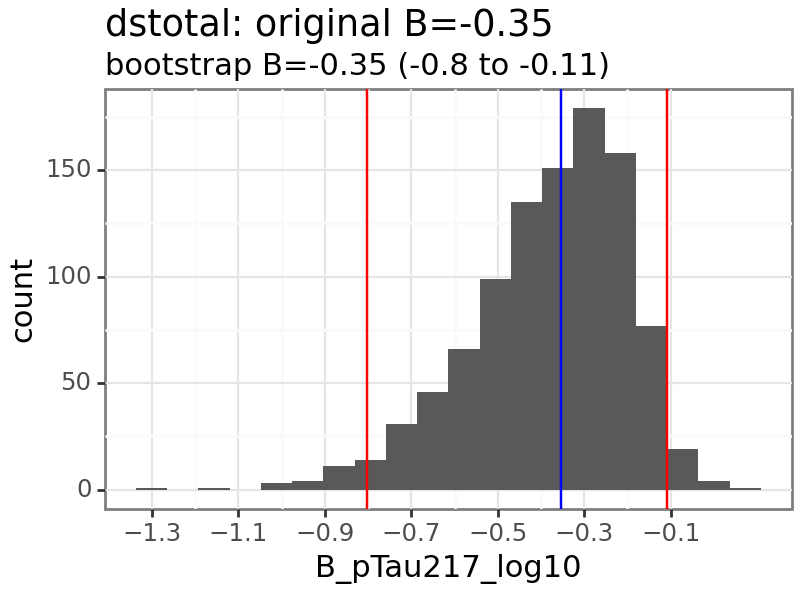

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


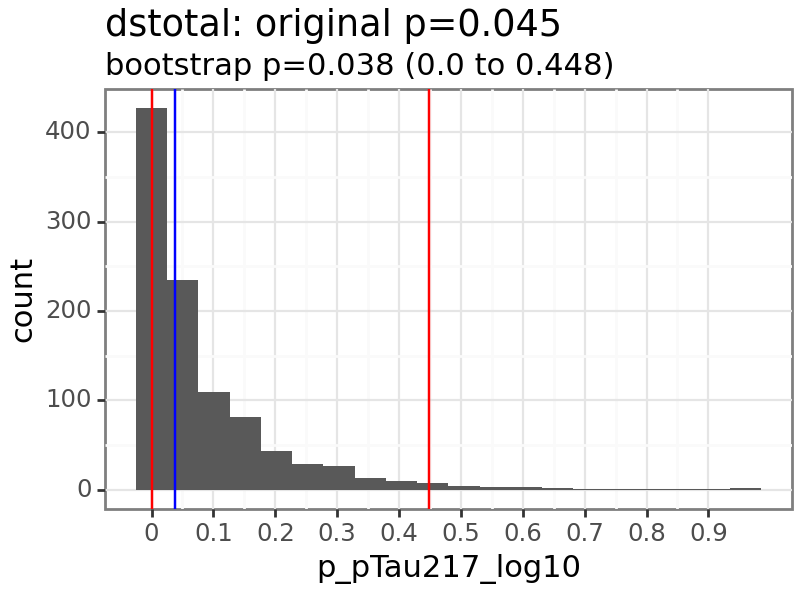

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


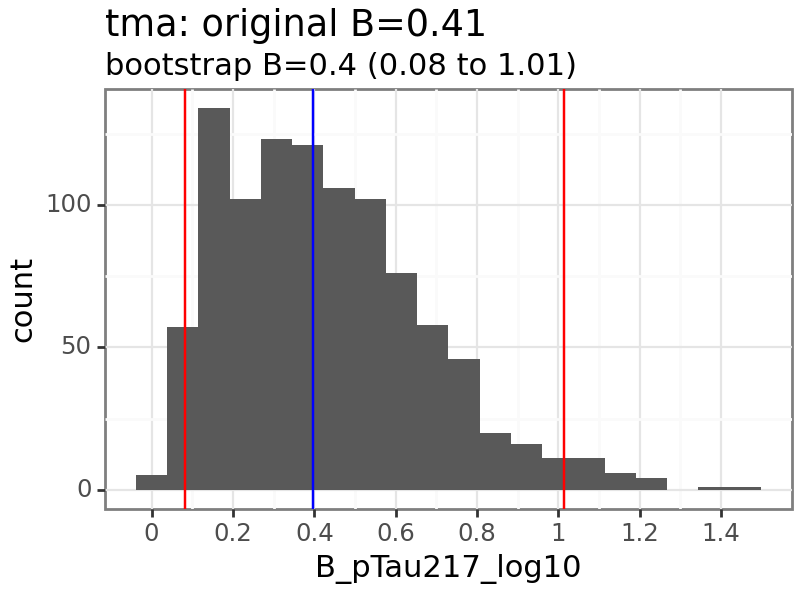

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


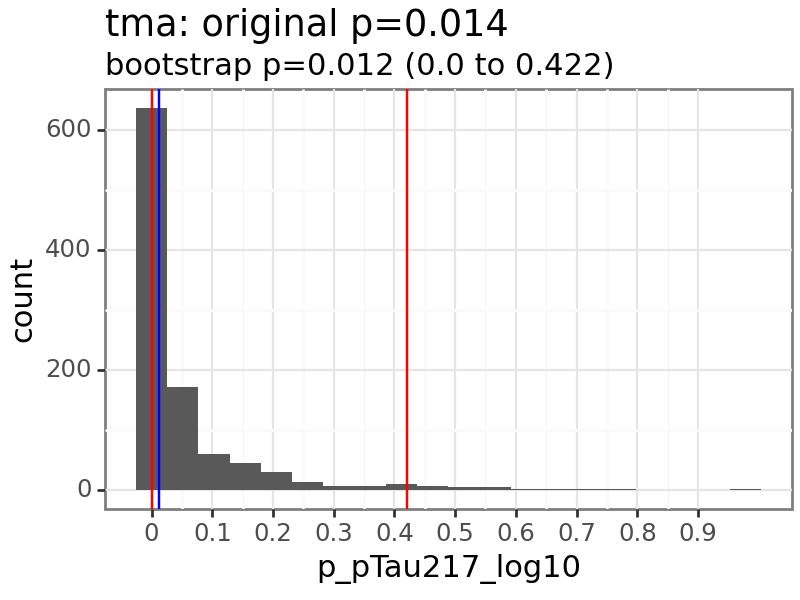

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


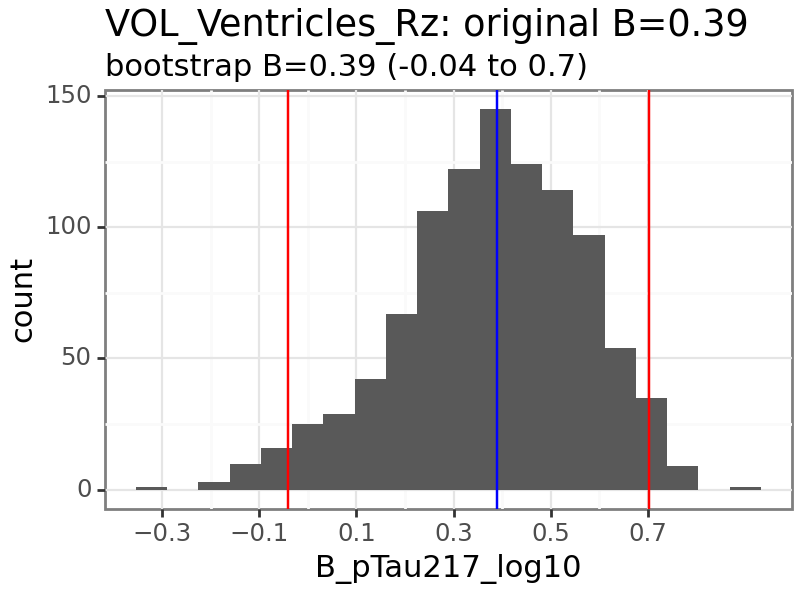

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


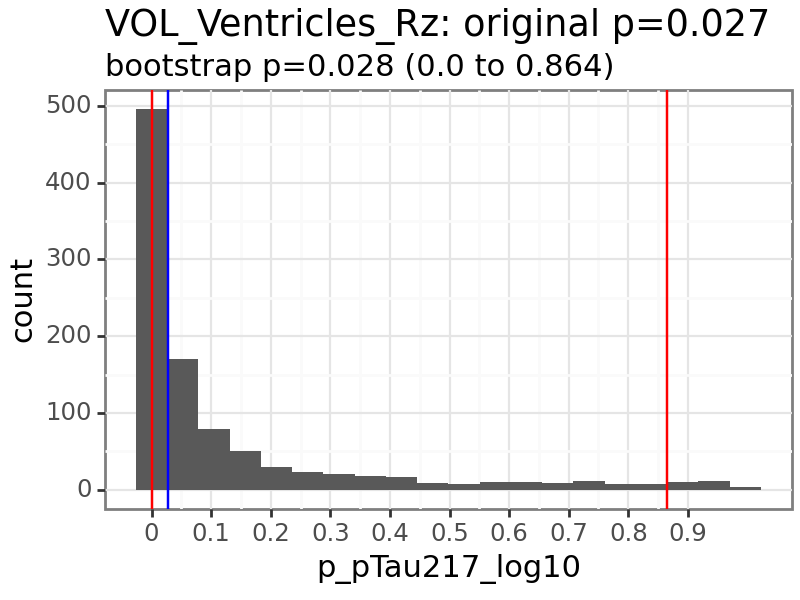

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


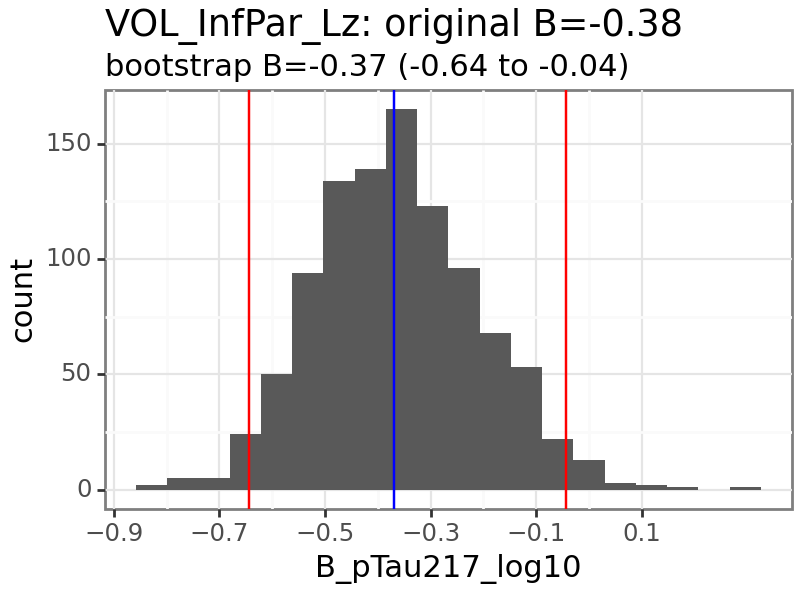

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


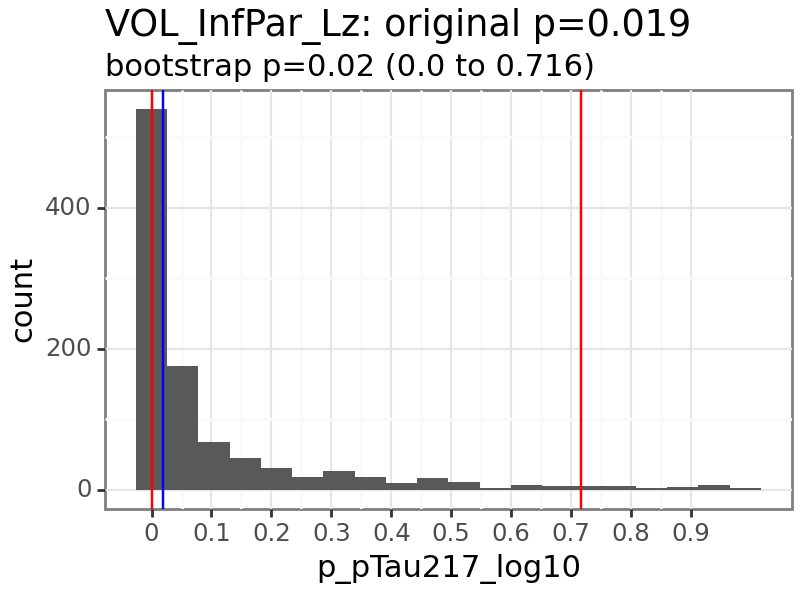

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


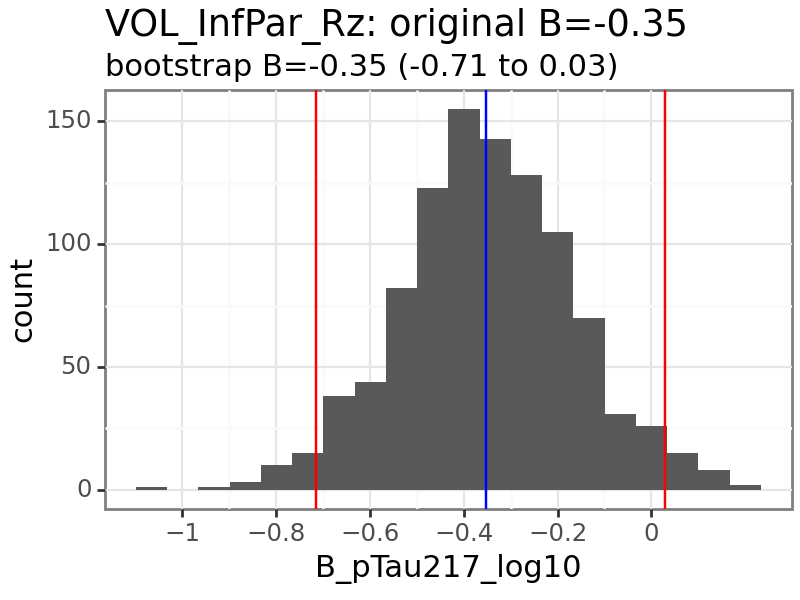

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


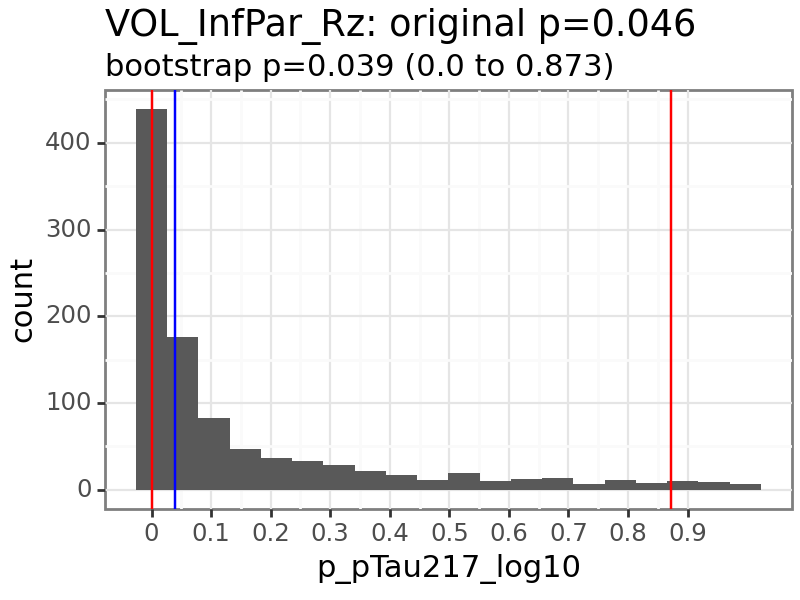

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


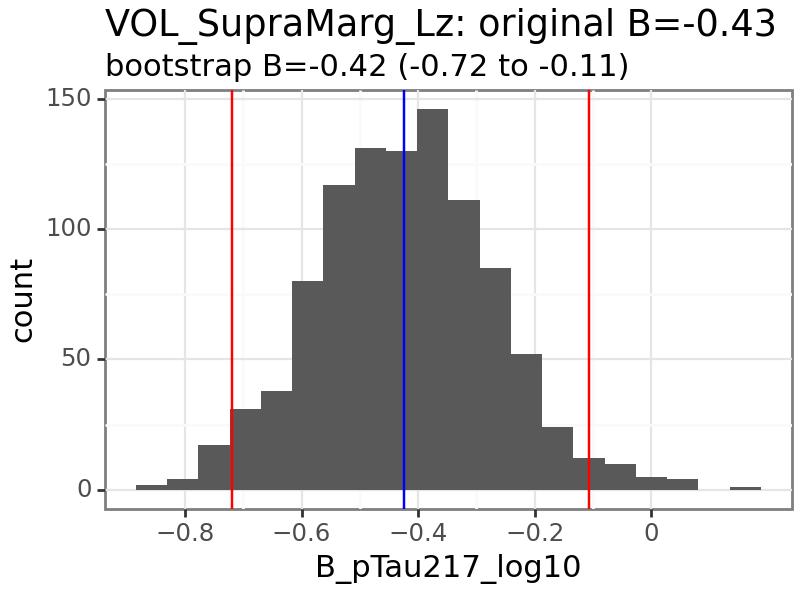

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


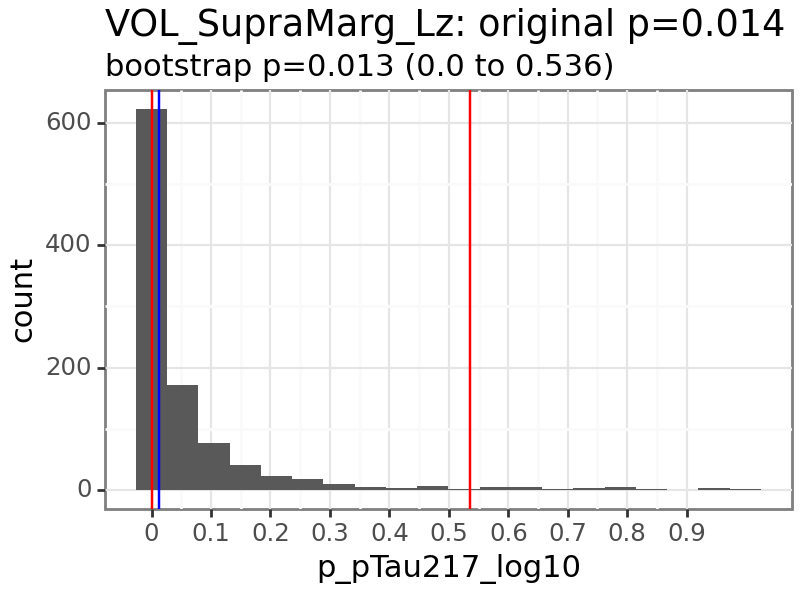

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


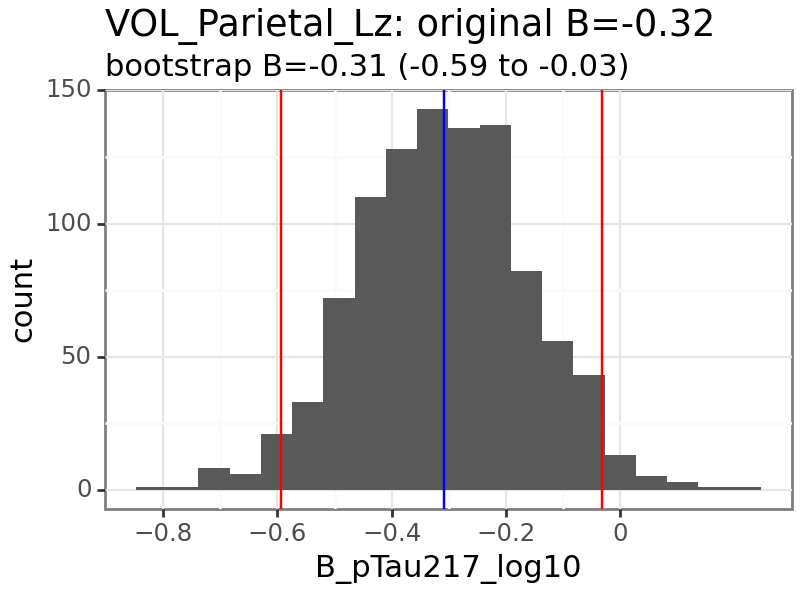

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


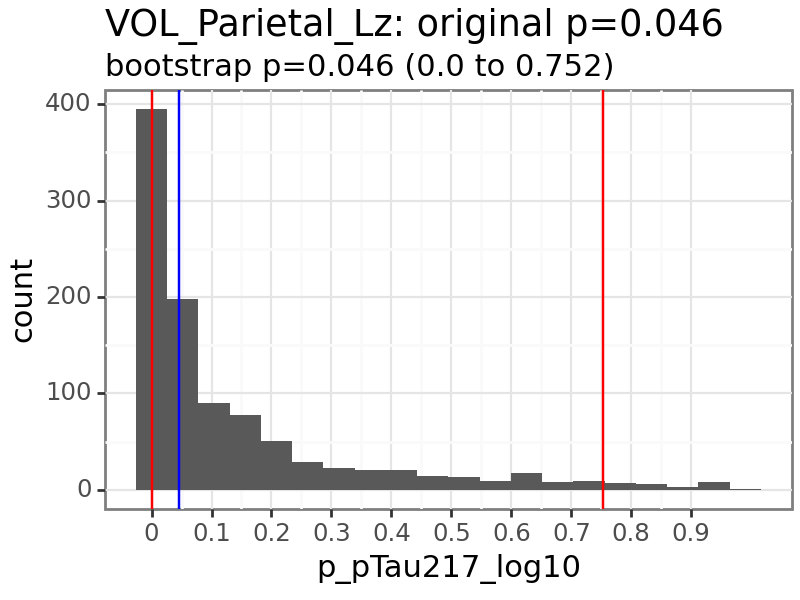

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


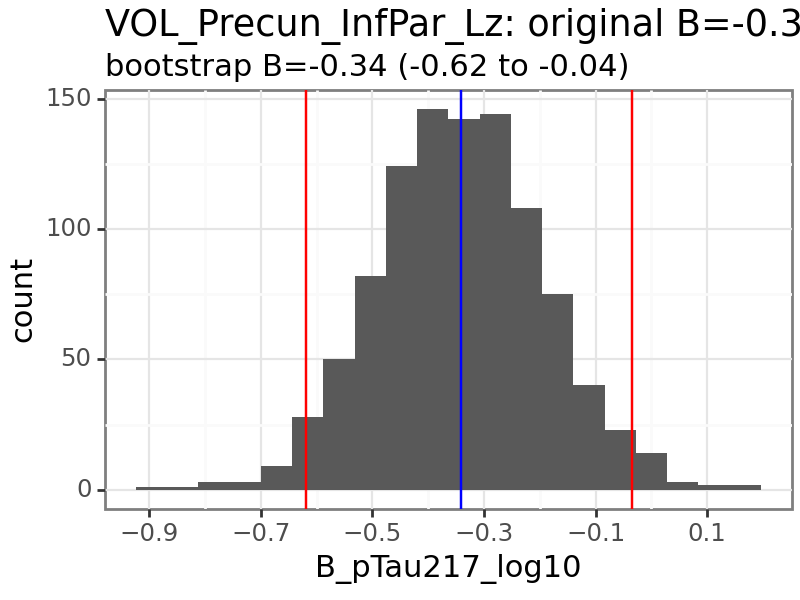

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


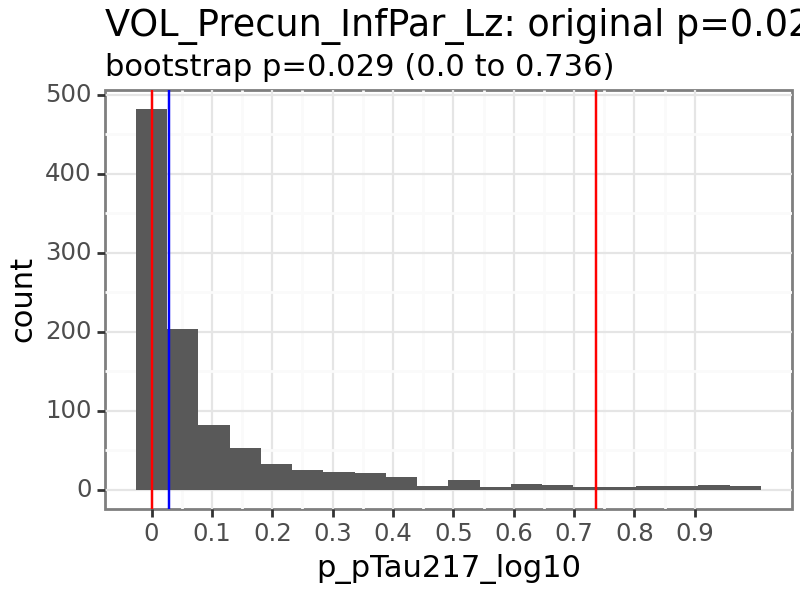

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


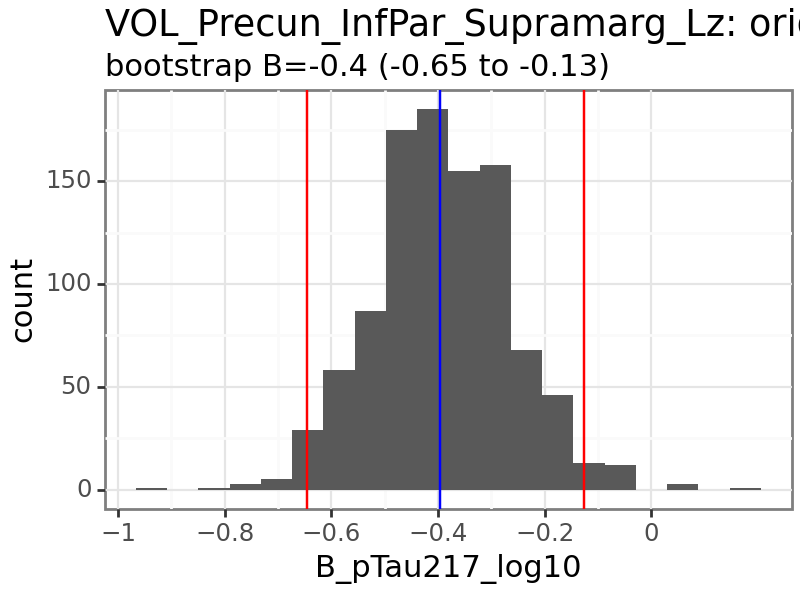

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


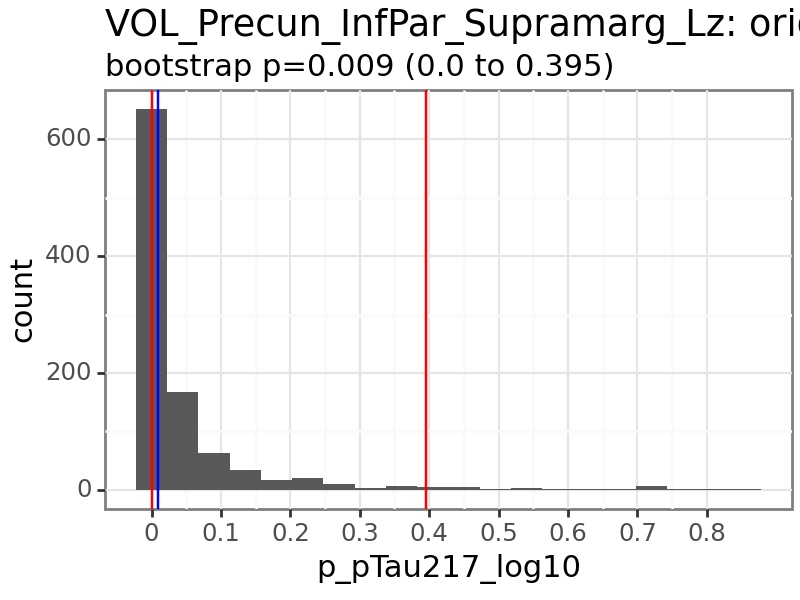

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


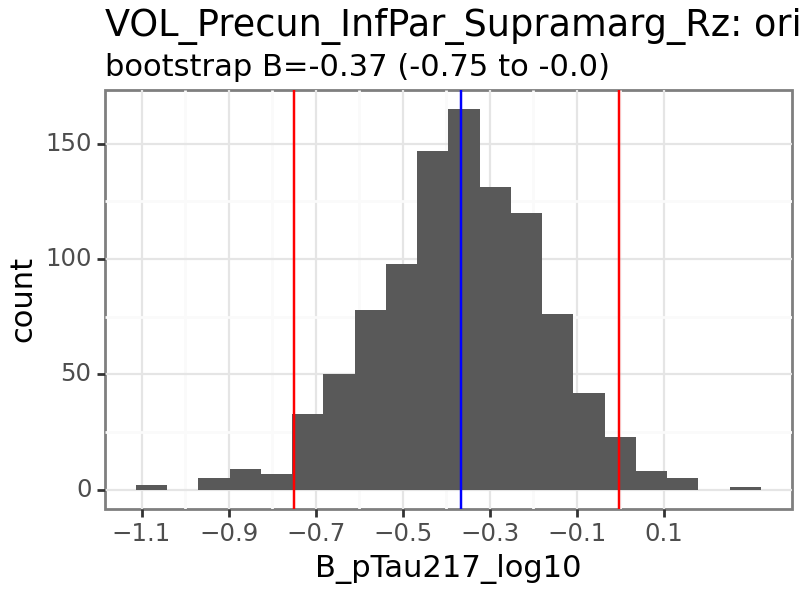

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


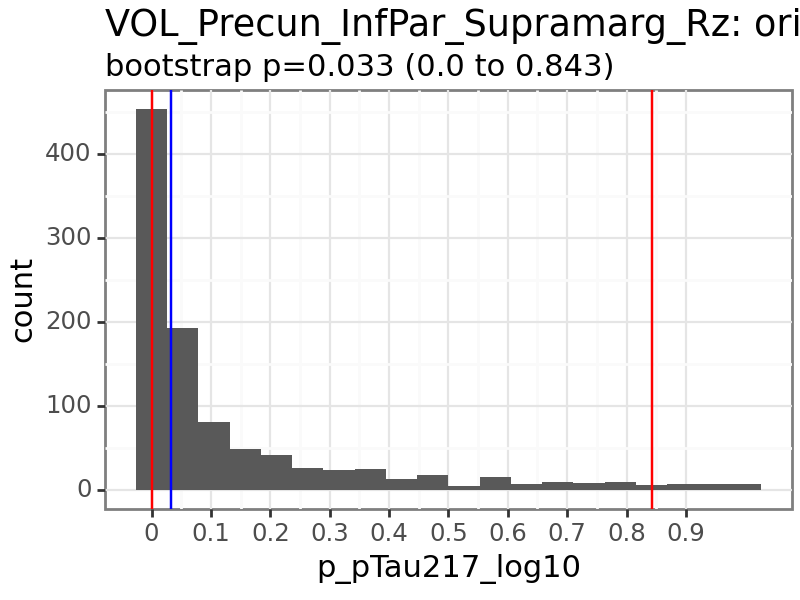

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


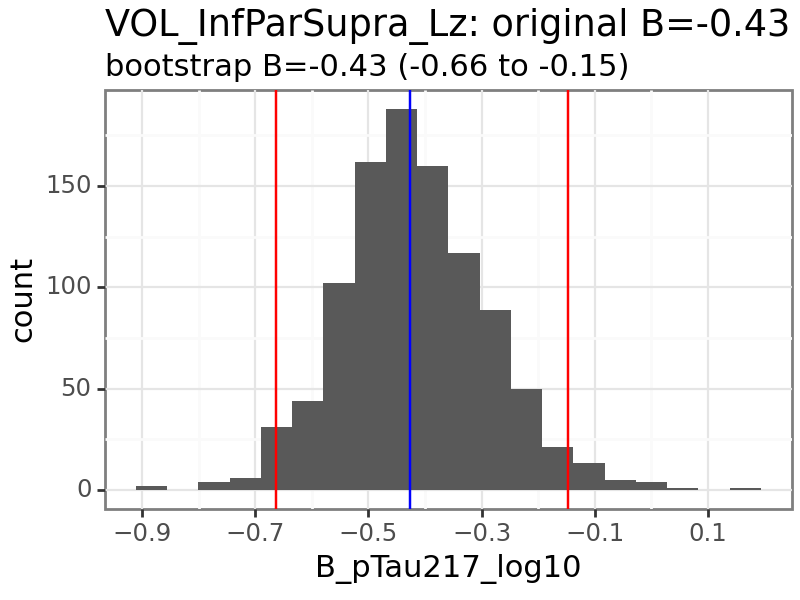

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


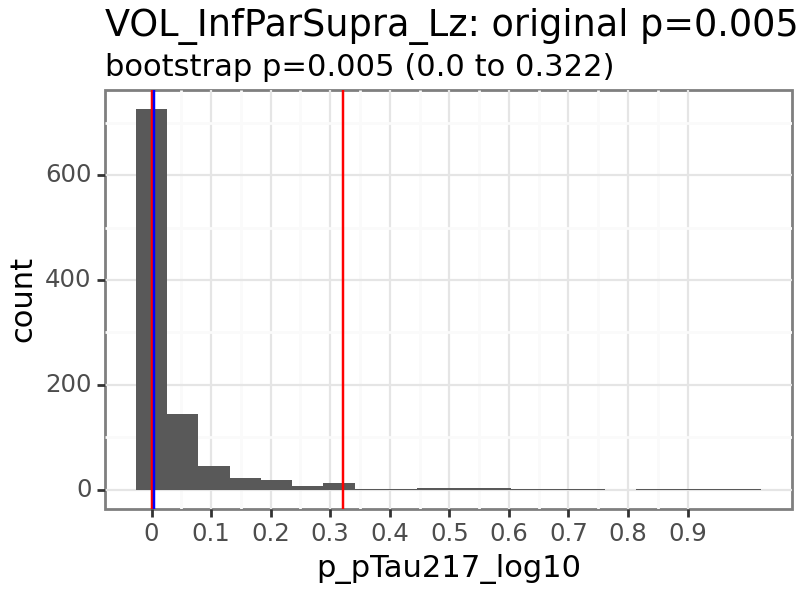

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


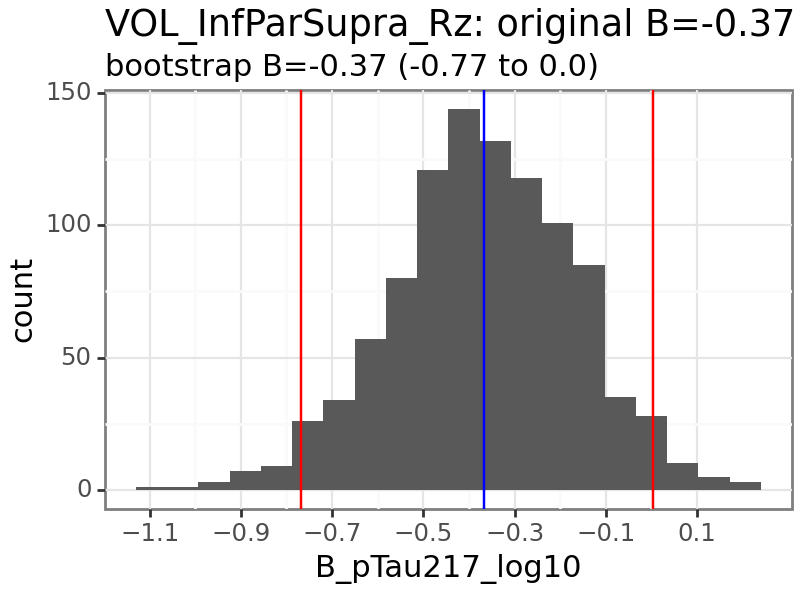

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


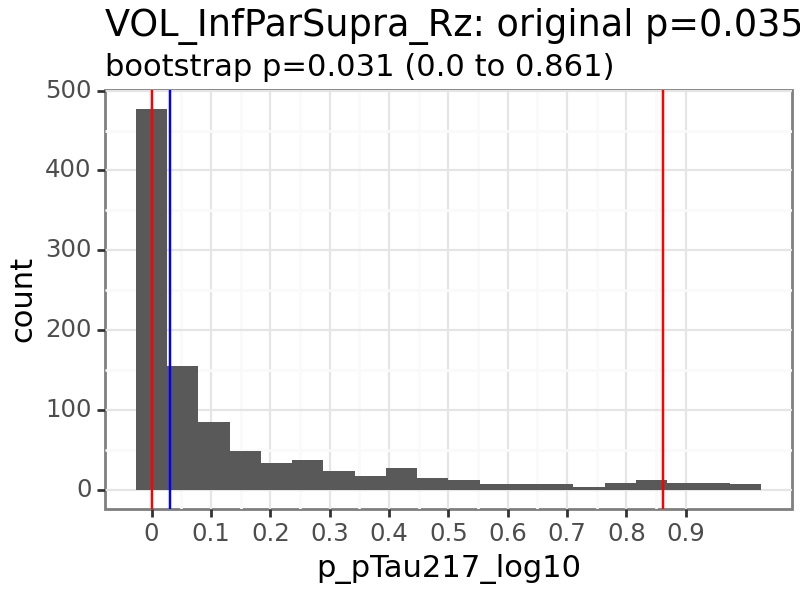

In [17]:
a,  b, c = bootstrap_regression(significant_combos[significant_combos['x_var'].isin(['pTau217_log10'])])
biomarker_relationship_results_log10 = pd.concat([biomarker_relationship_results_log10, a])
biomarker_relationship_results_log10_975 = pd.concat([biomarker_relationship_results_log10_975, b])
biomarker_relationship_results_log10_025 = pd.concat([biomarker_relationship_results_log10_025, c])

# pTau181 bootstrapping

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


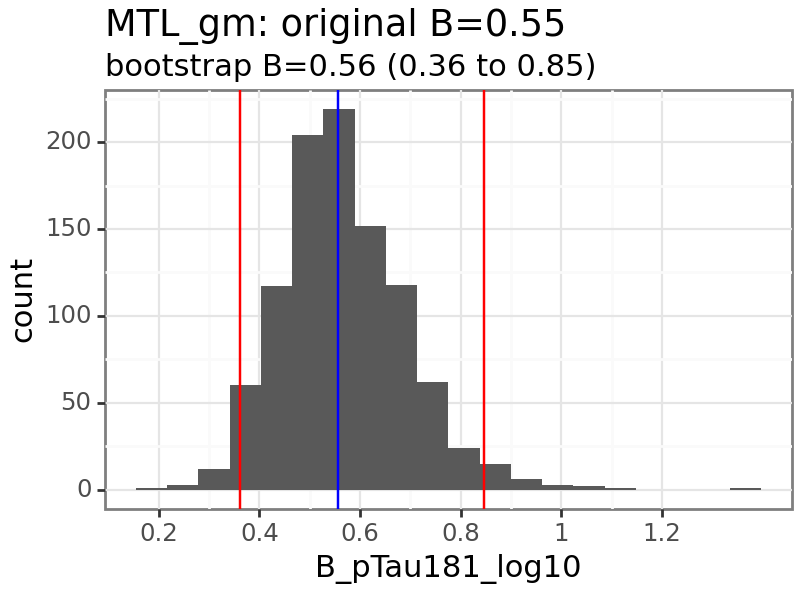

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


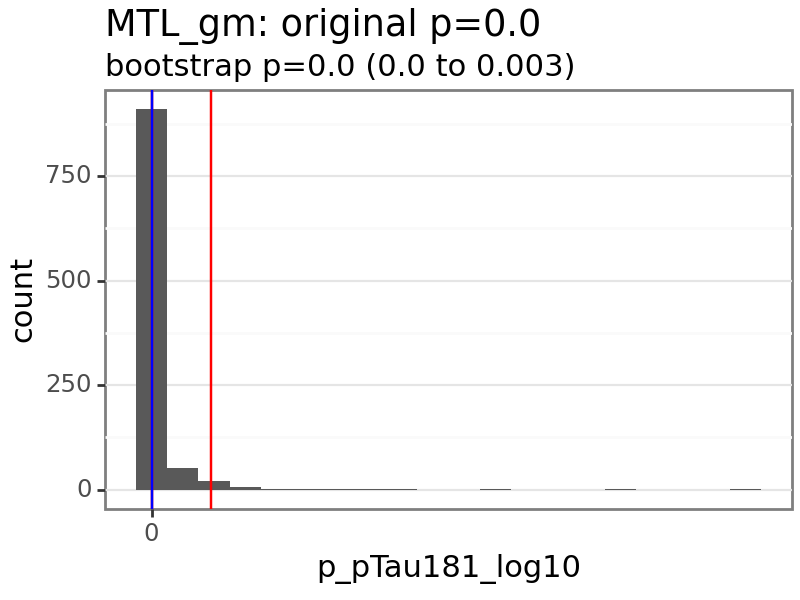

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


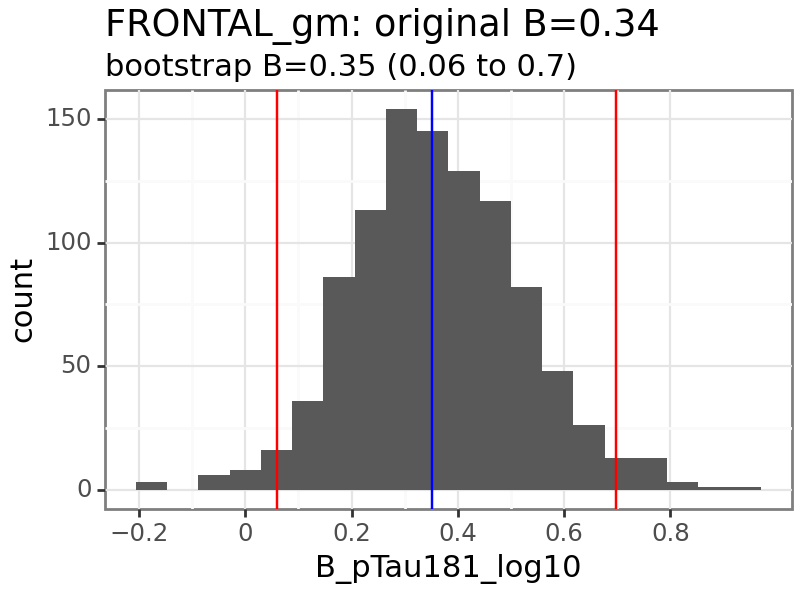

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


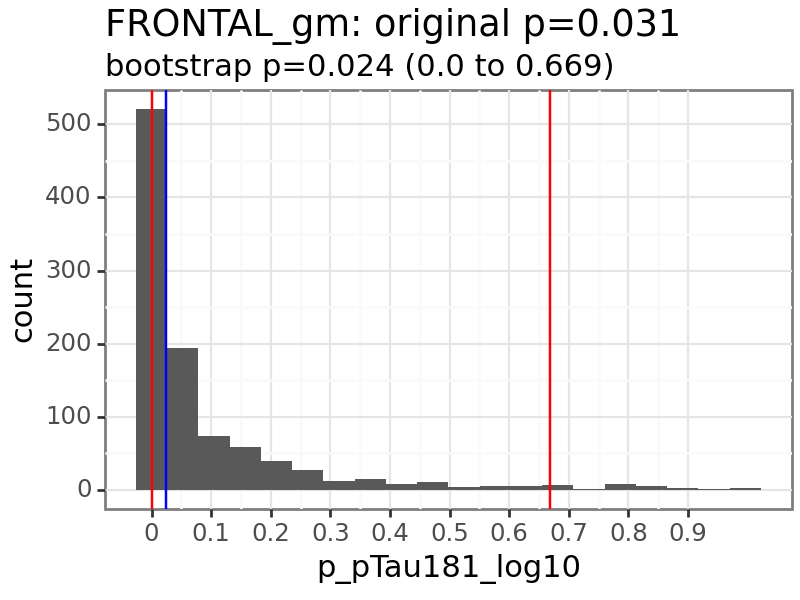

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


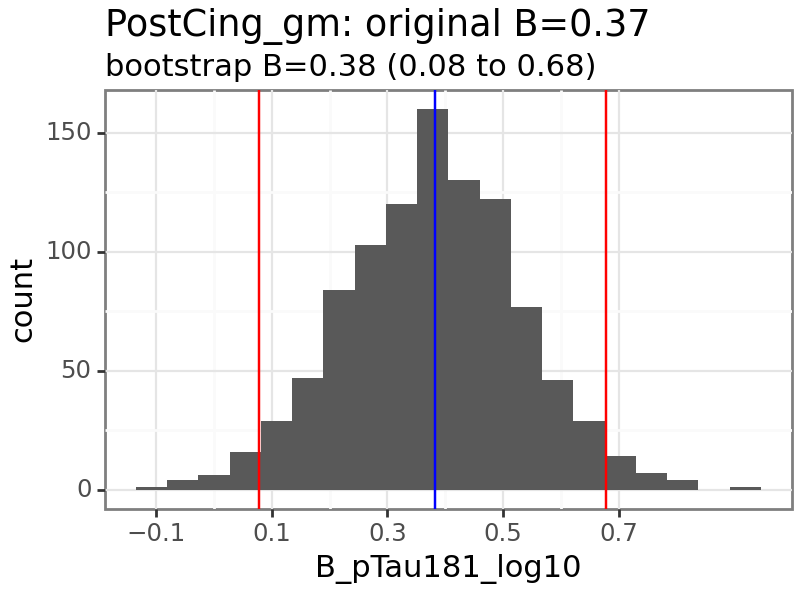

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


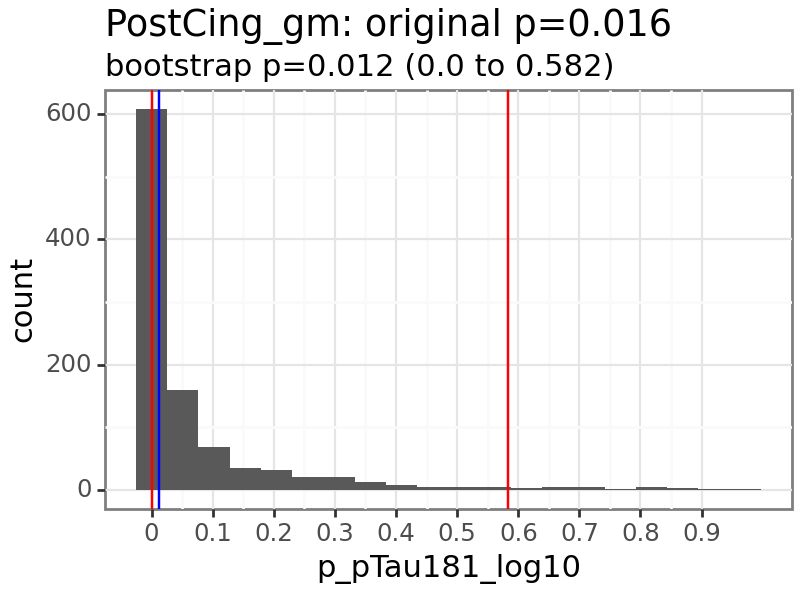

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


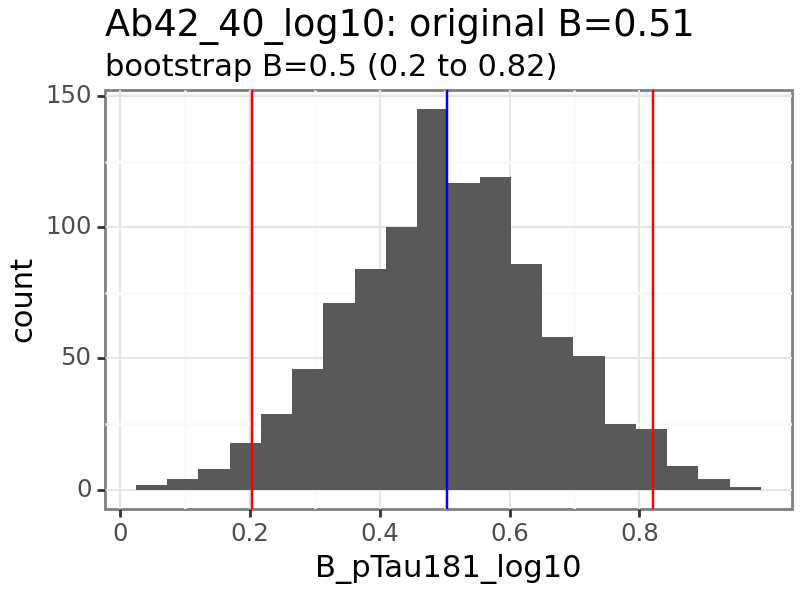

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


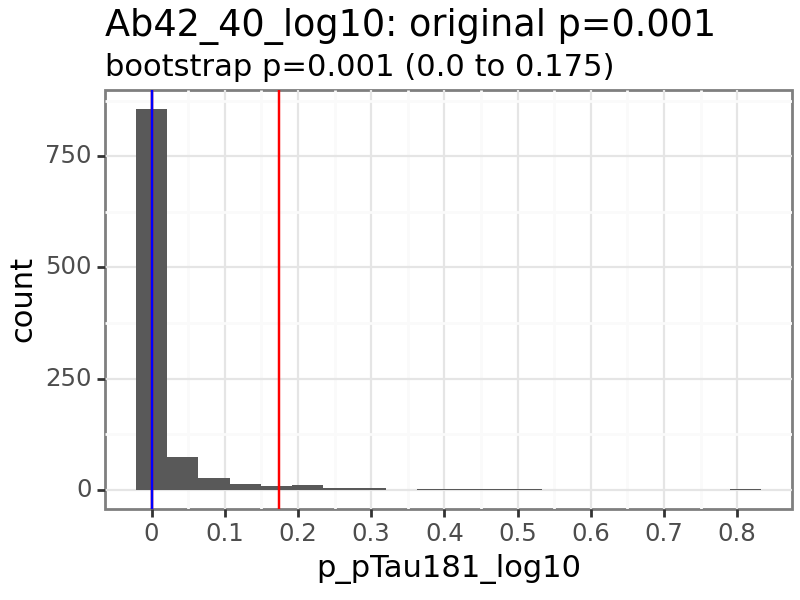

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


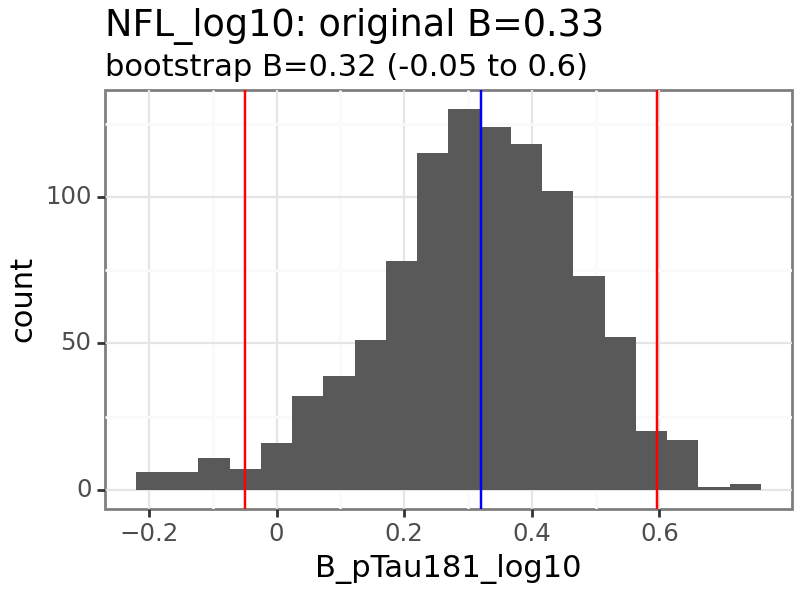

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


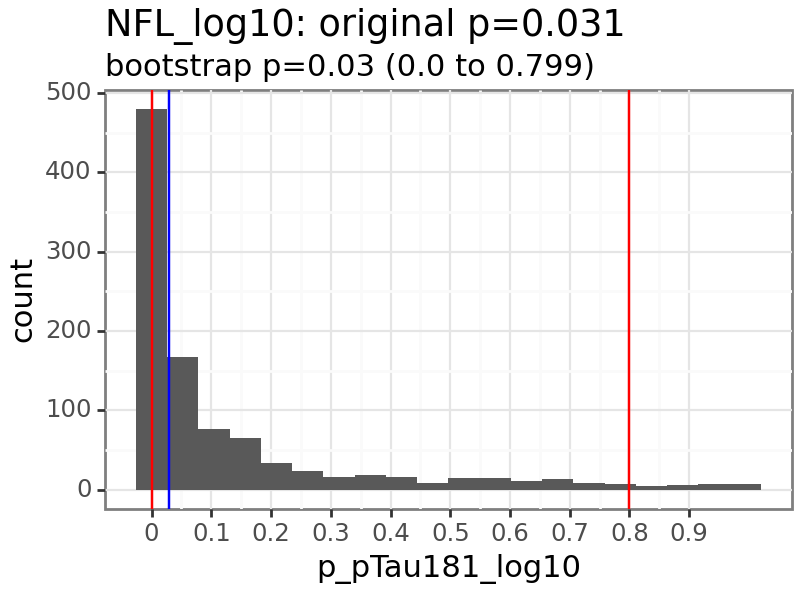

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


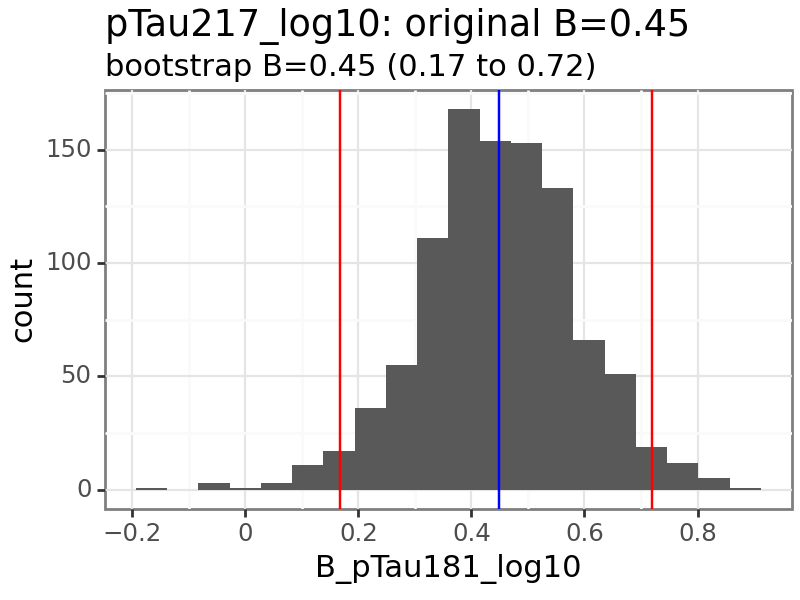

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


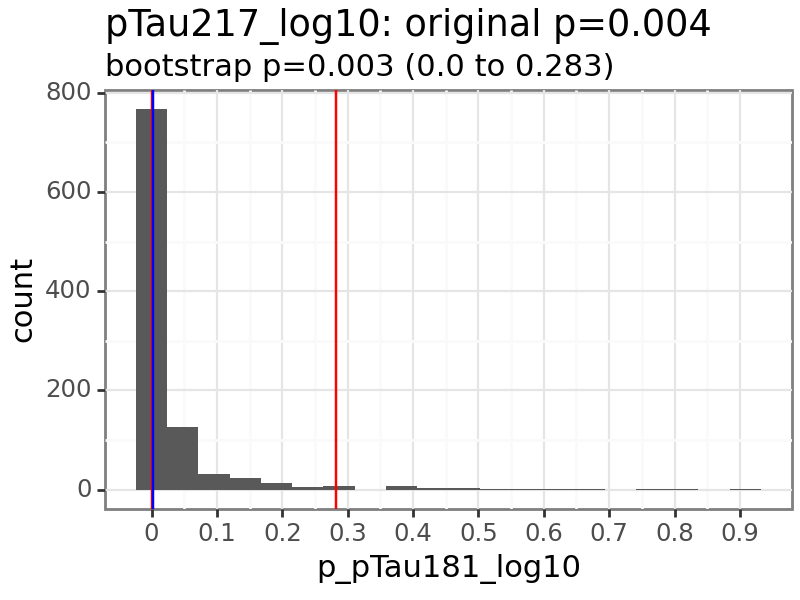

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


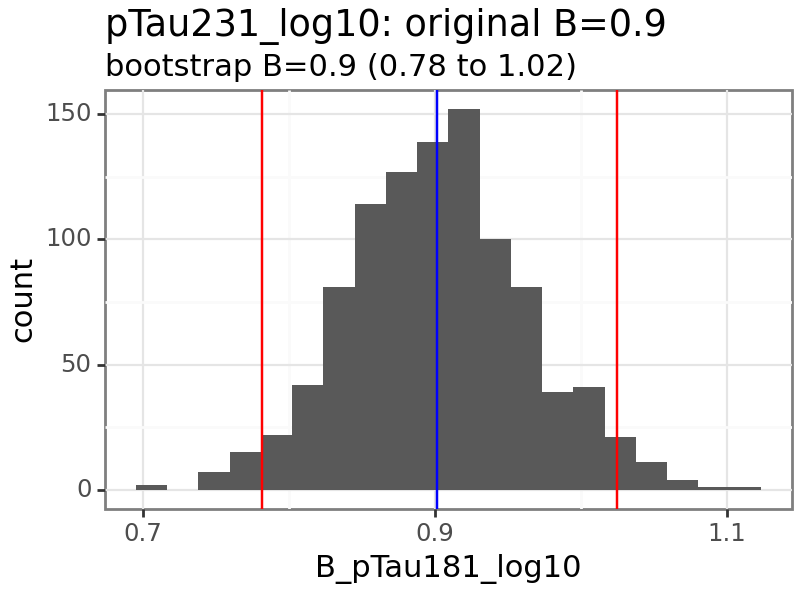

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


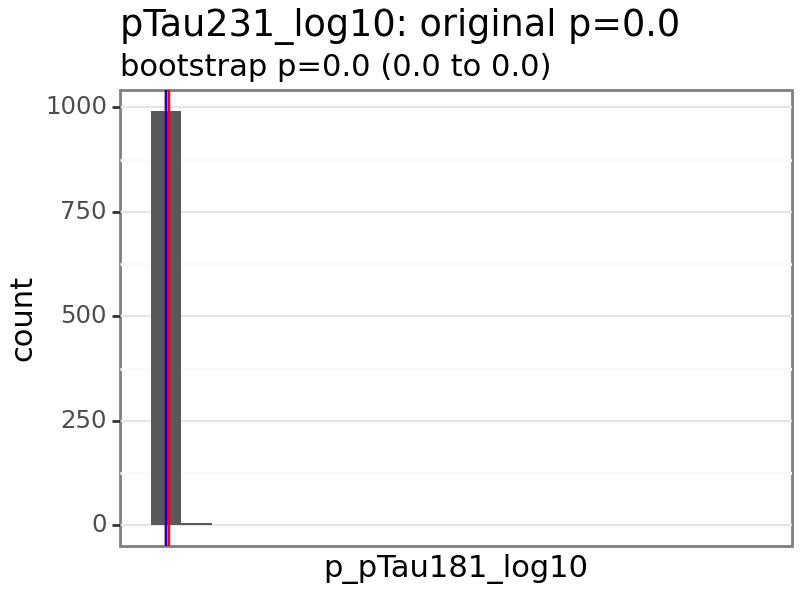

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


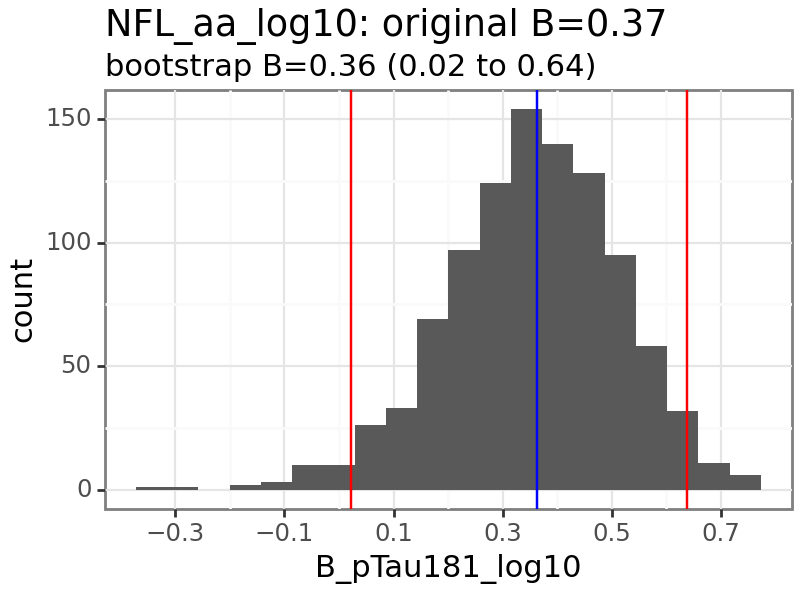

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


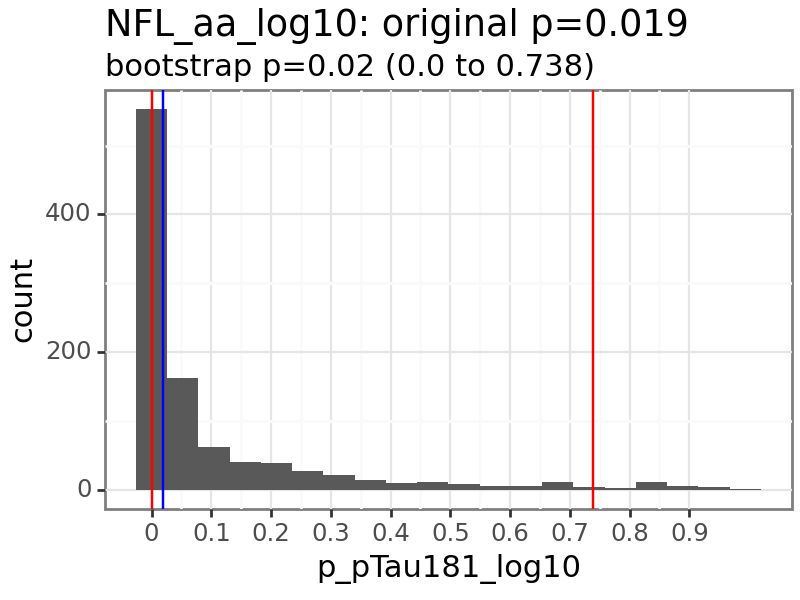

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


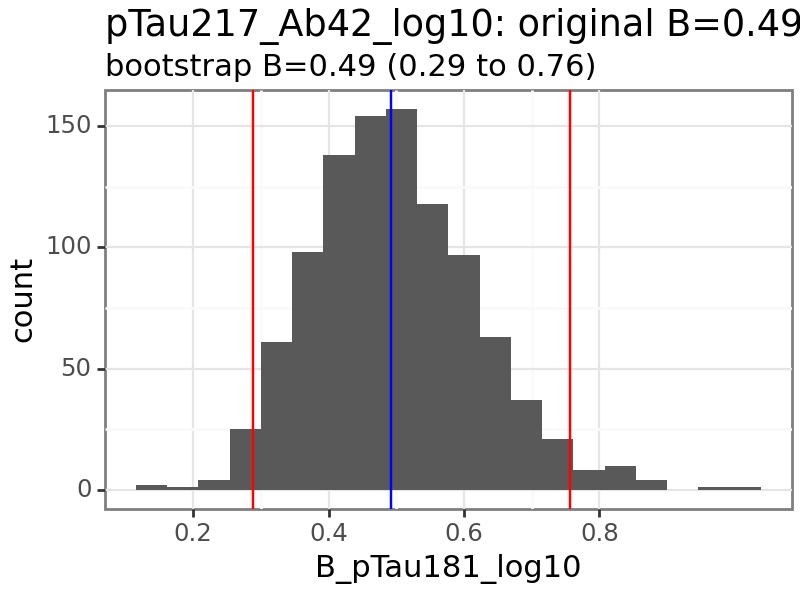

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


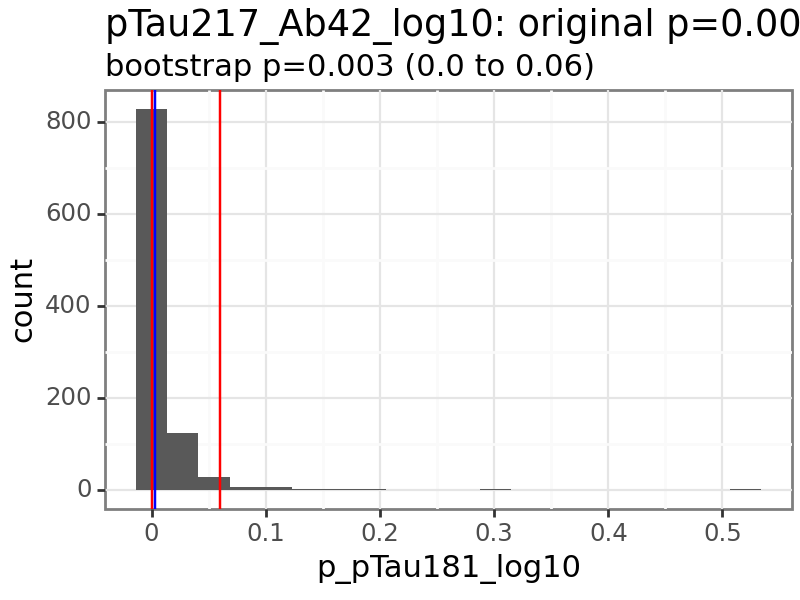

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


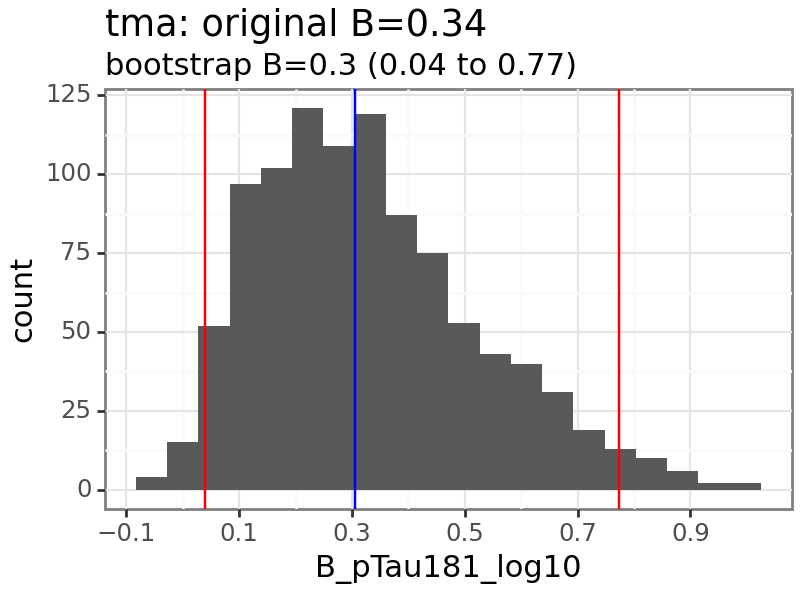

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


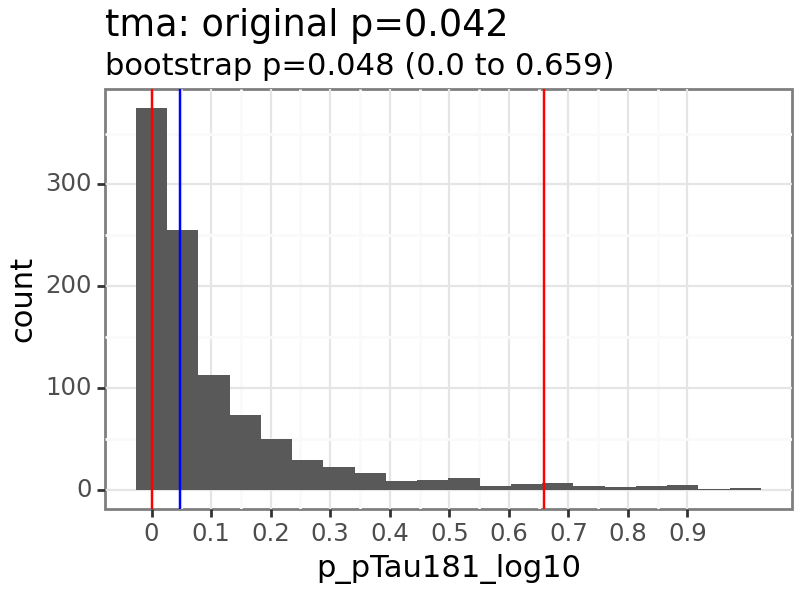

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


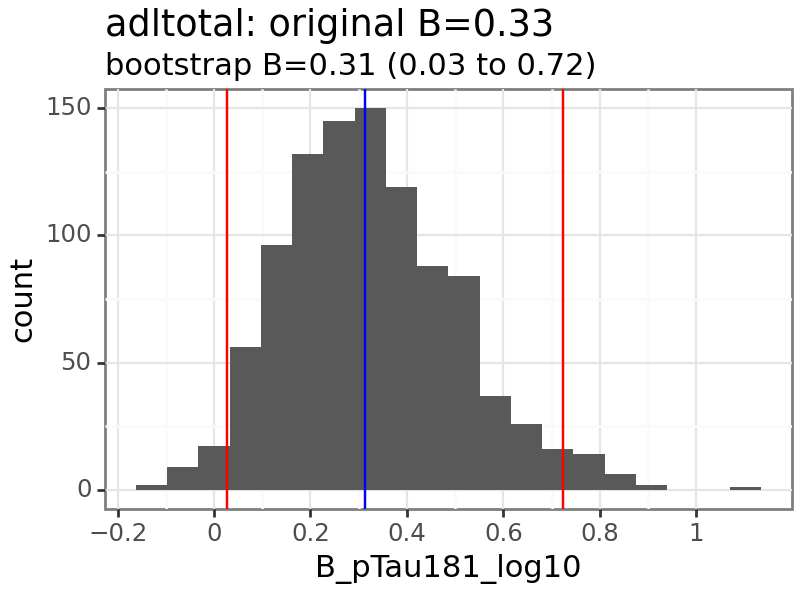

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


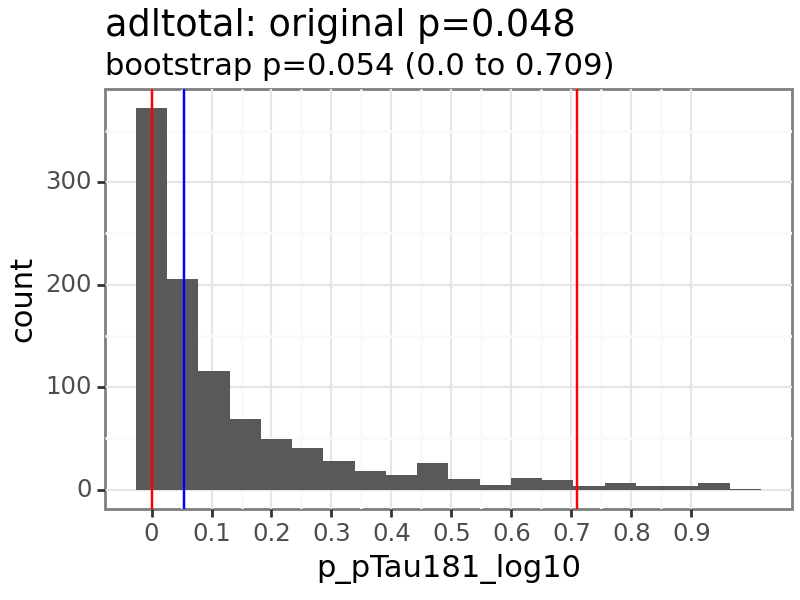

In [18]:
a,  b, c = bootstrap_regression(significant_combos[significant_combos['x_var'].isin(['pTau181_log10'])])
biomarker_relationship_results_log10 = pd.concat([biomarker_relationship_results_log10, a])
biomarker_relationship_results_log10_975 = pd.concat([biomarker_relationship_results_log10_975, b])
biomarker_relationship_results_log10_025 = pd.concat([biomarker_relationship_results_log10_025, c])

# pTau231 bootstrapping

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


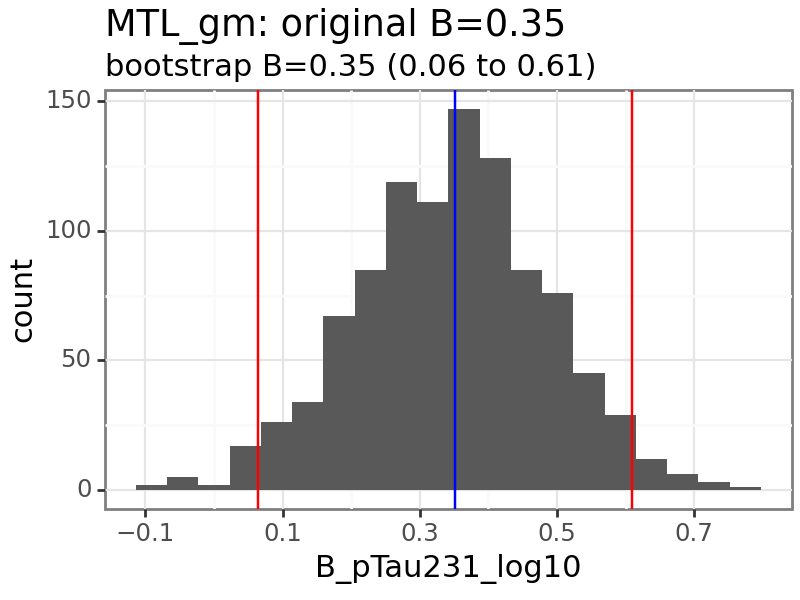

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


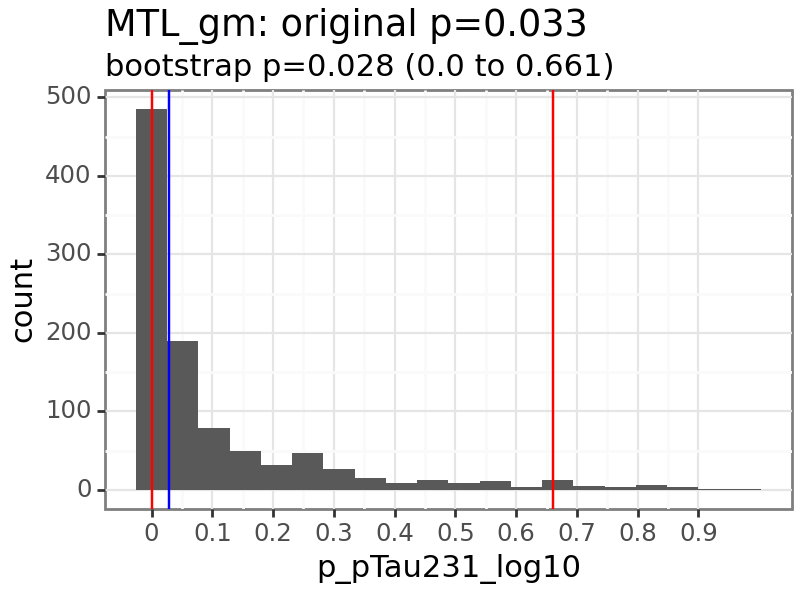

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


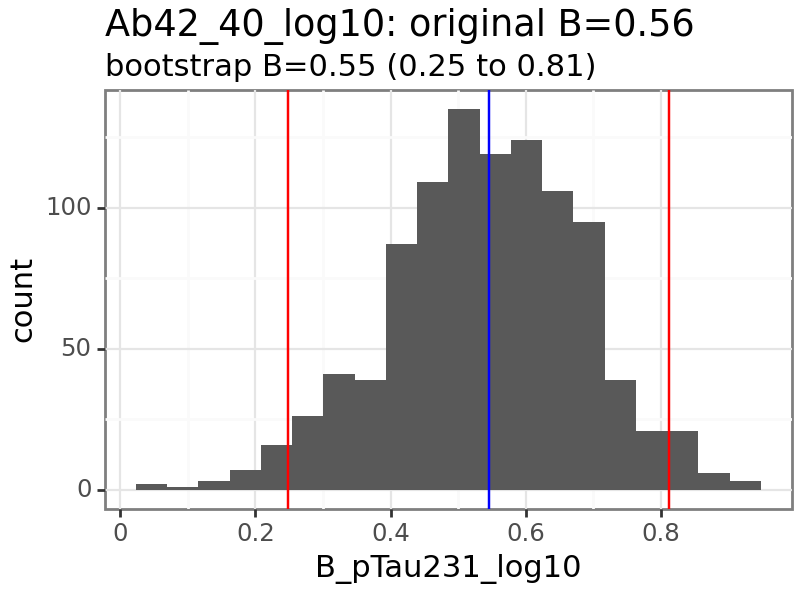

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


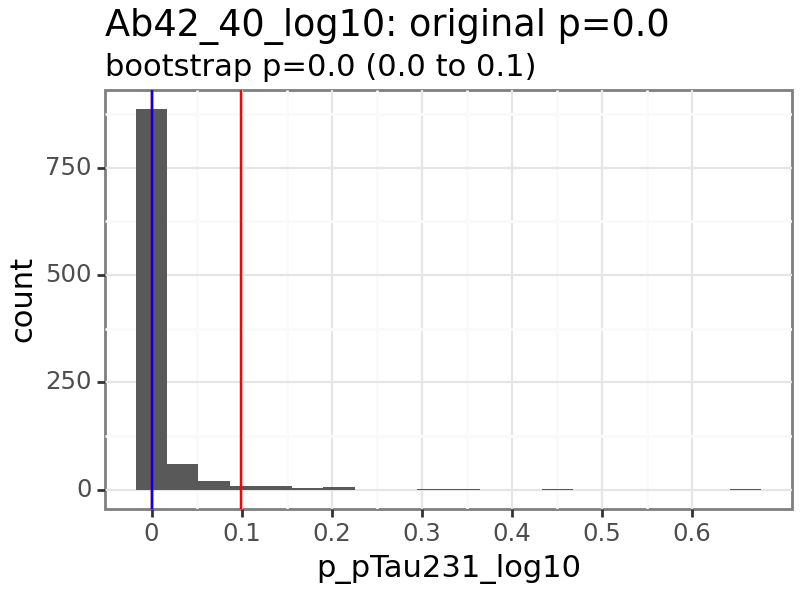

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


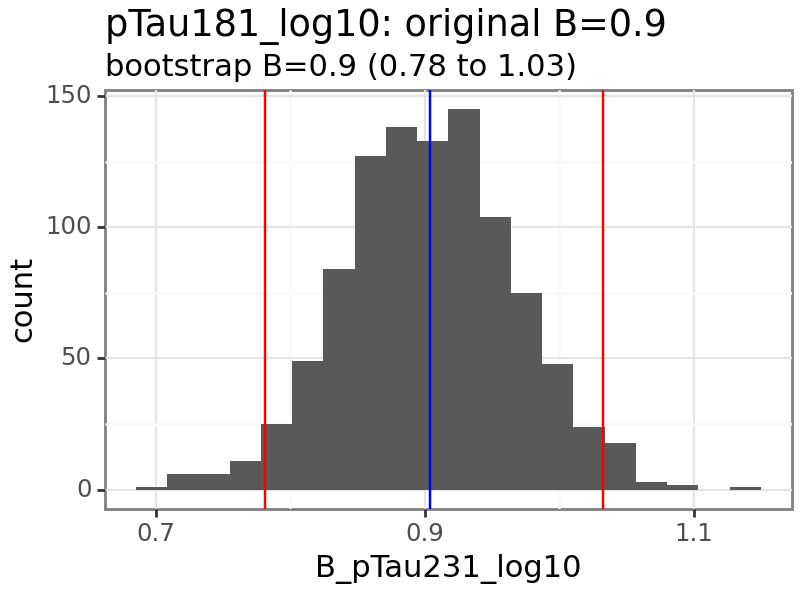

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


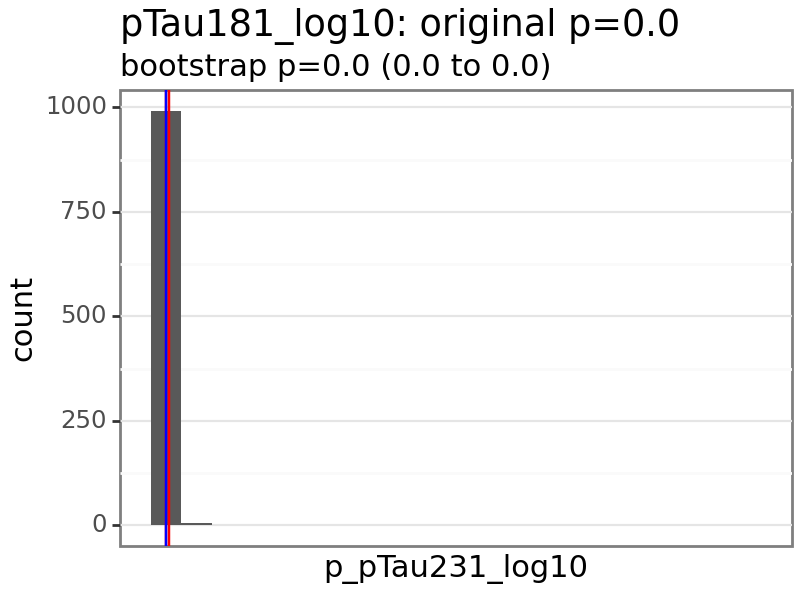

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


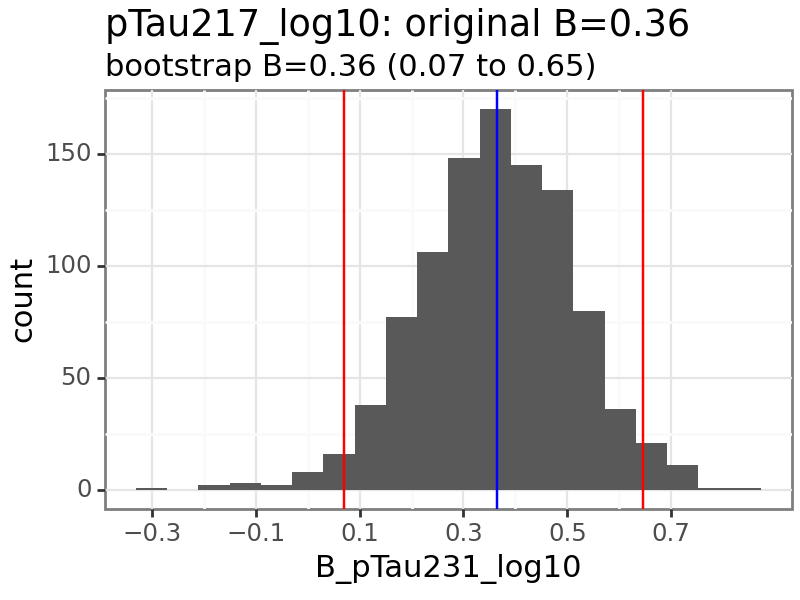

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


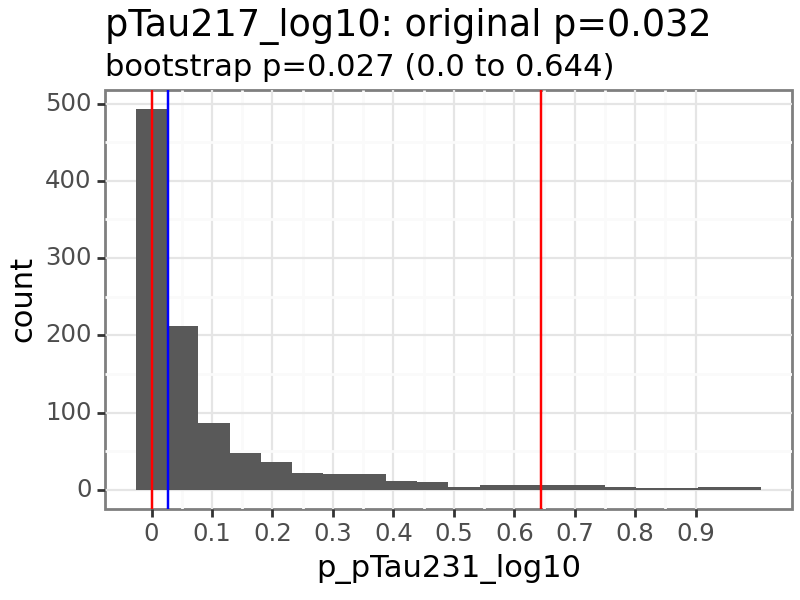

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


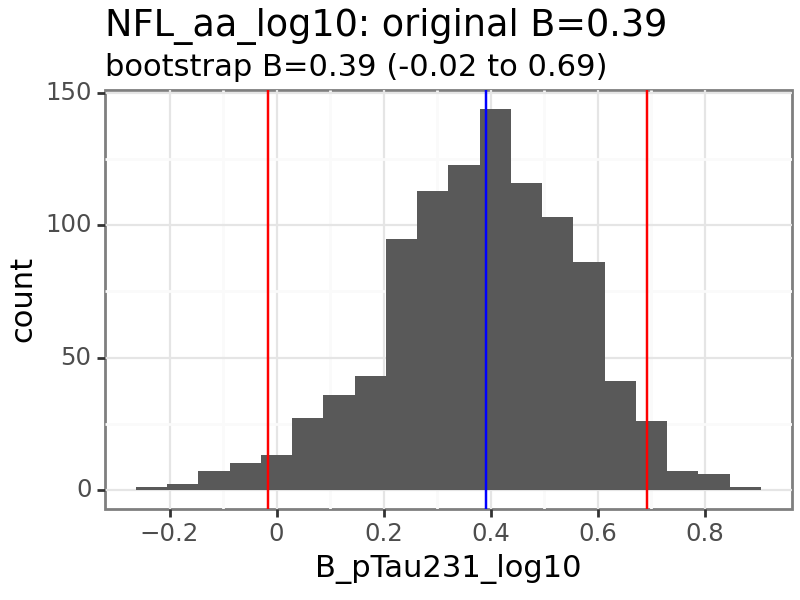

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


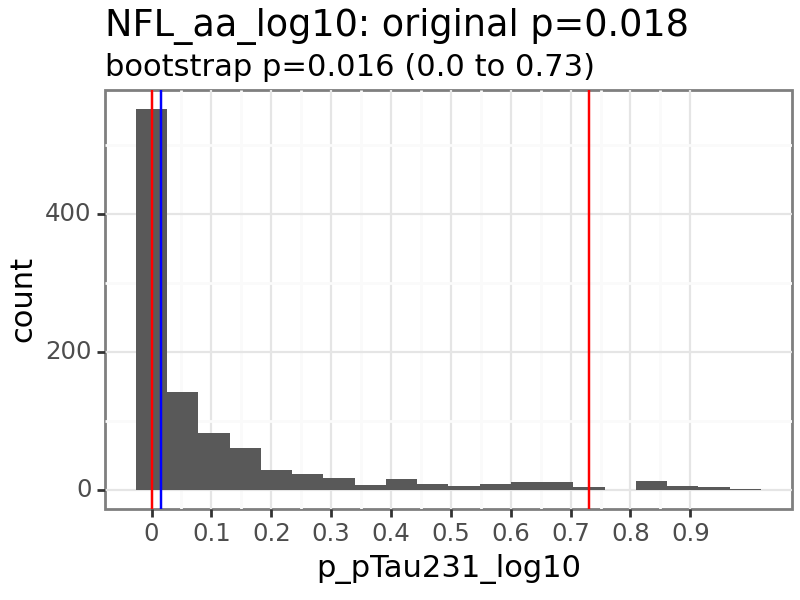

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


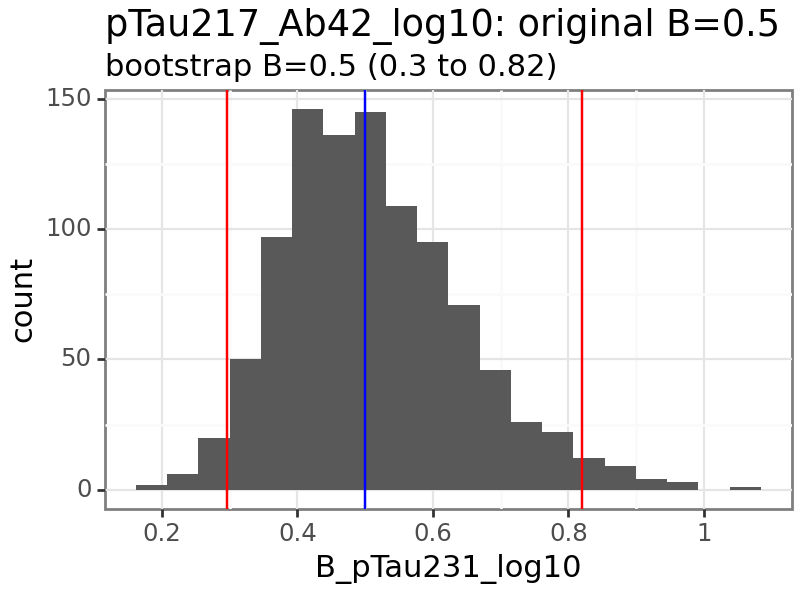

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


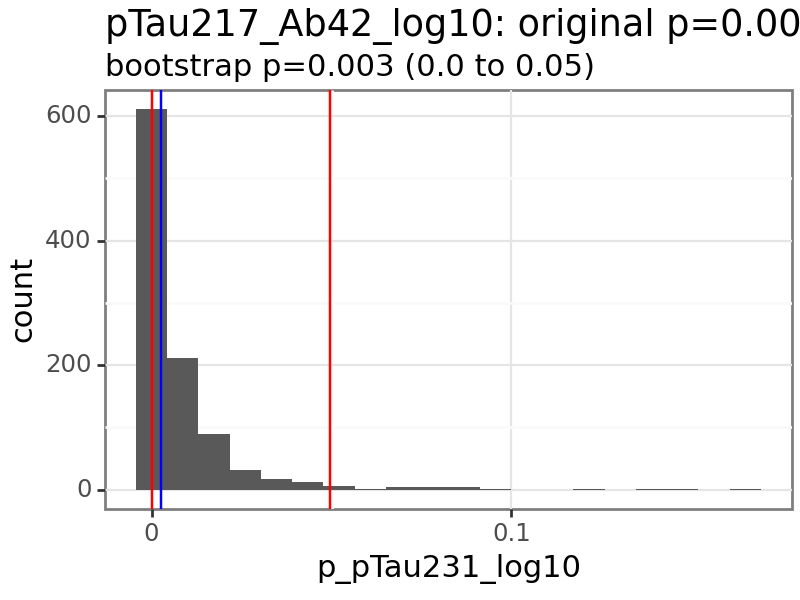

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


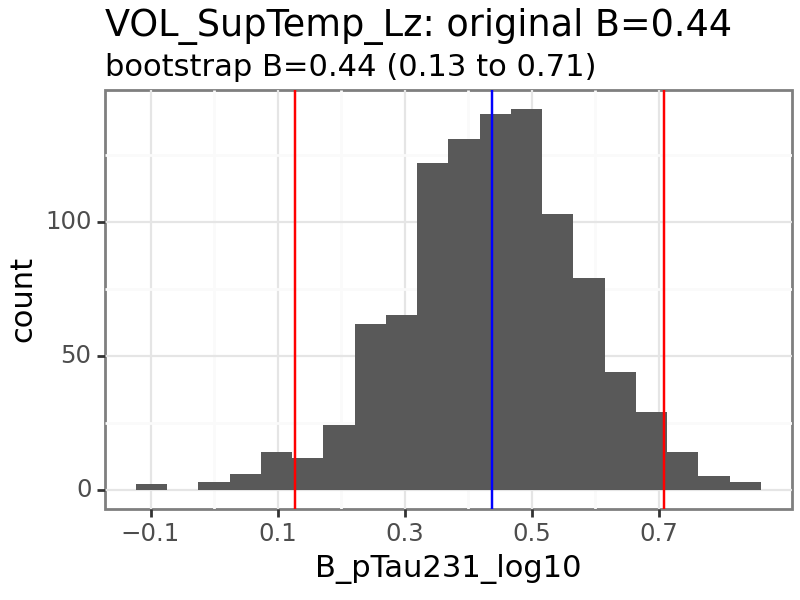

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


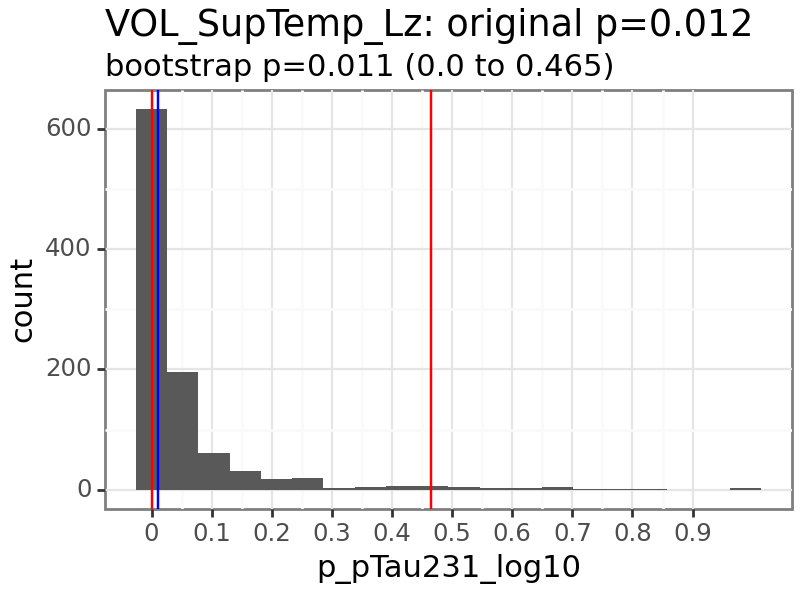

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


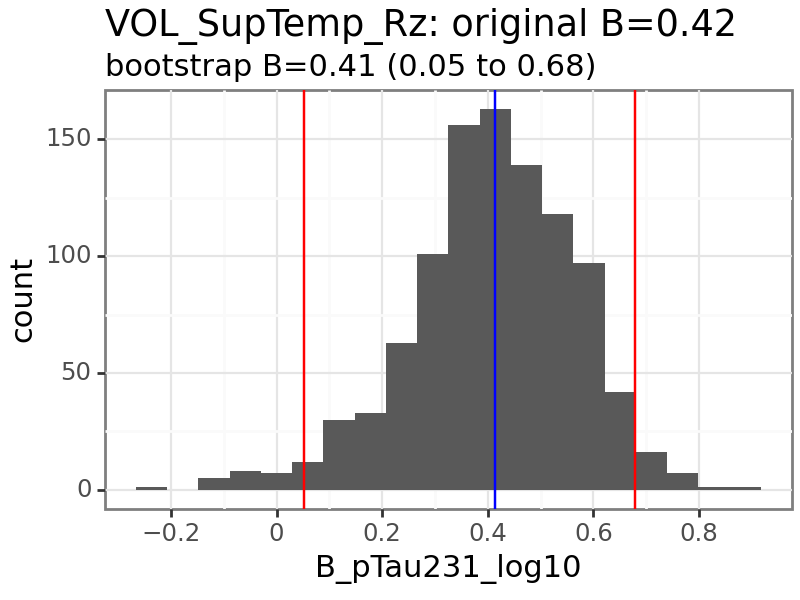

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


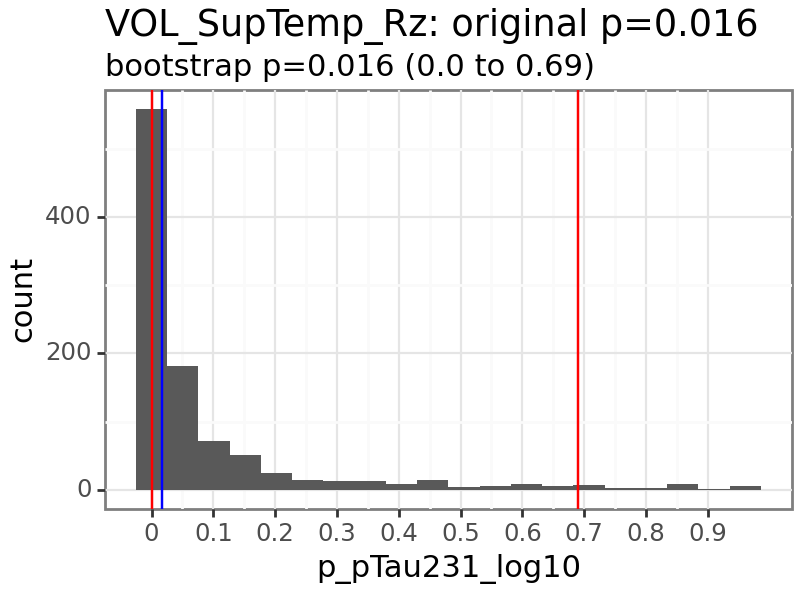

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


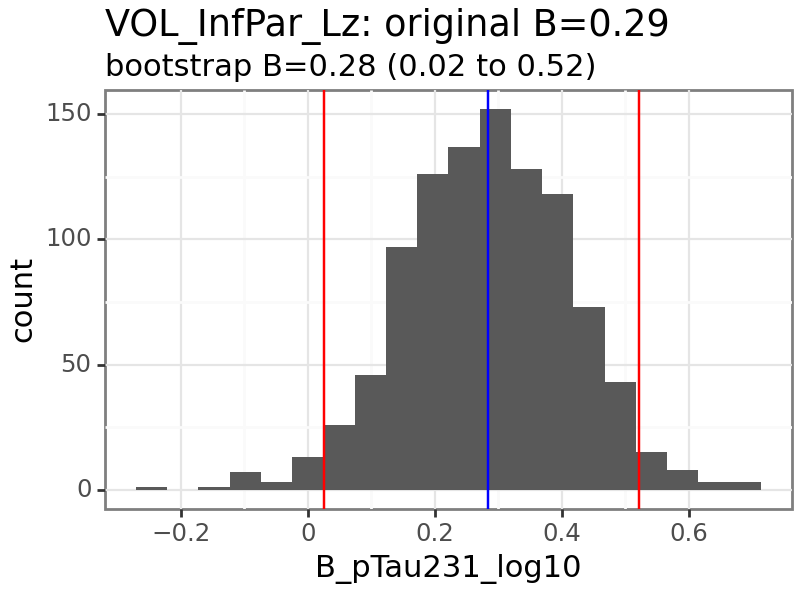

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


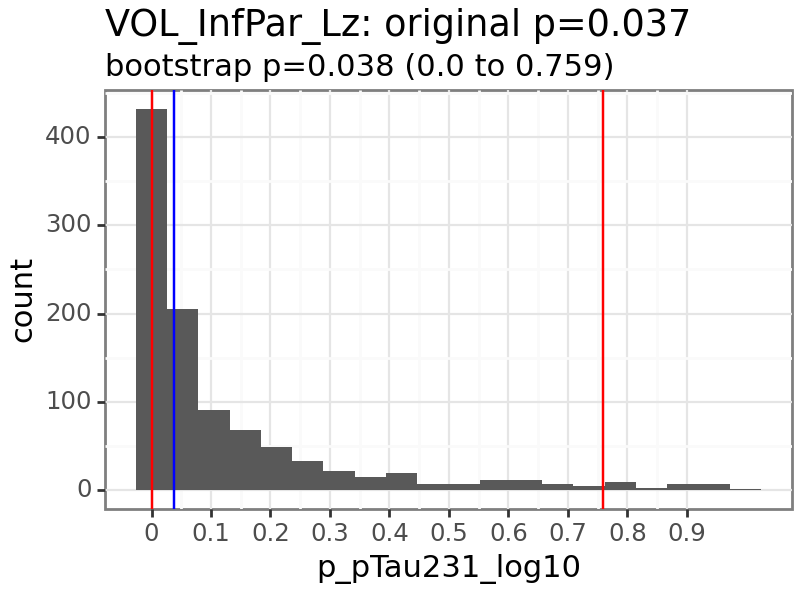

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


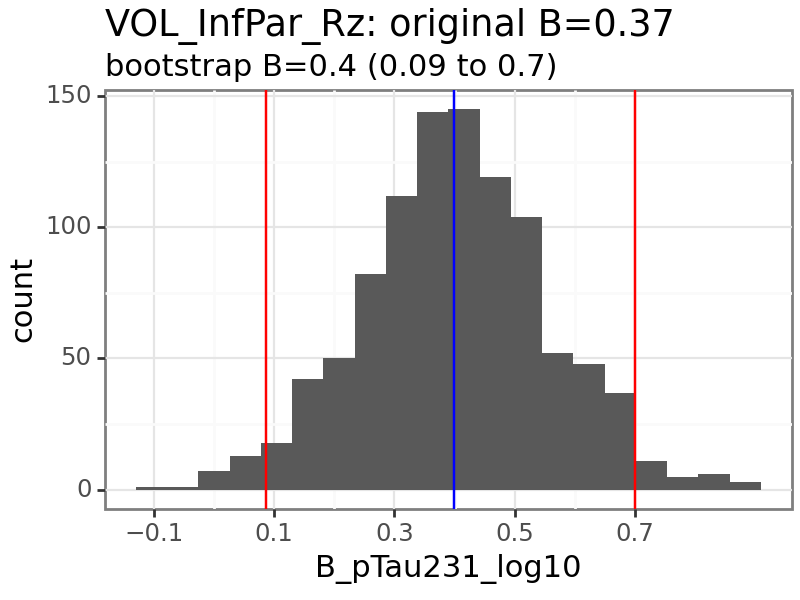

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


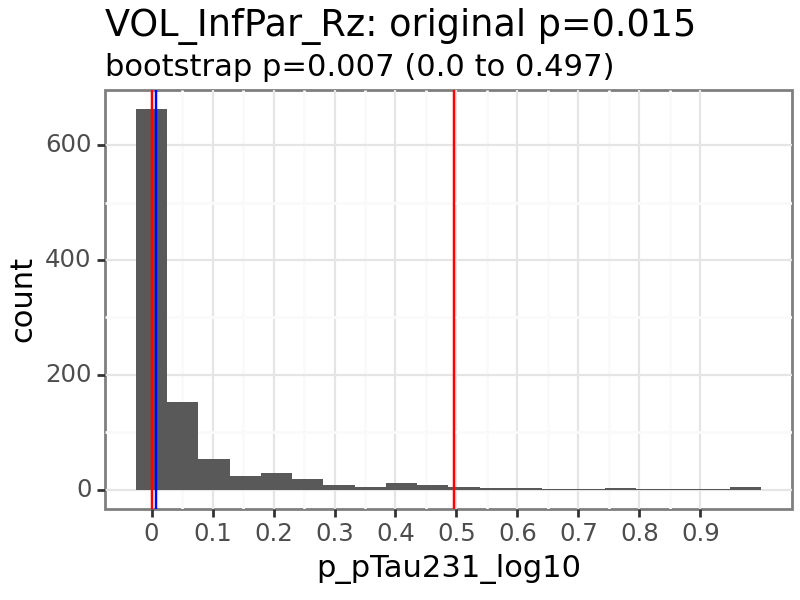

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


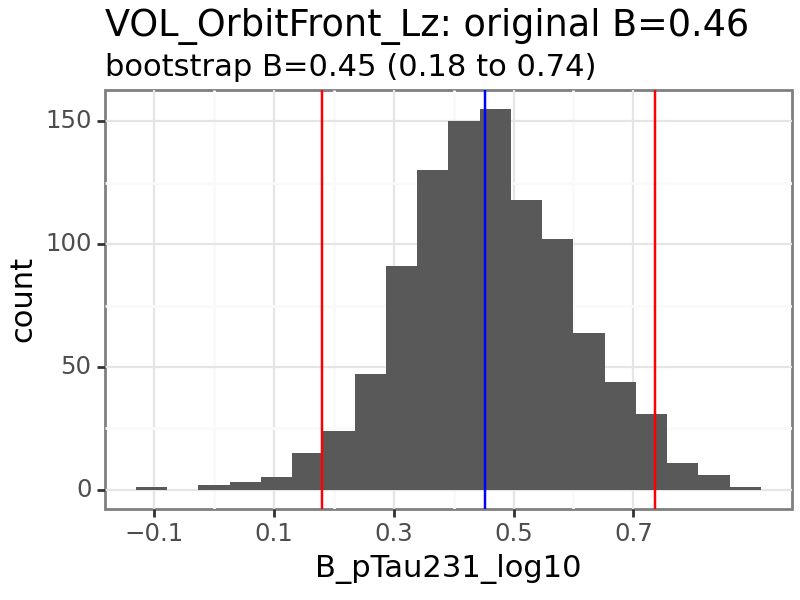

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


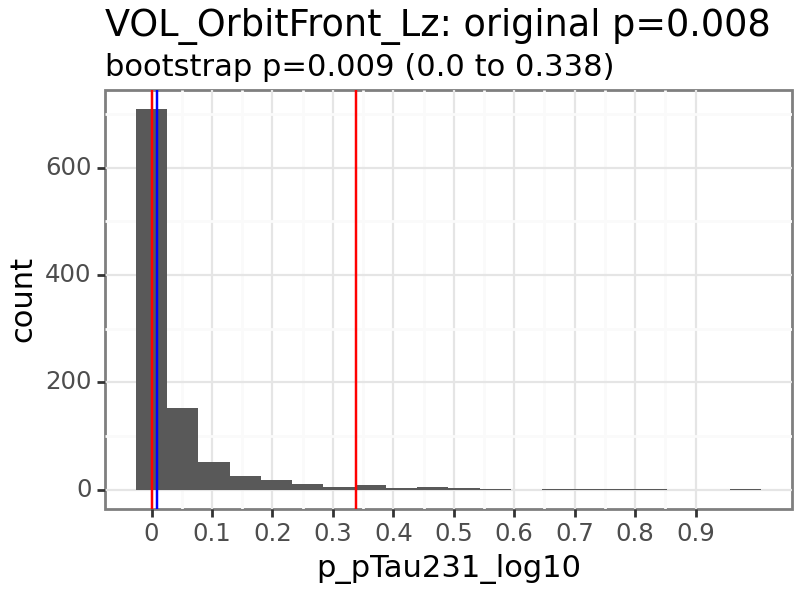

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


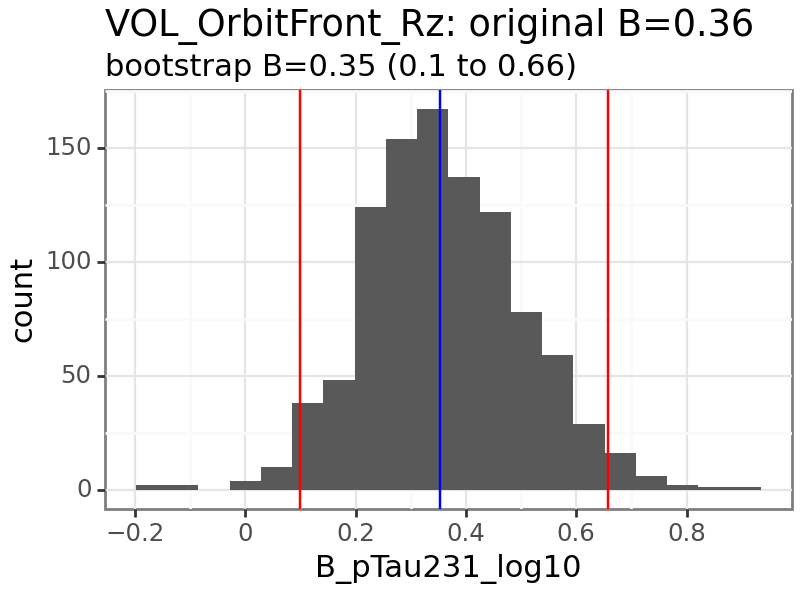

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


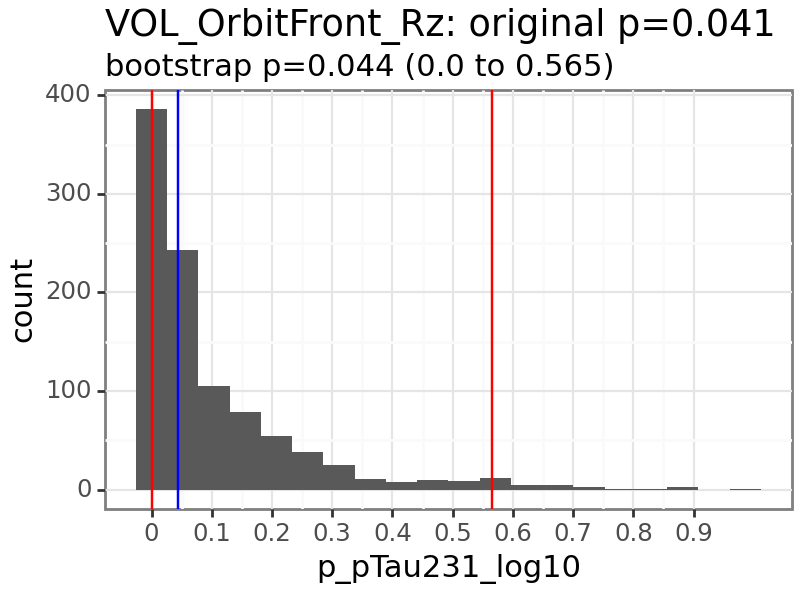

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


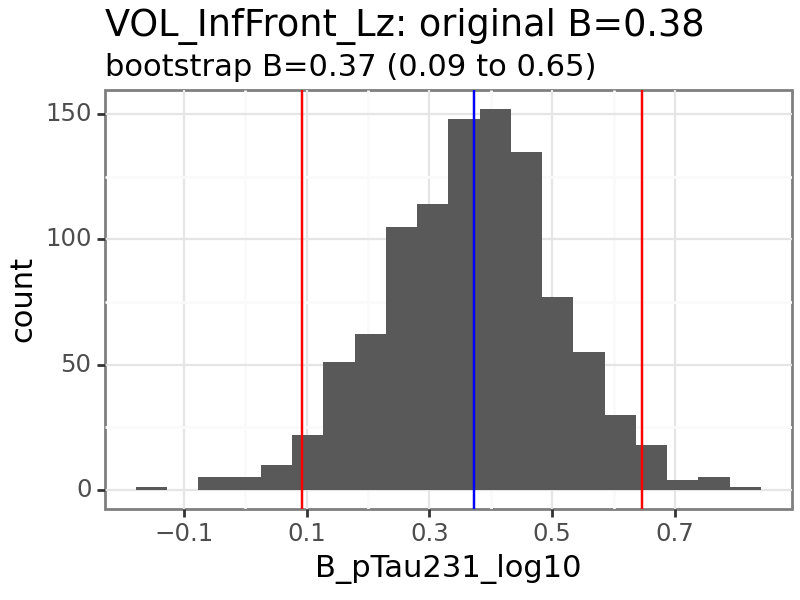

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


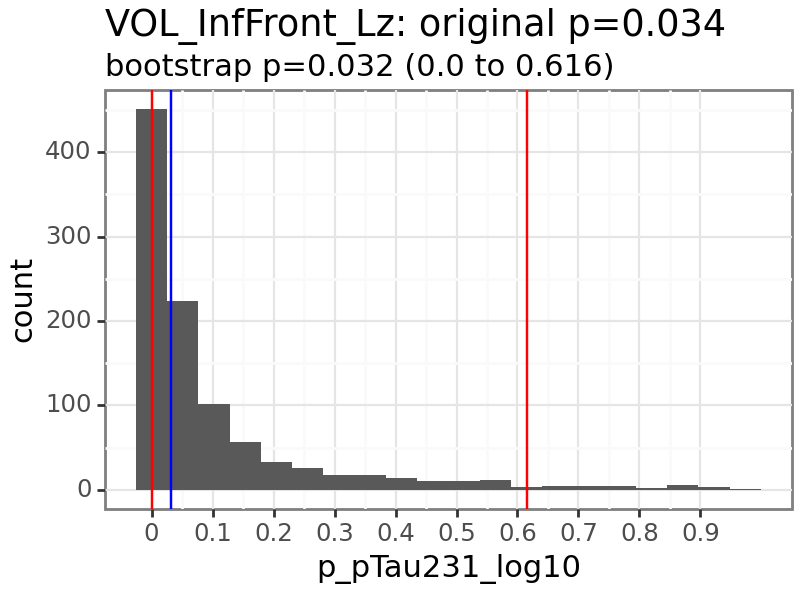

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


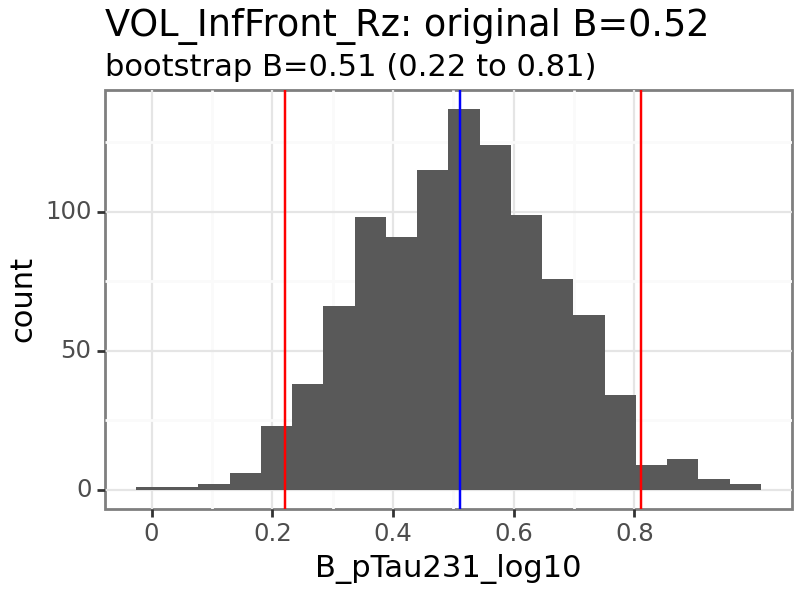

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


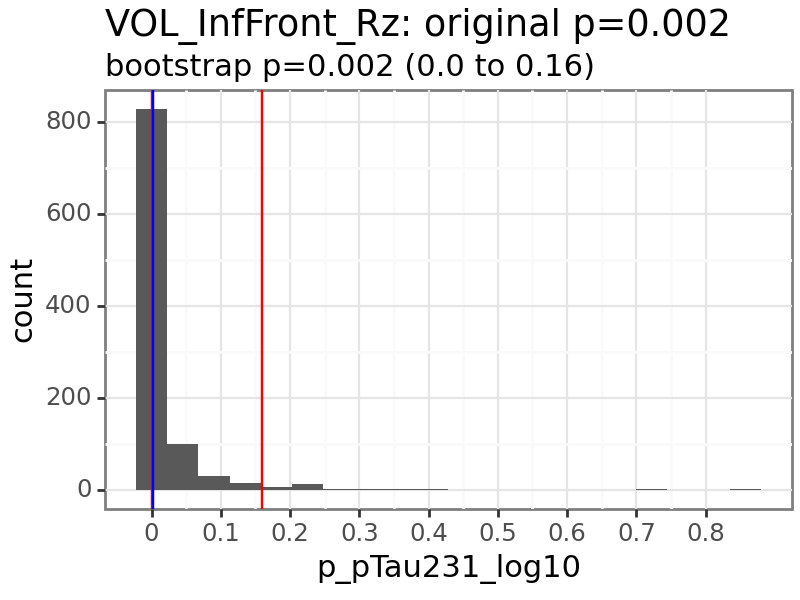

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


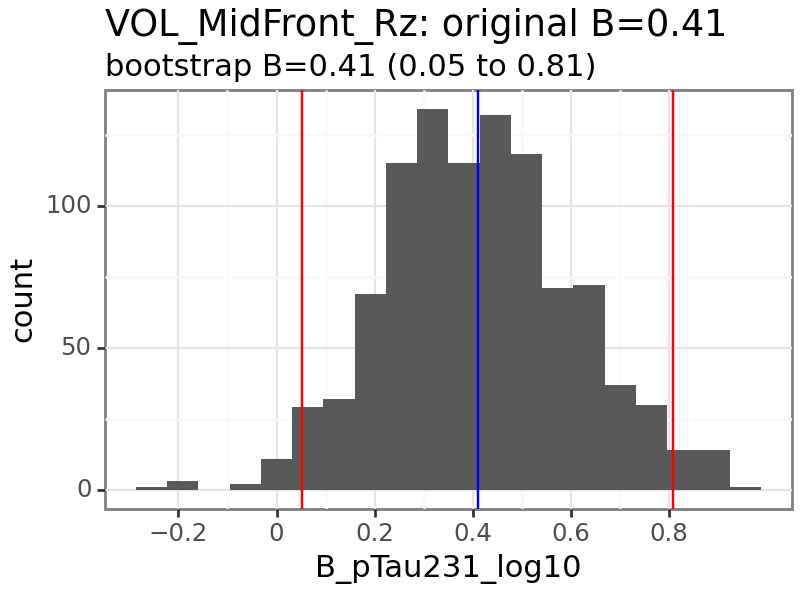

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


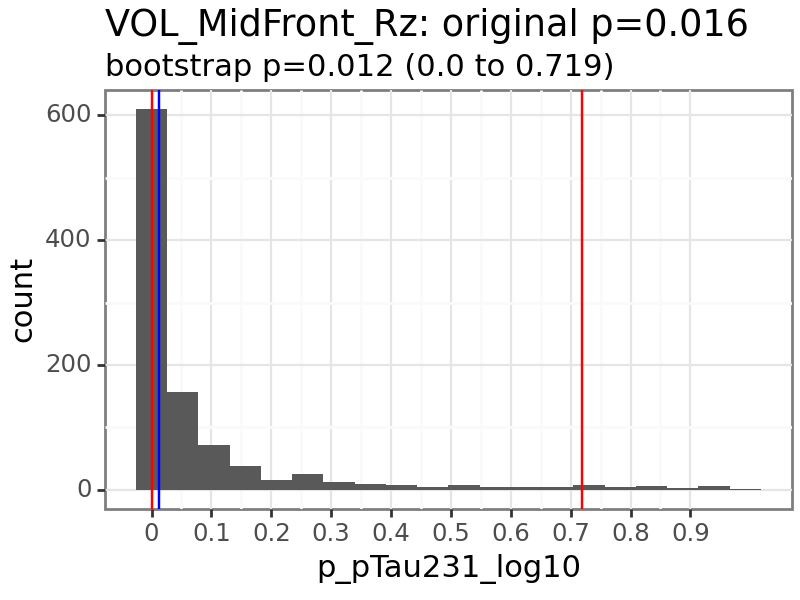

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


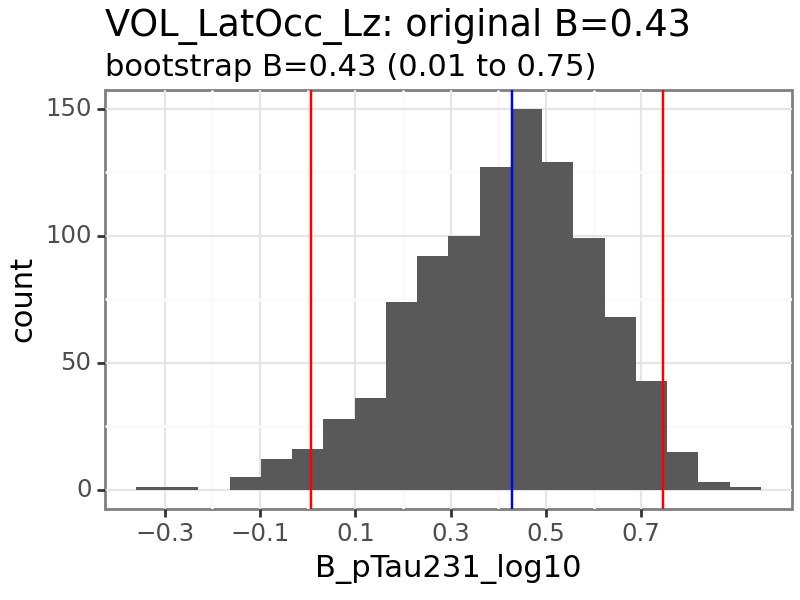

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


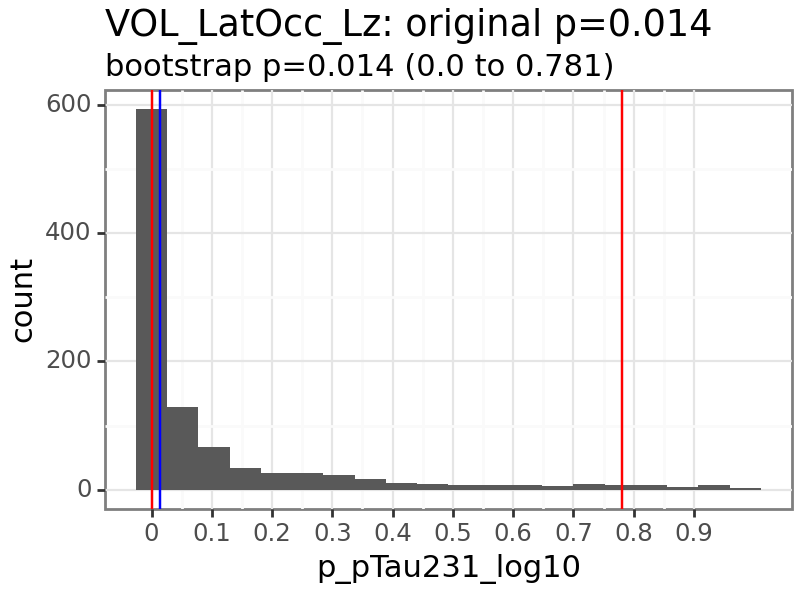

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


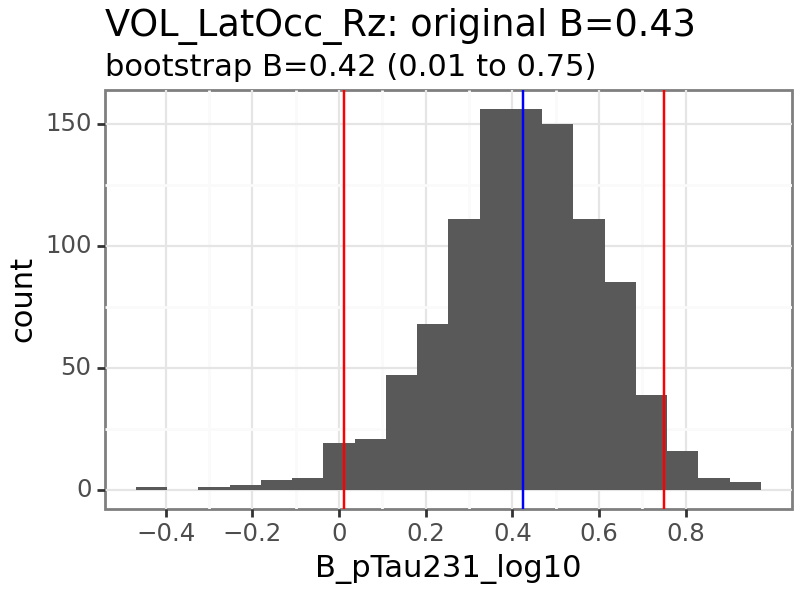

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


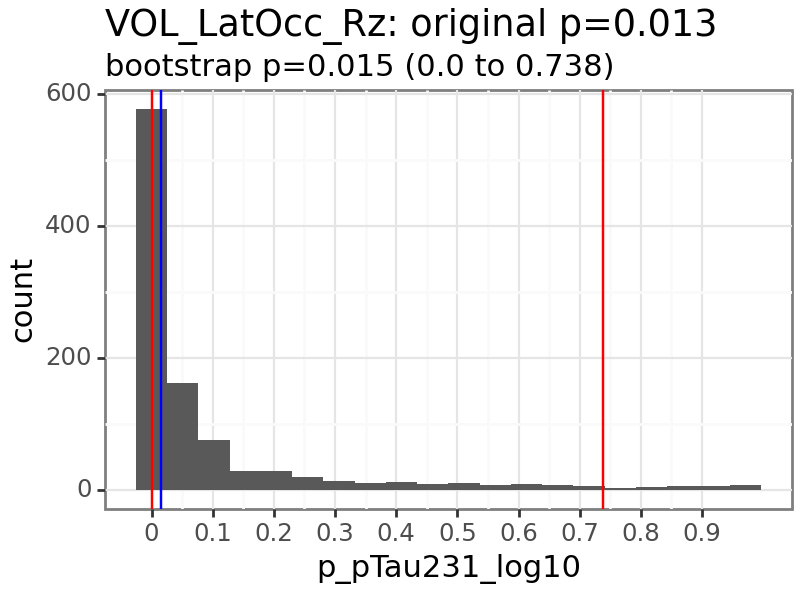

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


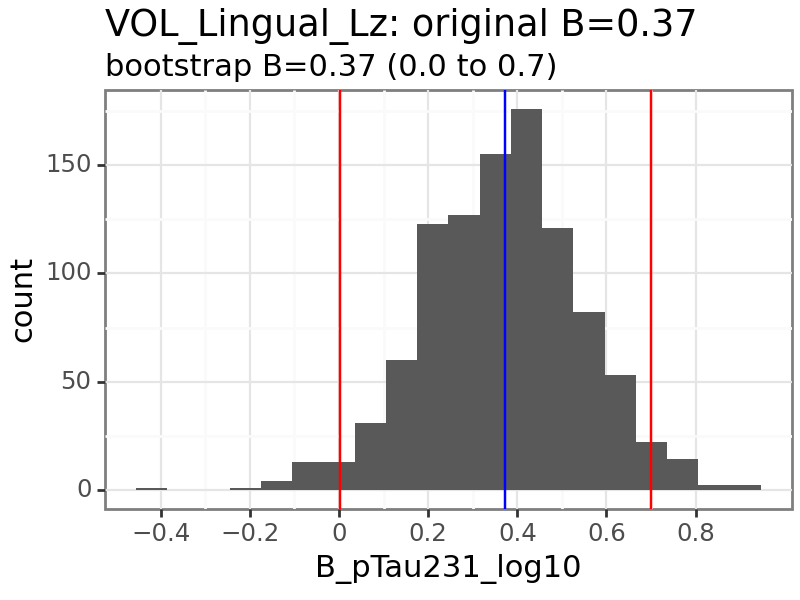

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


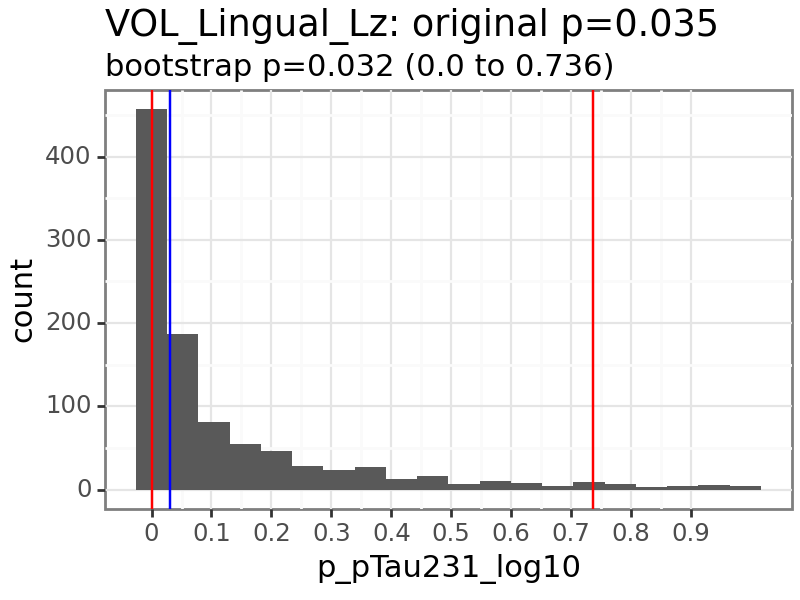

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


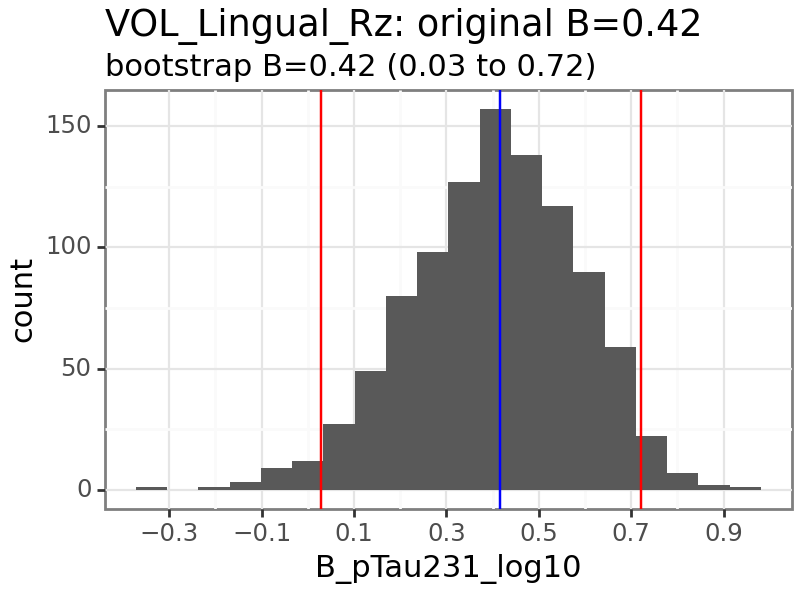

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


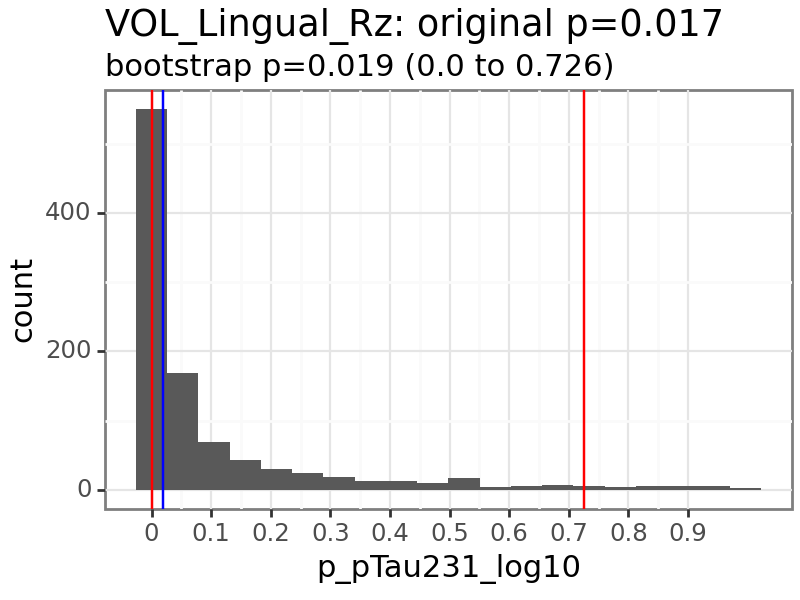

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


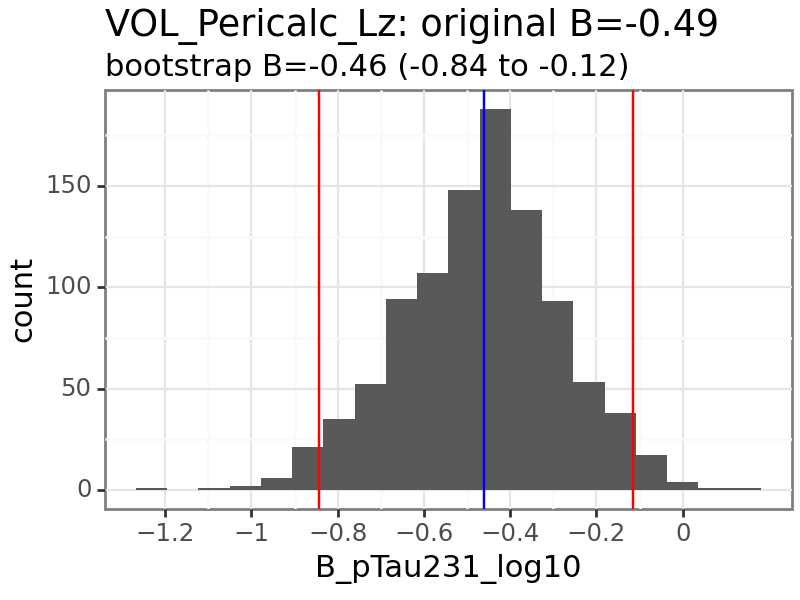

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


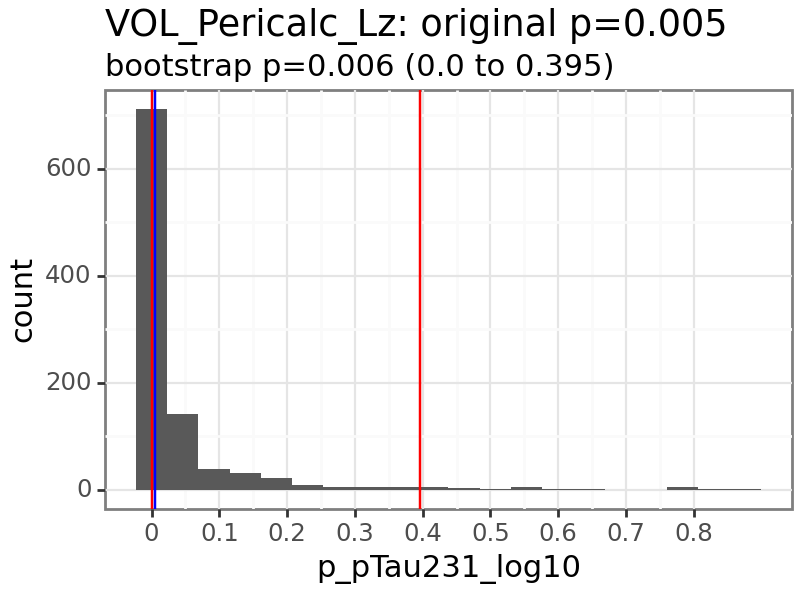

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


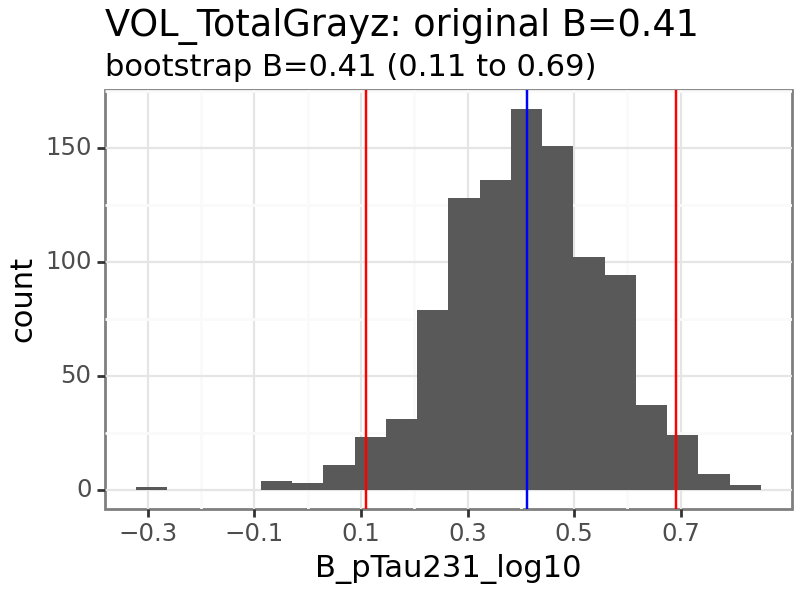

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


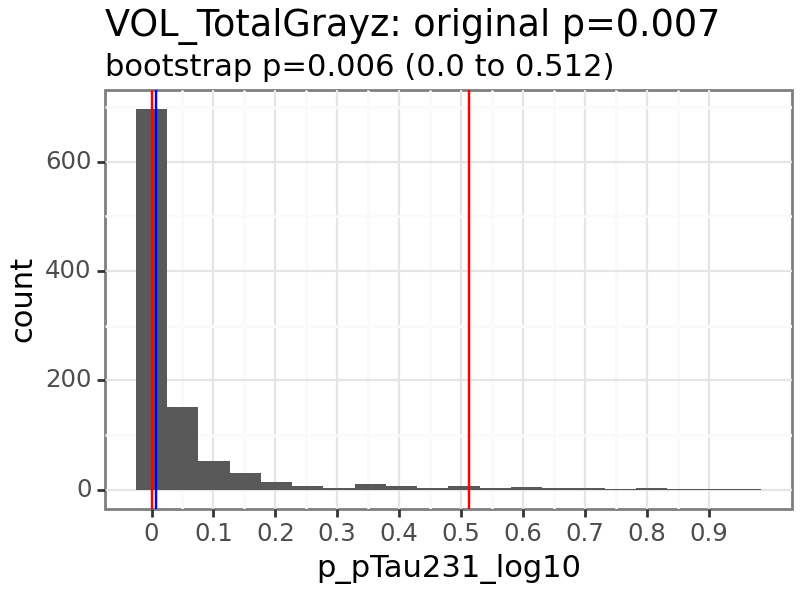

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


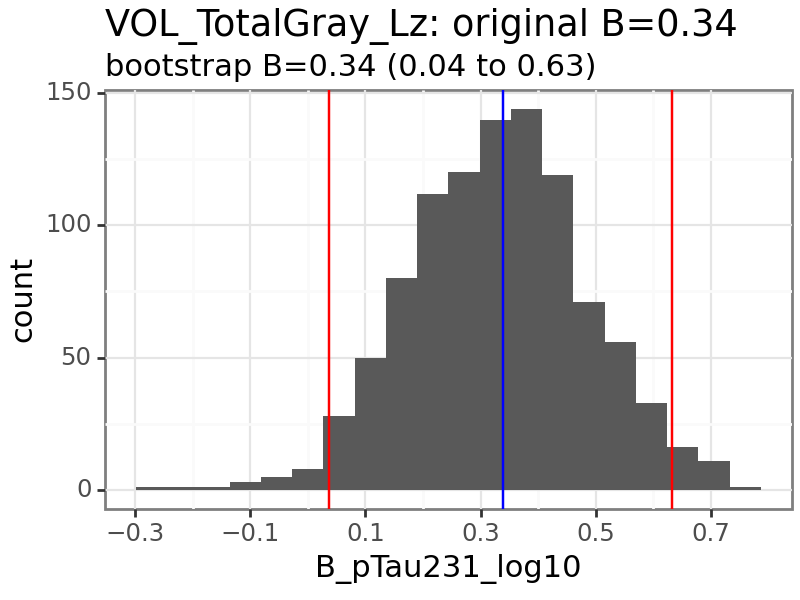

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


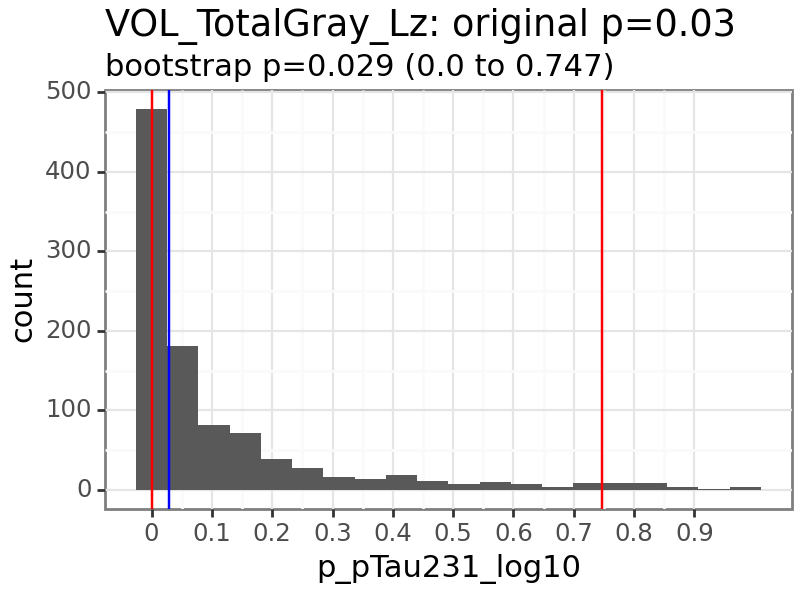

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


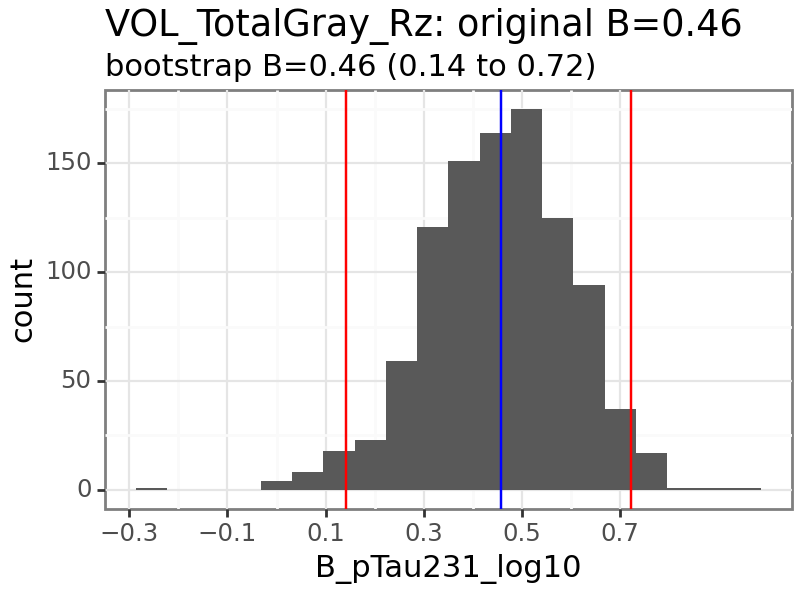

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


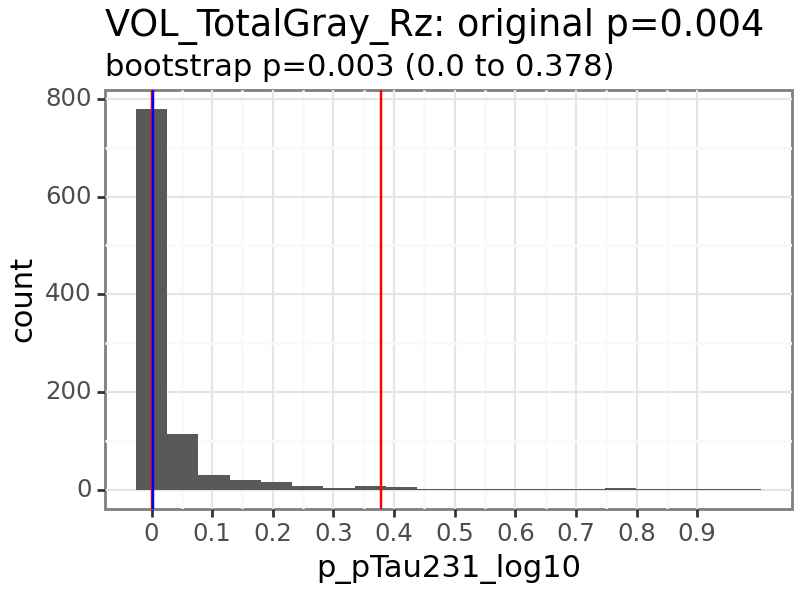

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


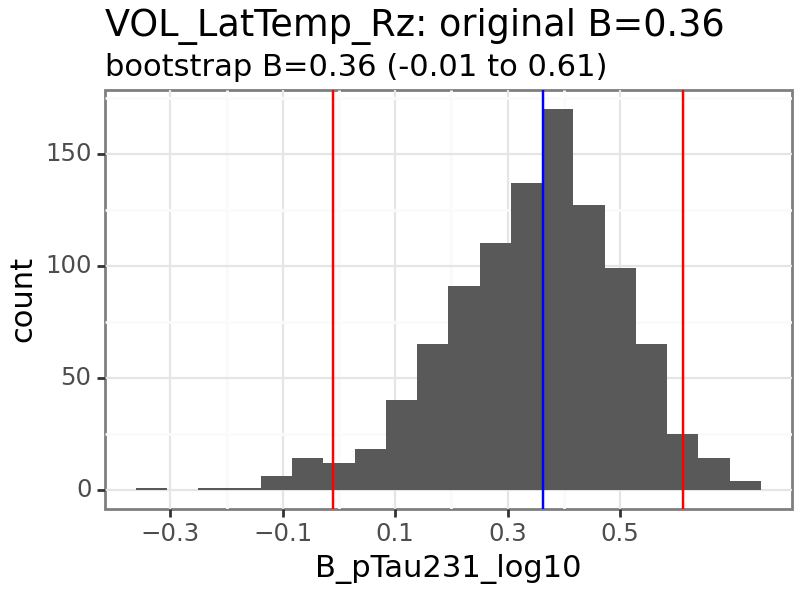

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


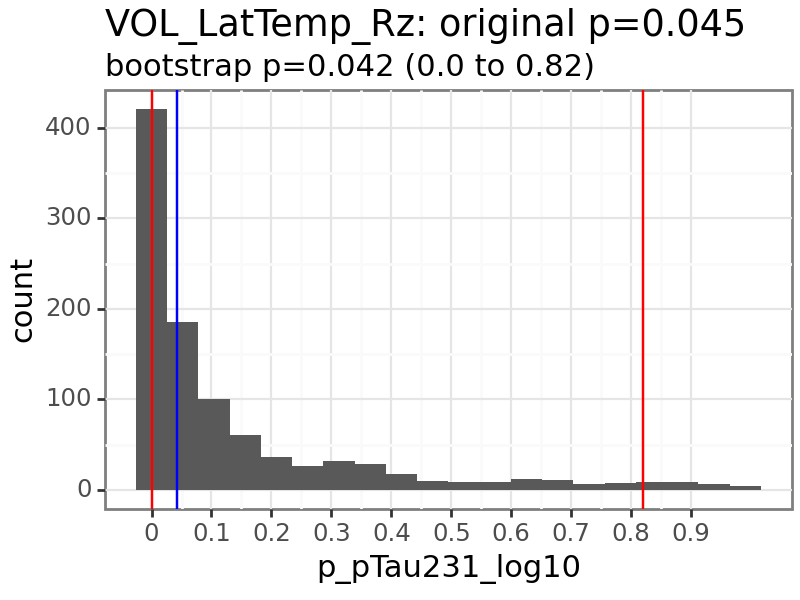

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


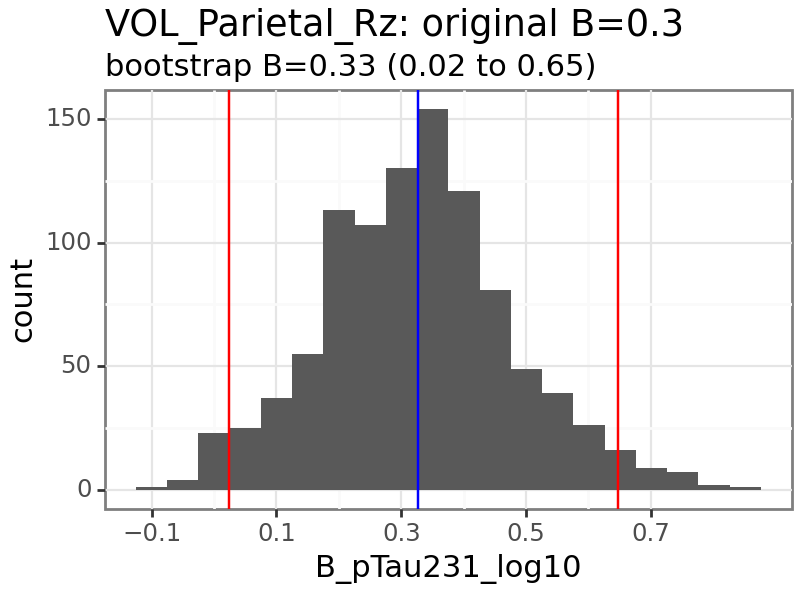

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


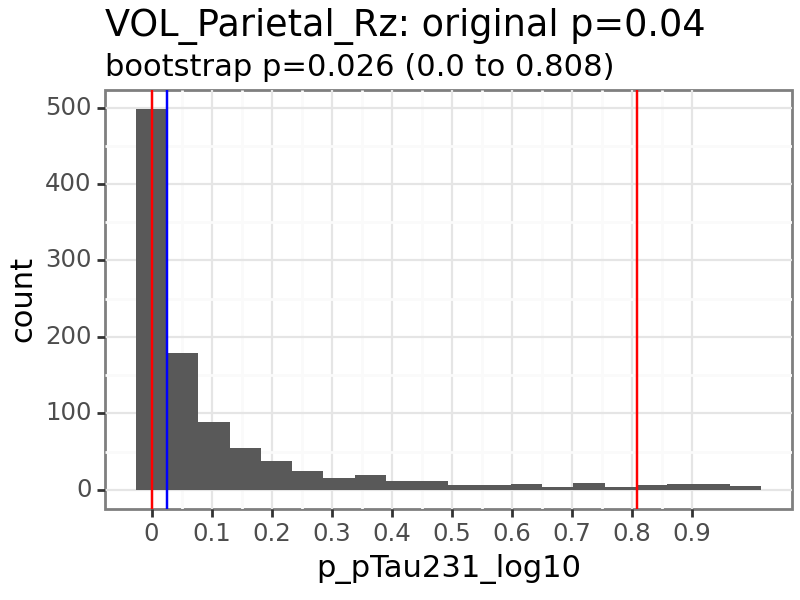

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


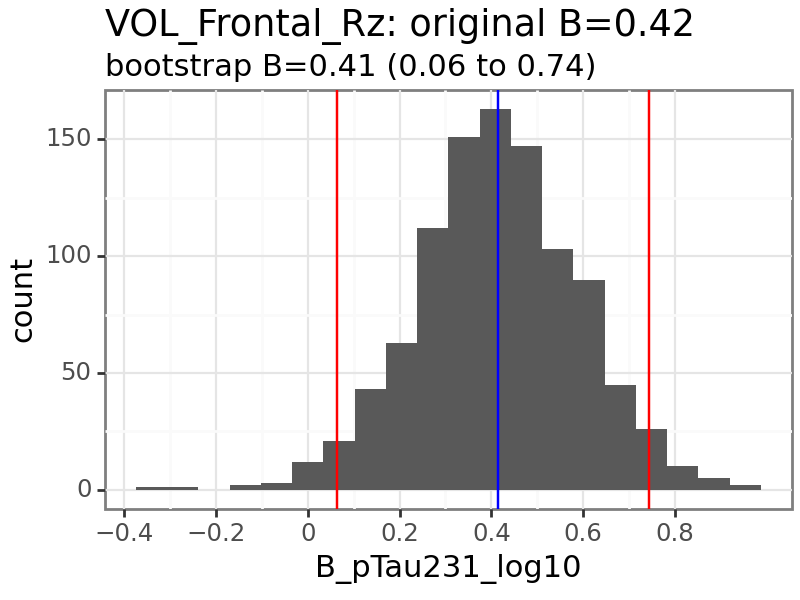

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


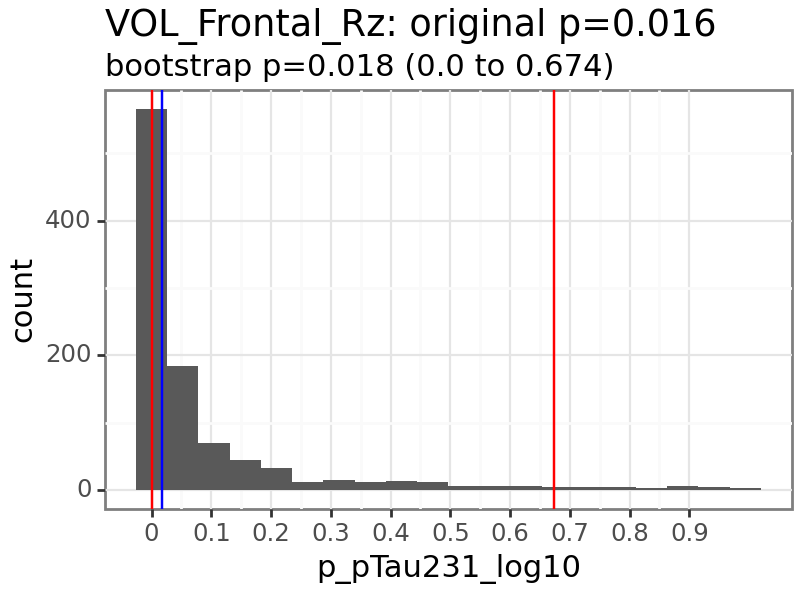

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


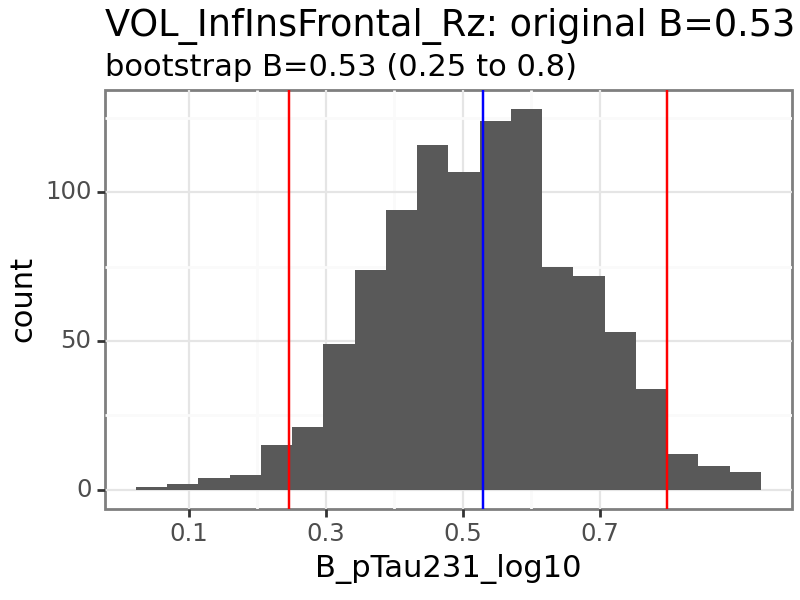

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


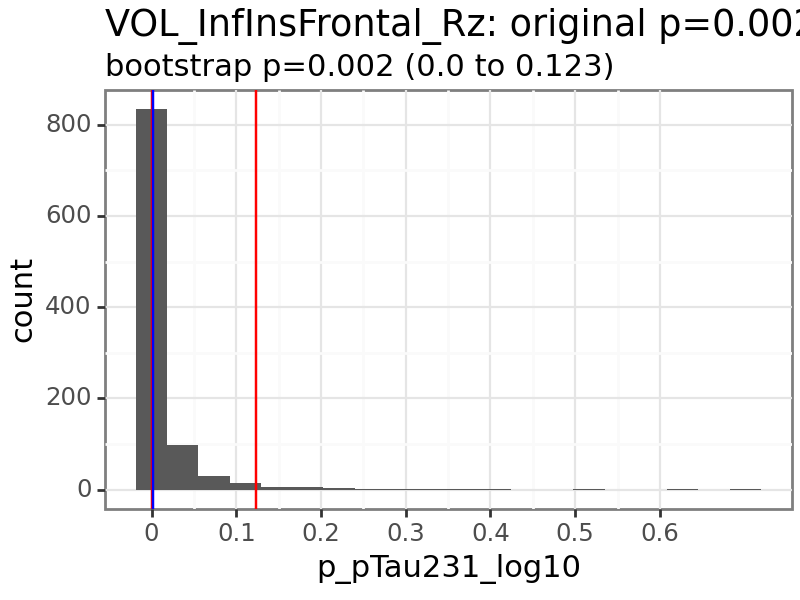

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


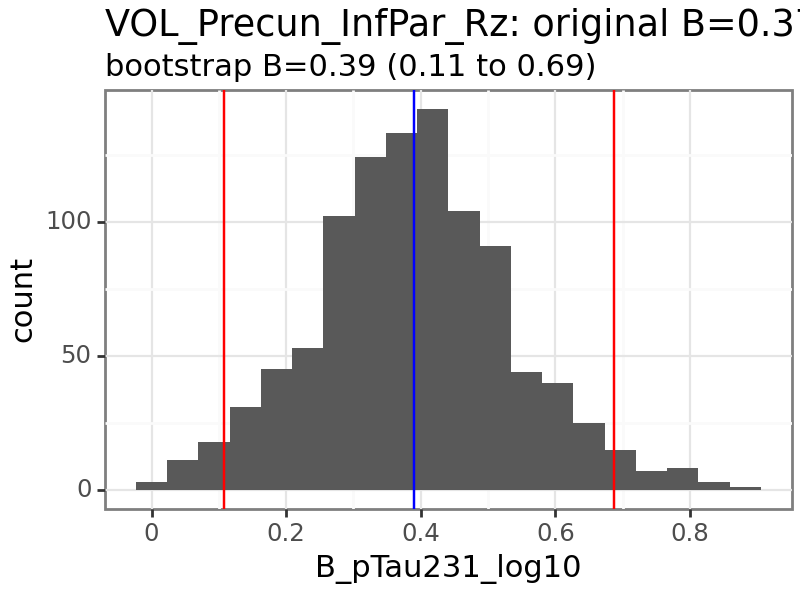

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


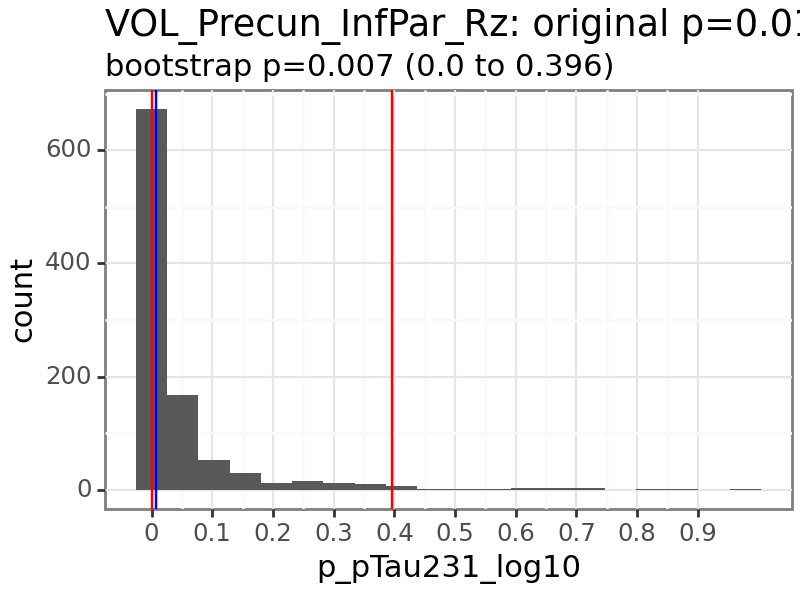

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


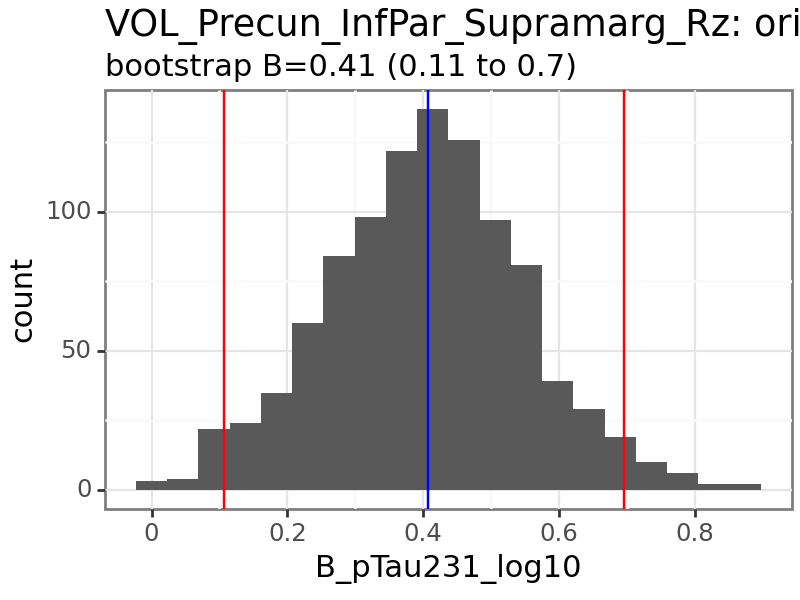

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


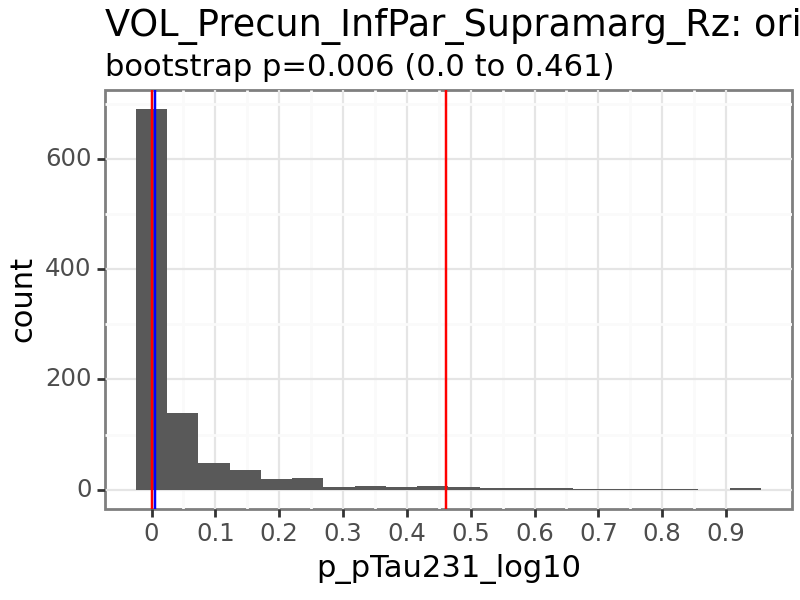

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


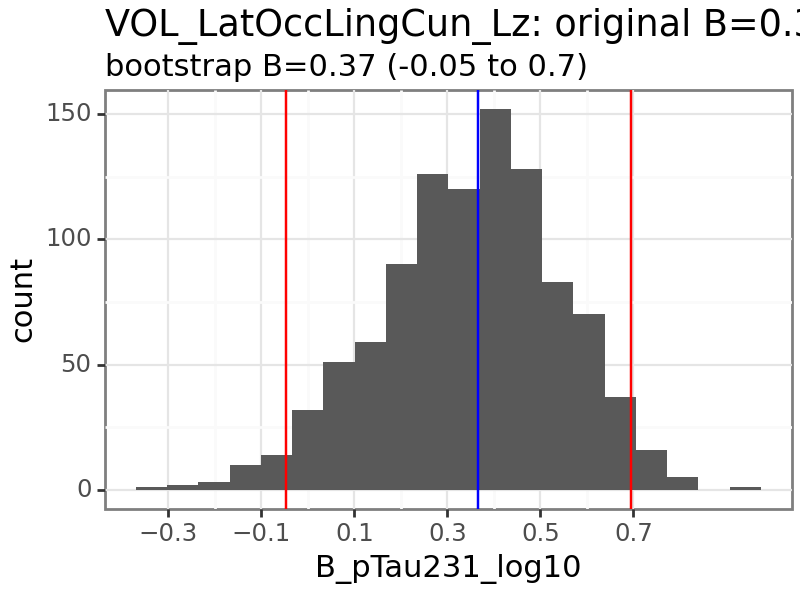

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


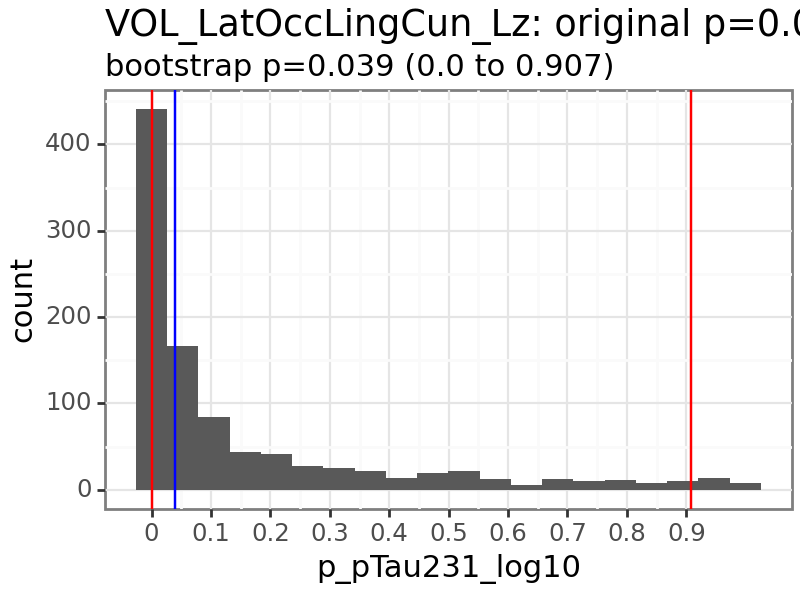

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


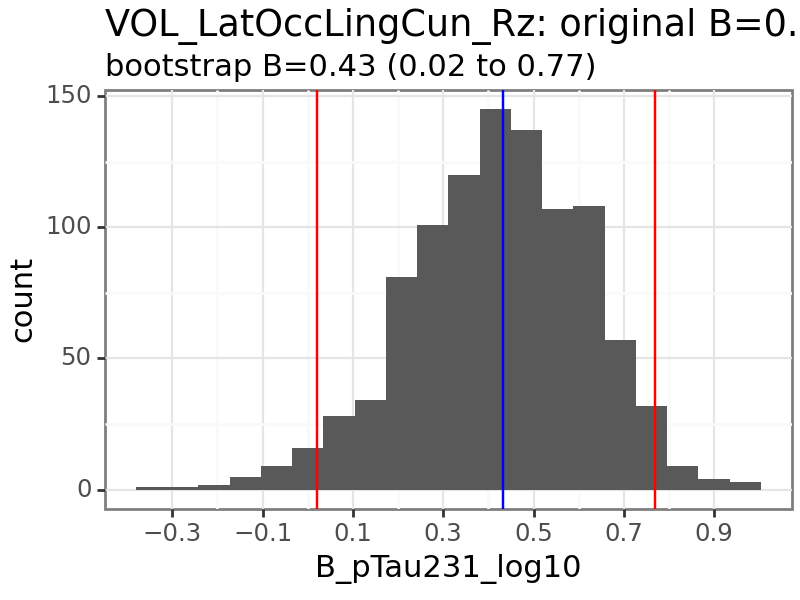

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


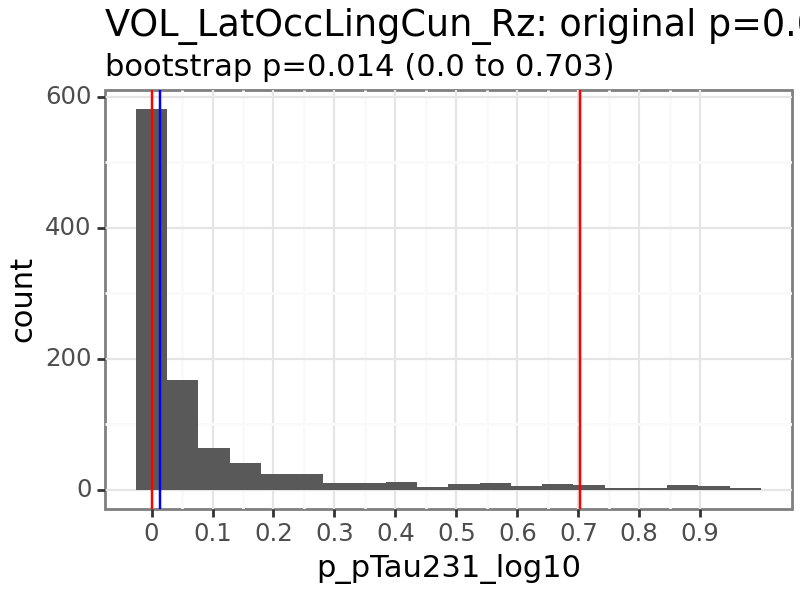

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


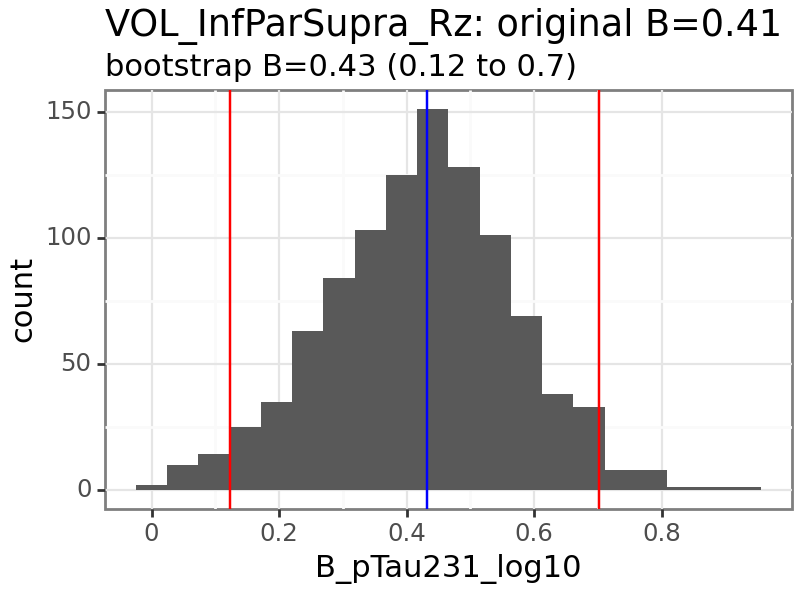

c:\Users\Lauren.Koenig\.conda\envs\Lauren_export_conda_20250102\lib\site-packages\plotnine\stats\binning.py:172: FutureWarning: The provided callable <function sum at 0x0000020D3C6F8820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


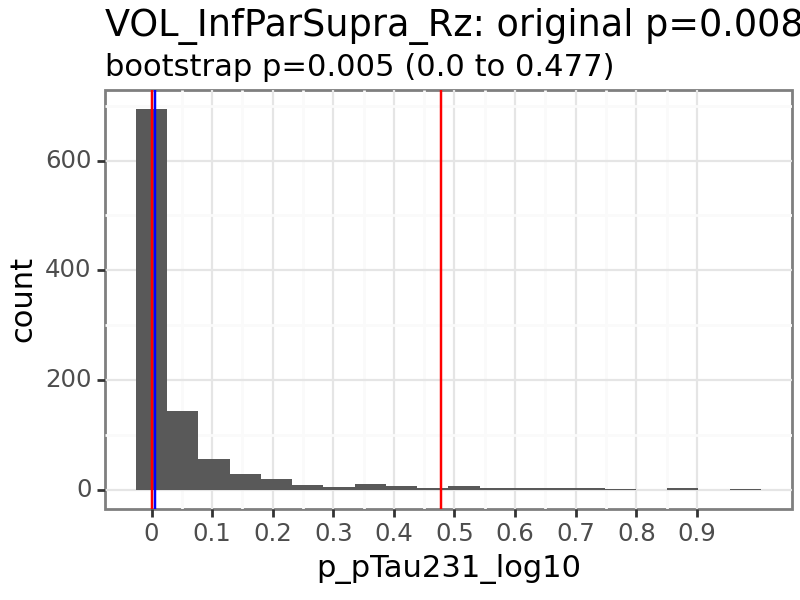

In [19]:
a,  b, c = bootstrap_regression(significant_combos[significant_combos['x_var'].isin(['pTau231_log10'])])
biomarker_relationship_results_log10 = pd.concat([biomarker_relationship_results_log10, a])
biomarker_relationship_results_log10_975 = pd.concat([biomarker_relationship_results_log10_975, b])
biomarker_relationship_results_log10_025 = pd.concat([biomarker_relationship_results_log10_025, c])

# Clean up full list of results

In [20]:
biomarker_relationship_results_log10['type'] = 'other'
biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['y_var'].isin( [ele for ele in FDG_columns if ele in all_data.columns]), 'type'] = 'FDG PET'
biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['y_var'].isin(log10_plasma_columns + log10_plasma_columns), 'type'] = 'Plasma'
biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['y_var'].isin(cog_columns), 'type'] = 'Cognitive'
biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['y_var'].isin(vol_columns), 'type'] = 'Volumetric'

biomarker_relationship_results_log10_025['type'] = 'other'
biomarker_relationship_results_log10_025.loc[biomarker_relationship_results_log10_025['y_var'].isin( [ele for ele in FDG_columns if ele in all_data.columns]), 'type'] = 'FDG PET'
biomarker_relationship_results_log10_025.loc[biomarker_relationship_results_log10_025['y_var'].isin(log10_plasma_columns + log10_plasma_columns), 'type'] = 'Plasma'
biomarker_relationship_results_log10_025.loc[biomarker_relationship_results_log10_025['y_var'].isin(cog_columns), 'type'] = 'Cognitive'
biomarker_relationship_results_log10_025.loc[biomarker_relationship_results_log10_025['y_var'].isin(vol_columns), 'type'] = 'Volumetric'

biomarker_relationship_results_log10_975['type'] = 'other'
biomarker_relationship_results_log10_975.loc[biomarker_relationship_results_log10_975['y_var'].isin( [ele for ele in FDG_columns if ele in all_data.columns]), 'type'] = 'FDG PET'
biomarker_relationship_results_log10_975.loc[biomarker_relationship_results_log10_975['y_var'].isin(log10_plasma_columns + log10_plasma_columns), 'type'] = 'Plasma'
biomarker_relationship_results_log10_975.loc[biomarker_relationship_results_log10_975['y_var'].isin(cog_columns), 'type'] = 'Cognitive'
biomarker_relationship_results_log10_975.loc[biomarker_relationship_results_log10_975['y_var'].isin(vol_columns), 'type'] = 'Volumetric'

# save results

In [21]:
selected_p_column = ['p_x_var']

biomarker_relationship_results_log10 = biomarker_relationship_results_log10.rename(columns = {'B_y_var':'B_x_var', 'p_y_var':'p_x_var', 'x_var':'y_var', 'y_var':'x_var'})
biomarker_relationship_results_log10_025 = biomarker_relationship_results_log10_025.rename(columns = {'B_y_var':'B_x_var', 'p_y_var':'p_x_var', 'x_var':'y_var', 'y_var':'x_var'})
biomarker_relationship_results_log10_975 = biomarker_relationship_results_log10_975.rename(columns = {'B_y_var':'B_x_var', 'p_y_var':'p_x_var', 'x_var':'y_var', 'y_var':'x_var'})

In [22]:
with pd.ExcelWriter(code_folder_loc + 'output/05b_model_results_500_' + data_name + '.xlsx') as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    biomarker_relationship_results_log10[biomarker_relationship_results_log10['x_var'].isin(['Ab42_40_log10'])].to_excel(writer, sheet_name='Ab42_40', index=False)
    biomarker_relationship_results_log10[biomarker_relationship_results_log10['x_var'].isin(['pTau181_log10'])].to_excel(writer, sheet_name='pTau181', index=False)
    biomarker_relationship_results_log10[biomarker_relationship_results_log10['x_var'].isin(['pTau217_log10'])].to_excel(writer, sheet_name='pTau217', index=False)
    biomarker_relationship_results_log10[biomarker_relationship_results_log10['x_var'].isin(['pTau231_log10'])].to_excel(writer, sheet_name='pTau231', index=False)
    biomarker_relationship_results_log10[biomarker_relationship_results_log10['x_var'].isin(['GFAP_log10'])].to_excel(writer, sheet_name='GFAP', index=False)
    biomarker_relationship_results_log10[biomarker_relationship_results_log10['x_var'].isin(['pTau217_Ab42_log10'])].to_excel(writer, sheet_name='pTau217_Ab42', index=False)
    biomarker_relationship_results_log10.loc[(biomarker_relationship_results_log10[selected_p_column].min(axis = 1)<0.05), :].to_excel(writer, sheet_name='Significant', index=False)

In [23]:
with pd.ExcelWriter(code_folder_loc + 'output/05b_model_results_025_' + data_name + '.xlsx') as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    biomarker_relationship_results_log10_025[biomarker_relationship_results_log10_025['x_var'].isin(['Ab42_40_log10'])].to_excel(writer, sheet_name='Ab42_40', index=False)
    biomarker_relationship_results_log10_025[biomarker_relationship_results_log10_025['x_var'].isin(['pTau181_log10'])].to_excel(writer, sheet_name='pTau181', index=False)
    biomarker_relationship_results_log10_025[biomarker_relationship_results_log10_025['x_var'].isin(['pTau217_log10'])].to_excel(writer, sheet_name='pTau217', index=False)
    biomarker_relationship_results_log10_025[biomarker_relationship_results_log10_025['x_var'].isin(['pTau231_log10'])].to_excel(writer, sheet_name='pTau231', index=False)
    biomarker_relationship_results_log10_025[biomarker_relationship_results_log10_025['x_var'].isin(['GFAP_log10'])].to_excel(writer, sheet_name='GFAP', index=False)
    biomarker_relationship_results_log10_025[biomarker_relationship_results_log10_025['x_var'].isin(['NFL_log10'])].to_excel(writer, sheet_name='NFL', index=False)
    biomarker_relationship_results_log10_025[biomarker_relationship_results_log10_025['x_var'].isin(['pTau217_Ab42_log10'])].to_excel(writer, sheet_name='pTau217_Ab42', index=False)
    biomarker_relationship_results_log10_025.loc[(biomarker_relationship_results_log10_025[selected_p_column].min(axis = 1)<0.05), :].to_excel(writer, sheet_name='Significant', index=False)

In [24]:
with pd.ExcelWriter(code_folder_loc + 'output/05b_model_results_975_' + data_name + '.xlsx') as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    biomarker_relationship_results_log10_975[biomarker_relationship_results_log10_975['x_var'].isin(['Ab42_40_log10'])].to_excel(writer, sheet_name='Ab42_40', index=False)
    biomarker_relationship_results_log10_975[biomarker_relationship_results_log10_975['x_var'].isin(['pTau181_log10'])].to_excel(writer, sheet_name='pTau181', index=False)
    biomarker_relationship_results_log10_975[biomarker_relationship_results_log10_975['x_var'].isin(['pTau217_log10'])].to_excel(writer, sheet_name='pTau217', index=False)
    biomarker_relationship_results_log10_975[biomarker_relationship_results_log10_975['x_var'].isin(['pTau231_log10'])].to_excel(writer, sheet_name='pTau231', index=False)
    biomarker_relationship_results_log10_975[biomarker_relationship_results_log10_975['x_var'].isin(['GFAP_log10'])].to_excel(writer, sheet_name='GFAP', index=False)
    biomarker_relationship_results_log10_975[biomarker_relationship_results_log10_975['x_var'].isin(['NFL_log10'])].to_excel(writer, sheet_name='NFL', index=False)
    biomarker_relationship_results_log10_975[biomarker_relationship_results_log10_975['x_var'].isin(['pTau217_Ab42_log10'])].to_excel(writer, sheet_name='pTau217_Ab42', index=False)
    biomarker_relationship_results_log10_975.loc[(biomarker_relationship_results_log10_975[selected_p_column].min(axis = 1)<0.05), :].to_excel(writer, sheet_name='Significant', index=False)